# 웹 크롤링 part (대한민국 구석구석 관광지 명)

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
import pandas as pd
import time

초기설정

In [ ]:
# 웹 드라이버 설정 (Chrome 사용 예제)
options = Options()
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)

# 웹 페이지 열기
url = 'https://korean.visitkorea.or.kr/list/travelinfo.do?service=ms'
driver.get(url)
driver.maximize_window()

함수 선언부

In [ ]:
def button_click():
    # "인기순" 버튼 클릭
    popular_button = WebDriverWait(driver, 20).until(EC.element_to_be_clickable((By.XPATH, '//button[contains(text(), "인기순")]')))
    driver.execute_script("arguments[0].click();", popular_button)

    # 서울 버튼 클릭
    seoul_button = WebDriverWait(driver, 20).until(EC.element_to_be_clickable((By.XPATH, '//*[@id="1"]/button/span')))
    driver.execute_script("arguments[0].click();", seoul_button)

    # 서울 버튼 클릭 후, 해당 지역의 데이터가 로드될 때까지 대기
    wait = WebDriverWait(driver, 30)
    wait.until(EC.presence_of_element_located((By.XPATH, '//*[@id="contents"]/div[2]/div[1]/ul/li[1]/div[2]/div/a')))


# 각 페이지 데이터 추출 함수
# 이동한 페이지의 데이터를 추출하기 위해, 이동한 페이지의 html 소스를 가져와 파싱
def extract_data(soup, attraction_list, location_list, tag_list):
    for i in range(10):
        attraction = soup.select_one(f'#contents > div.wrap_contView.clfix > div.box_leftType1 > ul > li:nth-child({i+1}) > div.area_txt.catchphrase > div > a')
        location = soup.select_one(f'#contents > div.wrap_contView.clfix > div.box_leftType1 > ul > li:nth-child({i+1}) > div.area_txt.catchphrase > p:nth-child(2)')
        tag = soup.select_one(f'#contents > div.wrap_contView.clfix > div.box_leftType1 > ul > li:nth-child({i+1}) > div.area_txt.catchphrase > p.tag')

        # 명소, 위치, 해쉬 태그 3개를 다 가진 것만 추출
        if attraction and location and tag:
            attraction_list.append(attraction.text)
            location_list.append(location.text)
            tag_list.append(tag.text)

# 각 페이지 스크롤 내리는 함수
def slow_scroll_by(offset, duration):
    steps = 30  # 스크롤을 나누는 단계 수
    step_duration = duration / steps  # 각 단계별 대기 시간
    step_size = offset / steps  # 각 단계별 스크롤 크기
    for _ in range(steps):
        driver.execute_script(f"window.scrollBy(0, {step_size})") # steps 동안 step_size 만큼 반복해서 스크롤
        time.sleep(step_duration) # 1회 스크롤 하고 step_duration 만큼 대기

# 다음 페이지로 넘어가는 함수
def next_page(page_number):
    # 페이지 바에서 모든 페이지 링크 요소를 찾음
    page_bar = driver.find_elements(By.CSS_SELECTOR, '.page_box a')

    # 찾은 페이지 링크 요소들 중에서 지정된 페이지 번호(page_number)와 일치하는 버튼을 클릭
    for button in page_bar:
        if button.get_attribute("id") == str(page_number):
            # element.click() 기본 클릭 메소드
            # 동적 콘텐츠로 로드하는 경우, 기본 클릭 메소드가 작동되지 않음
            # 자바스크립트를 사용하여 클릭 이벤트 실행
            driver.execute_script("arguments[0].click();", button)

            break
    # 페이지가 로드되기 전에 대기
    wait = WebDriverWait(driver, 20)
    # 페이지의 첫 번째 링크 요소가 새로운 페이지 로딩으로 인해 사라질 때까지 대기
    wait.until(EC.staleness_of(page_bar[0]))
    # 새 페이지가 로드된 후, 특정 요소가 존재하는지 확인하여 페이지 로딩 완료를 확인
    wait.until(EC.presence_of_element_located((By.XPATH, '//*[@id="contents"]/div[2]/div[1]/ul/li[1]/div[2]/div/a')))
    # 페이지 로딩 후 잠시 대기
    time.sleep(1.5)

# 한 면에서 넘길 수 있는 페이지 수는 5개
# 그 이후에는 다음 버튼을 클릭해야함.
# 다음 버튼 클릭 함수
def click_next_button():
    # CSS 셀렉터.btn_next.ico를 사용하여 다음 버튼을 찾음
    # CSS 셀렉터는 <a> 태그의 class 속성이 btn_next와 ico를 가진 요소를 찾음
    next_button = driver.find_element(By.CSS_SELECTOR, '.btn_next.ico')
    # 자바스크립트를 사용하여 클릭 이벤트 실행
    driver.execute_script("arguments[0].click();", next_button)
    # 페이지 로드 대기
    wait = WebDriverWait(driver, 20)
    wait.until(EC.staleness_of(next_button))
    # 새로운 페이지 로드 대기:
    wait.until(EC.presence_of_element_located((By.XPATH, '//*[@id="contents"]/div[2]/div[1]/ul/li[1]/div[2]/div/a')))
    time.sleep(1.5)

# 페이지 바 요소
# <div class="page_box">
# <a class="on" title="선택됨" href="javascript:" id="1">1</a>
# <a href="javascript:" id="2">2</a>
# <a href="javascript:" id="3">3</a>
# <a href="javascript:" id="4">4</a>
# <a href="javascript:" id="5">5</a>
# <a href="javascript:" class="btn_next ico" id="6">다음</a>
# <a class="btn_last ico" href="javascript:" id="3937">끝</a></div>


코드 작성부

In [ ]:
try:
    # 인기순, 서울 버튼 클릭 함수
    button_click()

    # 대이터 저장 리스트 초기화
    attraction_list = []
    location_list = []
    tag_list = []

    # 첫 번째 페이지의 HTML 소스를 가져와 BeautifulSoup으로 파싱
    content = driver.page_source
    soup = BeautifulSoup(content, 'html.parser')

    # 첫번째 페이지 추출
    extract_data(soup, attraction_list, location_list, tag_list)

    # 2페이지부터 페이지 이동 및 데이터 추출 반복
    for p in range(2, 15):  # 예시로 15페이지까지
        slow_scroll_by(1600, 3) # 위 스크롤 함수 이용
        next_page(p)    # 페이지 이동 버튼 클릭 함수

        # 이동한 페이지의 HTML 소스를 가져와 BeautifulSoup으로 파싱
        content = driver.page_source
        soup = BeautifulSoup(content, 'html.parser')

        extract_data(soup, attraction_list, location_list, tag_list)

        # 페이지 번호가 5의 배수일 때 "다음" 버튼 클릭
        if p % 5 == 0:
            click_next_button()

    # 데이터프레임 생성 및 출력
    data = {'attraction': attraction_list, 'location': location_list, 'tag': tag_list}
    df = pd.DataFrame(data)
    print(df)

finally:
    # 드라이버 종료
    driver.quit()

             attraction location  \
0             동대문역사문화공원    서울 중구   
1                 서울식물원   서울 강서구   
2        동대문디자인플라자(DDP)    서울 중구   
3                남산서울타워   서울 용산구   
4                   서울숲   서울 성동구   
..                  ...      ...   
131              중앙고등학교   서울 종로구   
132         북한산국립공원(서울)   서울 성북구   
133  여의도 둘레길(여의도 자전거도로)  서울 영등포구   
134        영등포 신길동 홍어거리  서울 영등포구   
135        동대문종합시장 한복상가   서울 종로구   

                                                   tag  
0    #2024_여행가는달과함께하는_발도장여행지#DDP#가족여행#걷기좋은길#관광지#데이트...  
1    #2024_여행가는달과함께하는_발도장여행지#가족과함께#관광지#교육여행#미세먼지_피하...  
2    #19_20한국관광100선#2024_여행가는달과함께하는_발도장여행지#21_22한국관...  
3    #19_20한국관광100선#2024_여행가는달과함께하는_발도장여행지#21_22한국관...  
4    #2024_여행가는달과함께하는_발도장여행지#23_24한국관광100선#가족여행#걷기길...  
..                                                 ...  
131  #고려중앙학원#관광지#기호학교#문화재#사적지#서울중앙고등학교#수도권#역사#역사공부#...  
132  #관광지#북한산#북한산국립공원#생태#생태관광#생태관광지#서울권#수도권#자연#자연#자...  
133  #레포츠#산책코스#샛강생태공원#수변산책로#여의도#여의도한강공원#자전거둘레길#자전거코...

In [ ]:
# 결과물 확인
df[:10]

attraction location                                                tag
0       동대문역사문화공원    서울 중구  #2024_여행가는달과함께하는_발도장여행지#DDP#가족여행#걷기좋은길#관광지#데이트...
1           서울식물원   서울 강서구  #2024_여행가는달과함께하는_발도장여행지#가족과함께#관광지#교육여행#미세먼지_피하...
2  동대문디자인플라자(DDP)    서울 중구  #19_20한국관광100선#2024_여행가는달과함께하는_발도장여행지#21_22한국관...
3          남산서울타워   서울 용산구  #19_20한국관광100선#2024_여행가는달과함께하는_발도장여행지#21_22한국관...
4             서울숲   서울 성동구  #2024_여행가는달과함께하는_발도장여행지#23_24한국관광100선#가족여행#걷기길...
5             경복궁   서울 종로구  #15_16한국관광100선#17_18한국관광100선#19_20한국관광100선#202...
6             인사동   서울 종로구                  #관광지#도심여행#수도권#시티투어#인사동#주말추천여행지#체험
7             익선동   서울 종로구  #21_22한국관광100선#23_24한국관광100선#가족과함께#관광지#남녀노소#뉴트...
8              명동    서울 중구  #15_16한국관광100선#17_18한국관광100선#19_20한국관광100선#관광지...
9       롯데월드 어드벤처   서울 송파구  #17_18한국관광100선#19_20한국관광100선#2024_여행가는달과함께하는_발...

# 웹 크롤링 part2 (네이버 리뷰 및 정보)

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
import time
import pandas as pd
from urllib.parse import quote

데이터 불러오기 - 구석구석 데이터

In [ ]:
# path는 각자 로컬 환경에 맞게 변경해주세요
dataset_raw = pd.read_csv('../data/구석구석dataset_수정 (1).csv', encoding='cp949')
dataset = dataset_raw.copy()

In [ ]:
# 데이터 확인
dataset

Unnamed: 0             attraction location  \
0              0              동대문역사문화공원    서울 중구   
1              1                  서울식물원   서울 강서구   
2              2         동대문디자인플라자(DDP)    서울 중구   
3              3                  N서울타워   서울 용산구   
4              4                    서울숲   서울 성동구   
...          ...                    ...      ...   
3742        3742            이비스앰배서더 인사동   서울 종로구   
3743        3743                코스모스아트홀   서울 서초구   
3744        3744         번지피지오 옴니바디웍스청담   서울 강남구   
3745        3745              커뮤니티하우스마실    서울 중구   
3746        3746  씨에스에비뉴호텔(CS AVENUE호텔)   서울 은평구   

                                                    tag  
0     #2024_여행가는달과함께하는_발도장여행지#DDP#가족여행#걷기좋은길#관광지#데이트...  
1     #2024_여행가는달과함께하는_발도장여행지#가족과함께#관광지#교육여행#미세먼지_피하...  
2     #19_20한국관광100선#2024_여행가는달과함께하는_발도장여행지#21_22한국관...  
3     #19_20한국관광100선#2024_여행가는달과함께하는_발도장여행지#21_22한국관...  
4     #2024_여행가는달과함께하는_발도장여행지#23_24한국관광100선#가족여행#걷기길...  
...                                                 ...  
3742          #서울이비스앰배서더호텔#숙박#인사동숙박#인사동앰배서더#인사동호텔#종로구호텔  
3743  #공연장대여#그랜드피아노공연장#문화시설#서초구공연장#서초구아트홀#서초리사이틀장#코스...  
3744  #강남요가원#관광지#번지피지오#번지피지오옴니바디웍스청담#옴니바디웍스청담#취미운동#키...  
3745        #개러지홀#마실#명동마실#명동커뮤니티하우스마실#문화시설#페이지명동#프라이빗살롱  
3746          #숙박#씨에스에비뉴호텔#은평구숙소#은평구호텔#은평글램핑호텔#호텔씨에스에비뉴  

[3747 rows x 4 columns]

In [ ]:
# 관광지명 리스트 생성
dataset_values = dataset['attraction'].values

In [ ]:
# 관광지명 리스트 생성 확인
print(len(dataset_values))
print(dataset_values)

3747
['동대문역사문화공원' '서울식물원' '동대문디자인플라자(DDP)' ... '번지피지오 옴니바디웍스청담' '커뮤니티하우스마실'
 '씨에스에비뉴호텔(CS AVENUE호텔)']


In [ ]:
# 관광지명 리시트 인덱싱 확인
dataset_values[1600]

'호텔 삼정'

크롤링 코드 부분

- \# i번 으로 코드 진행 순서 명시해두었습니다. (코드 진행 흐름 파악용) >> 컨트롤 f 하셔서 i번 검색하시면 찾을 수 있습니다.
- a번 > b번 > c번 > d번 > e번 순
    - a번 : 구석구석 데이터 관광지명 리스트에서 관광지명 하나씩 추출해서 네이버 지도 창에 검색하는 코드
    - b번 : 검색된 창에서 검색 결과중 1) 관광지명과 가장 관련도가 큰 관광지 2) 주소가 서울특별시인 관광지 를 선택해서 들어가게하는 코드
    - c번 : 관광지 창에서 리뷰버튼 찾고 방문자 리뷰 '이런점이 좋았어요' 부분이 있으면 펼친 뒤 데이터 추출하는 함수 호출하는 코드
    - d번 : 데이터 추출하는 함수 코드
    - e번 : 추출된 데이터 DataFrame으로 만드는 코드

In [ ]:
# 웹 드라이버 설정
driver = webdriver.Chrome()
driver.maximize_window()

# 추출한 데이터 저장할 저장소 초기화
tourist_spot_list = []
good_point_list = []
selected_people_list = []
fail_spot_list = []
spot_attribute_list = []


# d번
# 데이터 추출 코드
def extract_data():
    try:
        tourist_spot = spot

        # 사용 가능한 '이런 점이 좋았어요' 요소 개수 파악
        # MHaAm : '이런 점이 좋았어요' 요소 CLASS NAME
        # 따라서 MHaAm 로 접근하여 각 요소 리스트에 담고 길이 구하기
        good_points_elements = driver.find_elements(By.CLASS_NAME, 'MHaAm')
        num_good_points = len(good_points_elements)

        # 첫번째 부터 마지막 요소번째 까지 반복
        for j in range(0, num_good_points + 1):
            try:
                # 좋은 점과 선택한 사람 수 추출
                good_point = driver.find_elements(By.CLASS_NAME, 't3JSf')[j].text # 이런 점이 좋았어요 - 이런점 추출
                selected_people = driver.find_elements(By.CLASS_NAME, 'CUoLy')[j].text # 이런 점이 좋았어요 - 투표 수 추출
                spot_attribute = driver.find_element(By.CLASS_NAME, 'lnJFt').text # 관광지 속성(네이버 지도 - 관광지명 옆 작은 카테고리명)

                # 추출된 요소들 리스트에 넣기 - 후반부 DataFrame 생성시 사용
                good_point_list.append(good_point)
                selected_people_list.append(selected_people)
                spot_attribute_list.append(spot_attribute)
                tourist_spot_list.append(tourist_spot)

            except Exception as e:
                print(f"항목 {j}은(는) 존재하지 않습니다. 오류: {e}")
                if 'driver' in locals():
                    driver.quit()
                return None

    except Exception as e:
        print(f"데이터 추출 중 오류 발생: {e}")

#--------------------------------------------------------------------------------------------------------------------
# 크롤링 코드 작성부

## a번
for j in range(0,15):

    # @창 띄우고 관광지 이름으로 검색하는 코드@
    # spot : 구석구석 관광지명 리스트에서 인덱싱된 관광지명
    spot = dataset_values[j]

    # 특수 문자 포함 관광지명 인코딩해주는 코드
    encoded_spot = quote(spot)

    # 지도 페이지로 바로 들어가도록 변경
    # 기존 코드와 다르게 접근
    driver.get(f"https://m.map.naver.com/search2/search.naver?query={encoded_spot}")
    time.sleep(5)

#---------------------------------------------------------------------------------------------------------------------
    # @지도창으로 들어와서 관광지 이름 버튼 클릭하는 코드@

    # b번
    # map_paths : 지도 검색 페이지에서 해당 관광지의 XPATH 모음 리스트
    map_paths = [
        '//*[@id="ct"]/div[2]/ul/li[1]/div[1]/a/div/strong',
        '//*[@id="ct"]/div[2]/ul/li[1]/div[1]/a[2]/div/strong'
    ]

    element_clicked = False
    timeout_count = 0 # TimeoutException 발생 횟수
    for map_path in map_paths:
        try:
            place_button = WebDriverWait(driver, 5).until(
                EC.element_to_be_clickable((By.XPATH, map_path))
            )

            # 주소 나오게 하는 버튼
            button = WebDriverWait(driver, 5).until(
                EC.element_to_be_clickable((By.XPATH, '//*[@id="ct"]/div[2]/ul/li[1]/div[1]/div[1]/div/a/i'))
            )
            button.click()

            # 주소가 서울특별시로 시작하지 않는 경우 클릭되지 않게 만드는 코드
            adress = driver.find_element(By.XPATH, '//*[@id="ct"]/div[2]/ul/li[1]/div[1]/div[2]/div/p[1]').text
            adress_para = '서울특별시'

            if adress[0:5] == adress_para:
                place_button.click()
                element_clicked = True

        except TimeoutException:
            print(F"{spot}에 대한 관광지 버튼을 찾지 못했습니다.")
            timeout_count += 1 # 타임아웃 발생 시 횟수 1회씩 증가

    if not element_clicked:
        if timeout_count == 2:
            fail_spot_list.append(spot)
        continue

    # c번
    # @해당 관광지 창으로 들어와서 리뷰버튼 클릭하는 코드@
    review_xpaths = [
        '//*[@id="app-root"]/div/div/div/div[4]/div/div/div/div/a[2]/span',
        '//*[@id="app-root"]/div/div/div/div[4]/div/div/div/div/a[3]/span',
        '//*[@id="app-root"]/div/div/div/div[4]/div/div/div/div/a[4]/span',
        '//*[@id="app-root"]/div/div/div/div[4]/div/div/div/div/a[5]/span'
    ]

    try:
        review_found = False # 리뷰가 크롤링되면 나머지 review_xpath는 생략하도록 설정
        for review_xpath in review_xpaths:
            if review_found:
                break  # 리뷰를 찾았으면 루프를 종료

            review_button = WebDriverWait(driver, 5).until(
                EC.element_to_be_clickable((By.XPATH, review_xpath))
            )
            review_button.click()

            # 방문자 리뷰 - '이런점이 좋았어요' 펼치는 버튼 클릭 6번
            # button_class_name : 펼치는 버튼 CLASS NAME
            button_class_name = "dP0sq"

            for i in range(6):
                try:
                    first_button = WebDriverWait(driver, 10).until(
                        EC.element_to_be_clickable((By.CLASS_NAME, button_class_name))
                    )
                    driver.execute_script("arguments[0].click();", first_button)
                    print(f"{spot} - {i+1}번째 버튼 클릭 성공")
                    # 다음 보기 버튼 누르는 것에 성공한다면 원하는 데이터 추출
                    # 함수 사용
                    extract_data()
                    review_found = True  # 리뷰를 찾았음을 표시 - 리뷰가 크롤링되면 나머지 review_xpath는 생략하도록 설정

                except TimeoutException:
                    print(f"{spot} - {i+1}번째 버튼이 존재하지 않아 클릭하지 않고 넘어갑니다.")
                    break

    except TimeoutException:
        print(F"{spot}에 대한 리뷰 버튼을 찾지 못했습니다.")
        continue

# e번
# 추출한 데이터 데이터 프레임 형식으로 만들기
data = {
    'tourist_spot': tourist_spot_list,
    'spot_arrtribute' : spot_attribute_list,
    'good_point': good_point_list,
    'selected_people': selected_people_list
}
df = pd.DataFrame(data)
df = df.drop_duplicates()

# 드라이버 종료
driver.quit()

새만포면옥 - 1번째 버튼이 존재하지 않아 클릭하지 않고 넘어갑니다.
새만포면옥 - 1번째 버튼이 존재하지 않아 클릭하지 않고 넘어갑니다.
새만포면옥 - 1번째 버튼 클릭 성공
항목 10은(는) 존재하지 않습니다. 오류: list index out of range
새만포면옥 - 2번째 버튼 클릭 성공
항목 15은(는) 존재하지 않습니다. 오류: list index out of range
새만포면옥 - 3번째 버튼 클릭 성공
항목 20은(는) 존재하지 않습니다. 오류: list index out of range
새만포면옥 - 4번째 버튼 클릭 성공
항목 25은(는) 존재하지 않습니다. 오류: list index out of range
새만포면옥 - 5번째 버튼 클릭 성공
항목 26은(는) 존재하지 않습니다. 오류: list index out of range
새만포면옥 - 6번째 버튼이 존재하지 않아 클릭하지 않고 넘어갑니다.
플랫폼 플레이스(한남점) - 1번째 버튼 클릭 성공
항목 8은(는) 존재하지 않습니다. 오류: list index out of range
플랫폼 플레이스(한남점) - 2번째 버튼이 존재하지 않아 클릭하지 않고 넘어갑니다.
브릿지안경 - 1번째 버튼이 존재하지 않아 클릭하지 않고 넘어갑니다.
브릿지안경 - 1번째 버튼이 존재하지 않아 클릭하지 않고 넘어갑니다.
브릿지안경 - 1번째 버튼 클릭 성공
항목 10은(는) 존재하지 않습니다. 오류: list index out of range
브릿지안경 - 2번째 버튼이 존재하지 않아 클릭하지 않고 넘어갑니다.
한국금융사박물관 - 1번째 버튼이 존재하지 않아 클릭하지 않고 넘어갑니다.
한국금융사박물관 - 1번째 버튼 클릭 성공
항목 7은(는) 존재하지 않습니다. 오류: list index out of range
한국금융사박물관 - 2번째 버튼이 존재하지 않아 클릭하지 않고 넘어갑니다.
신당동 허리케인박 떡볶이 - 1번째 버튼이 존재하지 않아 클릭하지 않고 넘어갑니다.
신당동 허리케인박 떡볶이에 대한 리

In [ ]:
# 생성된 데이터 프레임 확인
df

tourist_spot spot_arrtribute      good_point     selected_people
0          새만포면옥              냉면      "음식이 맛있어요"  이 키워드를 선택한 인원\n517
1          새만포면옥              냉면          "친절해요"  이 키워드를 선택한 인원\n230
2          새만포면옥              냉면      "건강한 맛이에요"  이 키워드를 선택한 인원\n161
3          새만포면옥              냉면      "재료가 신선해요"  이 키워드를 선택한 인원\n159
4          새만포면옥              냉면      "매장이 청결해요"  이 키워드를 선택한 인원\n124
..           ...             ...             ...                 ...
578      파로스관광호텔             3성급     "인테리어가 멋져요"    이 키워드를 선택한 인원\n2
579      파로스관광호텔             3성급      "주차하기 편해요"    이 키워드를 선택한 인원\n2
590      파로스관광호텔             3성급     "사진이 잘 나와요"    이 키워드를 선택한 인원\n1
591      파로스관광호텔             3성급  "수영장이 잘 되어있어요"    이 키워드를 선택한 인원\n1
592      파로스관광호텔             3성급       "방음이 잘돼요"    이 키워드를 선택한 인원\n1

[223 rows x 4 columns]

In [ ]:
# 리뷰 크롤링 성공한 관광지 모음
df['tourist_spot'].unique()

array(['새만포면옥', '플랫폼 플레이스(한남점)', '브릿지안경', '한국금융사박물관', '황토추어탕', '해담채 삼성점',
       '까사빠보', '포포인츠 바이 쉐라톤 조선 서울역 더 이터리', '신촌 시스터즈', '오양회참치 광화문본점',
       'h450', '에프호텔', '파로스관광호텔'], dtype=object)

In [ ]:
# 리뷰 크롤링 성공한 관광지 개수 확인
len(df['tourist_spot'].unique())

13

In [ ]:
# 이름 변경이 필요한 관광지 모음
fail_spot

[]

In [ ]:
# 이름 변경이 필요한 관광지 개수 확인
len(fail_spot)

5

크롤링 결과는 3가지 유형이 존재
1. 성공 - 리뷰 '이런 점이 좋았어요' 가 존재하여 성공적으로 크롤링된 관광지
2. 실패 - 구석구석에 등록된 관광지명으로 네이버 지도 검색이 불가능해서 크롤링 실패된 관광지
3. 실패 - 구석구석에 등록된 관광지명으로 네이버 지도 검색이 가능하나 리뷰 크롤링이 불가능한 관광지
    - 3 유형은 크게 2가지 유형으로 나뉜다.
        1. 리뷰 '이런 점이 좋았어요' 가 존재하지 않아서 크롤링 되지 않는 경우 >> 문제없음 크롤링 안되는 게 맞음
        2. 리뷰 '이런 점이 좋았어요' 가 존재하지만 XPATH가 특이해서 크롤링 코드가 못가져 오는 경우 >> 다음 경우가 문제

- 따라서,
    - 2 유형 이름 확인 후 검색 되도록 수정 필요!!
    - 3-2 유형의 목록을 뽑고 수작업으로 확인 필요!!

In [ ]:
df.to_csv('../13_result.csv')

# OPEN API (네이버 위도 경도)

### 네이버 위도 경도 뽑기


In [ ]:
import requests
import pandas as pd
import time

In [ ]:
XY = pd.read_csv('101-600.csv')
XY_unique = XY.drop_duplicates(subset='tourist_spot')
XY_unique.info()

<class 'pandas.core.frame.DataFrame'>
Index: 187 entries, 0 to 3099
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tourist_spot     187 non-null    object
 1   good_point       187 non-null    object
 2   selected_people  187 non-null    int64 
 3   addr             46 non-null     object
 4   total_people     46 non-null     object
dtypes: int64(1), object(4)
memory usage: 8.8+ KB


In [ ]:
import requests
import pandas as pd
import time

# 네이버 API 키 설정
client_id = 'client_id 넣어주세요 '
client_secret = 'client_secret key 넣어주세요 '

def find_places_naver(keywords):
    success_data = []
    fail_data = []

    for searching in keywords:
        try:
            url = f'https://openapi.naver.com/v1/search/local.json?query={searching}&display=1'
            headers = {
                "X-Naver-Client-Id": client_id,
                "X-Naver-Client-Secret": client_secret
            }

            response = requests.get(url, headers=headers)
            places = response.json().get('items', [])

            # 오류 및 실패 처리..
            if not places:
                fail_data.append((searching, 'No data'))
                time.sleep(1)
                continue

            place = places[0]
            name = place['title']

            # 정수로 가져와서 소수점 맞춰줌
            x = float(place['mapx']) / 10000000  # 소수점 포함 형식으로 변환
            y = float(place['mapy']) / 10000000  # 소수점 포함 형식으로 변환
            success_data.append((name, x, y, searching))

        except Exception as e:
            fail_data.append((searching, str(e)))

        # 각 요청 사이에 1초 대기
        time.sleep(1)

    success_df = pd.DataFrame(success_data, columns=['Name', 'Longitude', 'Latitude', 'attraction'])
    fail_df = pd.DataFrame(fail_data, columns=['Search Term', 'Error'])

    return success_df, fail_df

# --------------------------------------------------------------------------------------------------------



# csv 여기다가 불러오기
XY = pd.read_csv('101-600.csv')
XY_unique = XY.drop_duplicates(subset='tourist_spot')

# 리스트로 변환
Location_name_list = XY_unique['tourist_spot'].tolist()

# 빈 데이터프레임에 컬럼명 생성
all_success_df = pd.DataFrame(columns=['Name', 'Longitude', 'Latitude', 'attraction'])
all_fail_df = pd.DataFrame(columns=['Search Term', 'Error'])

# 각 관광지에 대해 검색을 수행
for name in Location_name_list:
    keywords = [name]  # 리스트로 감싸서 단일 키워드로 맨듬
    success_df, fail_df = find_places_naver(keywords)

    all_success_df = pd.concat([all_success_df, success_df], ignore_index=True)
    all_fail_df = pd.concat([all_fail_df, fail_df], ignore_index=True)

# 성공한 데이터프레임에서 중복 제거 후 첫번째 한 개만 출력
XY_unique_results = all_success_df.drop_duplicates(subset='Name', keep='first')
XY_unique_results = XY_unique_results[['Longitude', 'Latitude', 'attraction']].copy()


# 결과 출력
print("성공한 데이터프레임 (중복 제거 후):")
print(XY_unique_results)

print("\n실패한 데이터프레임:")
print(all_fail_df)

C:\Users\taeyoung\AppData\Local\Temp\ipykernel_23628\1002234001.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_success_df = pd.concat([all_success_df, success_df], ignore_index=True)
C:\Users\taeyoung\AppData\Local\Temp\ipykernel_23628\1002234001.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_success_df = pd.concat([all_success_df, success_df], ignore_index=True)
C:\Users\taeyoung\AppData\Local\Temp\ipykernel_23628\1002234001.py:69: FutureWarning: The behavior of DataFrame co

성공한 데이터프레임 (중복 제거 후):
      Longitude   Latitude              attraction
0    127.080921  37.549899                서울어린이대공원
1    127.043502  37.546288                섬세이 테라리움
2    126.963300  37.589021               목인박물관 목석원
3    127.090589  37.573197                  용마폭포공원
4    126.978931  37.581564  국립민속박물관&국립민속박물관 어린이박물관
..          ...        ...                     ...
180  127.105360  37.594959                    용마랜드
181  126.985803  37.573485                 통인가게 미술
182  127.098164  37.511079                    롯데월드
183  126.990628  37.498917             서초구민체육센터수영장
184  126.969839  37.580057                서촌게스트하우스

[185 rows x 3 columns]

실패한 데이터프레임:
      Search Term    Error
0    영등포 신길동 홍어거리  No data
1  세종한우정육점식당  2호점  No data


In [ ]:
# 실패 데이터 처리 완료

### 저장 및 확인

In [ ]:
XY_unique_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Longitude   62 non-null     float64
 1   Latitude    62 non-null     float64
 2   attraction  62 non-null     object 
dtypes: float64(2), object(1)
memory usage: 1.6+ KB


In [ ]:
all_fail_df

Search Term    Error
0    영등포 신길동 홍어거리  No data
1  세종한우정육점식당  2호점  No data

In [ ]:
XY_unique_results.to_csv('test.csv', encoding='cp949')

# OPEN API2 (네이버에사 이미지 불러오기)

In [ ]:
import requests
import os
import sys
import urllib.request
import json
import csv
import pandas as pd
import numpy as np

In [ ]:
food_type = pd.read_csv('food_type_final_v2.csv', encoding='cp949')
food_name = food_type[['Attraction']].copy()
food_name[:3]

Attraction
0        채그로
1     소소한 풍경
2    마복림할머니집

In [ ]:
tour_type = pd.read_csv('Tour_Type_Final_v2.csv', encoding='cp949')
tour_name = tour_type[['Attraction']].copy()
tour_name[:3]

Attraction
0     104고지전적비
1  10꼬르소꼬모 청담점
2         63아트

In [ ]:
tour_name.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Attraction  336 non-null    object
dtypes: object(1)
memory usage: 2.8+ KB


In [ ]:
### Naver_API_사진호출

### 사이트 제한 _ Tour

In [ ]:
import os
import urllib.request
import json
import csv
import pandas as pd
import time

def Tour_url_naver(search_name, client_id, client_secret):
    # URL 인코딩을 위해 검색어를 인코딩
    encText = urllib.parse.quote(search_name)
     # 큰 이미지를 필터링하여 검색 URL 생성
    url = f"https://openapi.naver.com/v1/search/image?query={encText}&filter=large"  # 큰 이미지 필터 적용

    # API 요청 생성
    request = urllib.request.Request(url)
    # 헤더에 클라이언트 ID와 시크릿을 추가
    request.add_header("X-Naver-Client-Id", client_id)
    request.add_header("X-Naver-Client-Secret", client_secret)
    # API 요청 보내고 응답 받기
    response = urllib.request.urlopen(request)
    # 응답 코드 확인
    rescode = response.getcode()

    if rescode == 200:
        response_body = response.read()
        result = json.loads(response_body)

        if 'items' in result:
            # 이미지 리스트 가져오기
            img_list = result['items']
            # 도메인 리스트
            valid_domains = ['seoul.go.kr','google.com', 'daum.net', 'kakao.com', 'naver.com', 'visitkorea.or.kr', 'naver.net', 'pstatic.net','nculture.org','pinterest.com', 'unsplash.com', 'pixabay.com', 'flickr.com', '500px.com']  # 유효 도메인 리스트
            # 그냥하면 네이버 뉴스에서만 수집되어 관계 없는 이미지를 불러옴

            for img in img_list:
                # 뉴스 링크가 아니고, 유효 도메인에 속하는지 확인
                if 'news' not in img['link'] and any(domain in img['link'] for domain in valid_domains):  # 조건
                    first_img_link = img['link']
                    print(f"{search_name}: {first_img_link}")
                    return first_img_link

            # 유효한 이미지를 찾지 못했을 때
            print(f"{search_name}: No valid images found from specified domains")
            return None
        else:
            # 'items' 키가 응답에 없을 때
            print(f"{search_name}: Key 'items' not found in the response")
            return None
    else:
        # 에러 코드 출력
        print(f"{search_name}: Error Code: {rescode}")
        return None

# 발급받은 아이디 비번
client_id = "클라이언트 아이디"
client_secret = "클라이언트 비밀번호"
savePath = "저장위치"


# CSV 파일에 링크 저장
with open(savePath, mode='w', newline='', encoding='cp949') as file:
    writer = csv.writer(file)
    #첫 행 컬럼 이름 작성
    writer.writerow(['Attraction', 'Image Link'])

    # 관광지 이름 리스트에서 각각의 관광지 이름에 대해 반복
    for attraction in tour_name['Attraction']:
        # 네이버 API를 사용하여 이미지 링크를 검색
        image_link = Tour_url_naver(attraction, client_id, client_secret)
        if image_link:
            writer.writerow([attraction, image_link])  #이미지 링크가 존재 하면 관광지명과 링크 저장
        else:
            writer.writerow([attraction, ""])  # 이미지 링크가 없을 경우 빈 값 저장
        time.sleep(2)  # 페이지에 접속하지 못할 수도 잇음으로..혹시나..2초 대기

# 저장 완료 시 출력
print("--------CSV file created successfully--------")

104고지전적비: https://dbscthumb-phinf.pstatic.net/2765_000_13/20230216075221780_Y9J8XG04I.jpg/12856082.jpg?type=m4500_4500_fst
10꼬르소꼬모 청담점: https://cdn.visitkorea.or.kr/img/call?cmd=VIEW&id=30085325-77d2-44b5-9a0d-fb72f8f5456d
63아트: http://post.phinf.naver.net/MjAxODA5MTdfMTQx/MDAxNTM3MTQ4NDE5NTQ0.TSCv5nm4zuwmhyh4sL--89n9Tfm2JMtnB9PKUtOcflEg.jaHQ6PXMuKuob2h_juBHFy0FKCfVoAN5E80GAnaKx7Ig.JPEG/ICvdB9uiQ_oNGy7MC44bhtPHzzIA.jpg
가락농수산물종합도매시장: https://dbscthumb-phinf.pstatic.net/2644_000_4/20190801101957584_255I4R616.jpg/ed673e3e-66d3-4e.jpg?type=m935_fst_nce
가락몰: http://post.phinf.naver.net/MjAxNzA1MTRfMjM4/MDAxNDk0NzUwMjUxMjQw.9MXJQW191VuZa_ASFG3AOLSnngeV-CjPD_kJoGmRhy8g.ytoSGjoYKyj9xjKNzN0u69hXgXtXidlBZbdPyjt75G8g.JPEG/Ih47Ypd1A7xcC2awCTmHDzo1jogg.jpg
가회민화박물관: https://dbscthumb-phinf.pstatic.net/2644_000_6/20200217211640183_WEAHN7FG6.jpg/281f513e-a816-4c.jpg?type=m935_fst_nce
간송미술관: https://minio.nculture.org/amsweb-opt/multimedia_assets/106/85028/84252/c/%EC%84%9C%EC%9A%B8-%EB%B3%B4%ED%99%94%

### 사이트제한_FOOD

In [ ]:
import os
import urllib.request
import json
import csv
import pandas as pd
import time

def food_url_naver(search_name, client_id, client_secret):
    encText = urllib.parse.quote(search_name)
    url = f"https://openapi.naver.com/v1/search/image?query={encText}&filter=large"  # 큰 이미지 필터 적용

    request = urllib.request.Request(url)
    request.add_header("X-Naver-Client-Id", client_id)
    request.add_header("X-Naver-Client-Secret", client_secret)
    response = urllib.request.urlopen(request)
    rescode = response.getcode()

    if rescode == 200:
        response_body = response.read()
        result = json.loads(response_body)

        if 'items' in result:
            img_list = result['items']
            valid_domains = ['seoul.go.kr','google.com', 'daum.net', 'kakao.com', 'naver.com', 'visitkorea.or.kr', 'naver.net', 'pstatic.net','pinterest.com', 'unsplash.com', 'pixabay.com', 'flickr.com', '500px.com']  # 유효 도메인 리스트

            for img in img_list:
                if 'news' not in img['link'] and any(domain in img['link'] for domain in valid_domains):
                    first_img_link = img['link']
                    print(f"{search_name}: {first_img_link}")
                    return first_img_link

            print(f"{search_name}: No valid images found from specified domains")
            return None
        else:
            print(f"{search_name}: Key 'items' not found in the response")
            return None
    else:
        print(f"{search_name}: Error Code: {rescode}")
        return None

client_id = "클라이언트 아이디"
client_secret = "클라이언트 비밀번호"
savePath = "저장위치"


# CSV 파일에 링크 저장
with open(savePath, mode='w', newline='', encoding='cp949') as file:
    writer = csv.writer(file)
    writer.writerow(['Attraction', 'Image Link'])

    for attraction in food_name['Attraction']:
        image_link = food_url_naver(attraction, client_id, client_secret)
        if image_link:
            writer.writerow([attraction, image_link])
        else:
            writer.writerow([attraction,""]) # 이미지 링크가 없을 경우 빈 값 저장
        time.sleep(2)  # 1초 대기

# 저장 완료 시 출력
print("--------CSV file created successfully--------")


채그로: https://modo-phinf.pstatic.net/20220808_69/1659931089730OV9oT_JPEG/mosaVi32U7.jpeg
소소한 풍경: https://tong.visitkorea.or.kr/cms/resource/50/1922450_image2_1.jpg
마복림할머니집: https://ldb-phinf.pstatic.net/20231225_212/1703468172520VQMek_JPEG/KakaoTalk_20231225_103343760.jpg
뮤직컴플렉스 서울: https://ldb-phinf.pstatic.net/20220629_36/1656480012677mq1Gl_JPEG/KakaoTalk_20220628_015839552_19.jpg
또순이네집: https://search.pstatic.net/common/?autoRotate=true&type=w560_sharpen&src=https%3A%2F%2Fpup-review-phinf.pstatic.net%2FMjAyMzAzMjZfOTkg%2FMDAxNjc5Nzk2MDcwNDIz.fNRbkusPo52RQuZOjVIMhAf4touuDcma2EtHpsMaCnog.UOTiJdc3Ancx5lsXlQ0rSXNJSCWVcC-syC5lmfThUZcg.JPEG%2F96DE82CF-5CF8-4CCF-85F1-04A1B7774BFC.jpeg
우묵배미: No valid images found from specified domains
토속촌삼계탕: http://cfile220.uf.daum.net/image/2744804A53CD344E1AF2FE
석파랑: https://mediahub.seoul.go.kr/uploads/mediahub/2021/02/aa7f3d1bf4a6480a9a0b3598a7a05baa.jpg
선천집: http://post.phinf.naver.net/MjAxODExMDJfMTQw/MDAxNTQxMTM5NjExOTY1.IlGTUcWt103SZdIK_bJIQjnlQErE

# 전처리 part

In [ ]:
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
font_path = "c:/Windows/fonts/malgun.ttf"
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname = font_path).get_name()
plt.rc('font', family = font_name)
plt.rc('axes', unicode_minus=False)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings("ignore")

# 변수 모음집 
---
---
* 함수     
making_pivot : Category_Map 별 Selected_People 로 피봇을 만들어주는 코드 

---
---
 
* 데이터 프레임  

df : 통합 데이터 프레임     

---

tour : 관광분야 데이터 프레임    
tour_df : 관광분야를 [making_pivot] 을 이용한 데이터 프레임   

( 관광 총 5 개의 카테고리 존재 )
history : 역사 카테고리 데이터 프레임      
history_df : 역사 카테고리 를 [making_pivot] 을 이용한 데이터 프레임   
culture : 문화 카테고리 데이터 프레임   
culture_df : 문화 카테고리 를 [making_pivot] 을 이용한 데이터 프레임  
nature : 자연 카테고리 데이터 프레임  
nature_df : 자연 카테고리 를 [making_pivot] 을 이용한 데이터 프레임  
experience : 경험 카테고리 데이터 프레임    
experience_df : 경험 카테고리 를 [making_pivot] 을 이용한 데이터 프레임    
shop_etc : 기타 카테고리 데이터 프레임      
shop_etc_df : 기타 카테고리 를 [making_pivot] 을 이용한 데이터 프레임    

---

food : 음식점 데이터 프레임     
food_df : 음식점을 [making_pivot] 을 이용한 데이터 프레임     

( 음식점 총 6 개의 카테고리 존재)   
cafe : 카페 카테고리 데이터 프래임    
cafe_df : 카페 카테고리 를 [making_pivot] 을 이용한 데이터 프레임     
korean : 한식 카테고리 데이터 프래임     
korean_df : 힌식 카테고리 를 [making_pivot] 을 이용한 데이터 프레임     
chinese : 중식 카테고리 데이터 프래임     
chinese_df : 중식 카테고리 를 [making_pivot] 을 이용한 데이터 프레임     
west : 양식 카테고리 데이터 프레임   
west_df : 양식 카테고리 를 [making_pivot] 을 이용한 데이터 프레임     
japanese : 일식 카테고리 데이터 프레임   
japanese_df : 일식 카테고리 를 [making_pivot] 을 이용한 데이터 프레임     
etc : 기타 카테고리 데이터 프레임   
etc_df : 기타 카테고리 를 [making_pivot] 을 이용한 데이터 프레임     

---
---

* 변수  

# 0. 함수 모음집

In [ ]:
def making_pivot(df):
    pivot_df = df.pivot_table(
        index='Attraction',
        columns='Category_Map',
        values='Selected_People',
        aggfunc='sum',  
        fill_value=0
    )

    first_values = df.groupby('Attraction').first()[['Participants', 'Address', 'Tag', 'Longitude', 'Latitude']]
    pivot_df = pivot_df.reset_index().merge(first_values, on='Attraction', how='left')
    
    return pivot_df

# 1. 데이터프레임 불러오기

In [ ]:
path = './final_data_set_v2.csv'
df = pd.read_csv(path,index_col=0)
df.head(3)

Attraction Category     type Category_Map Category_Map_v2 Good_Point  \
0   104고지전적비       관광  history          매력도             분위기  사진이 잘 나와요   
1   104고지전적비       관광  history          매력도              활동   볼거리가 많아요   
2   104고지전적비       관광  history          매력도             분위기    붐비지 않아요   

   Selected_People Participants                Address  \
0             91.0          203  서울특별시 서대문구 연희동 산100-1   
1             58.0          203  서울특별시 서대문구 연희동 산100-1   
2             40.0          203  서울특별시 서대문구 연희동 산100-1   

                                                 Tag   Longitude   Latitude  
0  #관광지#기념탑#역사#역사공부#역사관광지#역사를품은곳#역사문화재#역사속#역사속으로#...  126.926214  37.567794  
1  #관광지#기념탑#역사#역사공부#역사관광지#역사를품은곳#역사문화재#역사속#역사속으로#...  126.926214  37.567794  
2  #관광지#기념탑#역사#역사공부#역사관광지#역사를품은곳#역사문화재#역사속#역사속으로#...  126.926214  37.567794

In [ ]:
df.shape

(15309, 12)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15309 entries, 0 to 15411
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Attraction       15309 non-null  object 
 1   Category         15309 non-null  object 
 2   type             15309 non-null  object 
 3   Category_Map     15309 non-null  object 
 4   Category_Map_v2  15309 non-null  object 
 5   Good_Point       15309 non-null  object 
 6   Selected_People  15309 non-null  float64
 7   Participants     15309 non-null  object 
 8   Address          15309 non-null  object 
 9   Tag              15309 non-null  object 
 10  Longitude        15309 non-null  float64
 11  Latitude         15309 non-null  float64
dtypes: float64(3), object(9)
memory usage: 1.5+ MB


In [ ]:
# Participants 유형 변경

# 문자열 데이터 타입에서 특수 문자를 제거하는 코드
df['Participants'] = df['Participants'].str.replace(pat=r'[^\w]', repl=r'', regex=True)

df['Participants'] = df['Participants'].astype(int)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15309 entries, 0 to 15411
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Attraction       15309 non-null  object 
 1   Category         15309 non-null  object 
 2   type             15309 non-null  object 
 3   Category_Map     15309 non-null  object 
 4   Category_Map_v2  15309 non-null  object 
 5   Good_Point       15309 non-null  object 
 6   Selected_People  15309 non-null  float64
 7   Participants     15309 non-null  int32  
 8   Address          15309 non-null  object 
 9   Tag              15309 non-null  object 
 10  Longitude        15309 non-null  float64
 11  Latitude         15309 non-null  float64
dtypes: float64(3), int32(1), object(8)
memory usage: 1.5+ MB


# 1-2. 관광 카테고리별 데이터 프레임 나누기

In [ ]:
tour = df[df['Category'] == '관광']
# tour.to_csv('./tour.csv')
tour.head(3)

Attraction Category     type Category_Map Category_Map_v2 Good_Point  \
0   104고지전적비       관광  history          매력도             분위기  사진이 잘 나와요   
1   104고지전적비       관광  history          매력도              활동   볼거리가 많아요   
2   104고지전적비       관광  history          매력도             분위기    붐비지 않아요   

   Selected_People  Participants                Address  \
0             91.0           203  서울특별시 서대문구 연희동 산100-1   
1             58.0           203  서울특별시 서대문구 연희동 산100-1   
2             40.0           203  서울특별시 서대문구 연희동 산100-1   

                                                 Tag   Longitude   Latitude  
0  #관광지#기념탑#역사#역사공부#역사관광지#역사를품은곳#역사문화재#역사속#역사속으로#...  126.926214  37.567794  
1  #관광지#기념탑#역사#역사공부#역사관광지#역사를품은곳#역사문화재#역사속#역사속으로#...  126.926214  37.567794  
2  #관광지#기념탑#역사#역사공부#역사관광지#역사를품은곳#역사문화재#역사속#역사속으로#...  126.926214  37.567794

In [ ]:
tour_df = making_pivot(tour)
# tour_df.to_csv('./tour_df.csv')
tour_df.head(3)

Attraction   만족도    매력도     편의  Participants  \
0     104고지전적비  63.0  228.0   72.0           203   
1  10꼬르소꼬모 청담점  68.0   55.0   66.0            76   
2         63아트  82.0  275.0  156.0           252   

                           Address  \
0            서울특별시 서대문구 연희동 산100-1   
1  서울특별시 강남구 압구정로 416 (청담동) 1층, 2층   
2                서울특별시 영등포구 63로 50   

                                                 Tag   Longitude   Latitude  
0  #관광지#기념탑#역사#역사공부#역사관광지#역사를품은곳#역사문화재#역사속#역사속으로#...  126.926214  37.567794  
1  #10꼬르소꼬모#10꼬르소꼬모청담점#강남브런치카페#쇼핑#음식#청담동카페#청담동편집숍...  127.042493  37.527056  
2  #63빌딩전시관#63빌딩전시회#63스퀘어#63아트#경치좋은곳#문화공간#문화시설#문화...  126.940253  37.520002

In [ ]:
tour_df.shape

(336, 9)

In [ ]:
tour['type'].unique()

array(['history', 'shop_etc', 'culture', 'nature / experience', 'theme',
       'nature / theme', 'nature', 'experience', 'history / shop_etc',
       'history / experience / culture', 'nature / history',
       'history / experience / theme', 'nature / history / shop_etc',
       'history / theme', 'history / culture', 'history / experience',
       'experience / shop_etc', 'experience / theme',
       'experience / culture', 'culture / shop_etc'], dtype=object)

In [ ]:
history = tour[tour['type'].str.contains('history')]
# history.to_csv('./history.csv')
history.head(3)

Attraction Category     type Category_Map Category_Map_v2 Good_Point  \
0   104고지전적비       관광  history          매력도             분위기  사진이 잘 나와요   
1   104고지전적비       관광  history          매력도              활동   볼거리가 많아요   
2   104고지전적비       관광  history          매력도             분위기    붐비지 않아요   

   Selected_People  Participants                Address  \
0             91.0           203  서울특별시 서대문구 연희동 산100-1   
1             58.0           203  서울특별시 서대문구 연희동 산100-1   
2             40.0           203  서울특별시 서대문구 연희동 산100-1   

                                                 Tag   Longitude   Latitude  
0  #관광지#기념탑#역사#역사공부#역사관광지#역사를품은곳#역사문화재#역사속#역사속으로#...  126.926214  37.567794  
1  #관광지#기념탑#역사#역사공부#역사관광지#역사를품은곳#역사문화재#역사속#역사속으로#...  126.926214  37.567794  
2  #관광지#기념탑#역사#역사공부#역사관광지#역사를품은곳#역사문화재#역사속#역사속으로#...  126.926214  37.567794

In [ ]:
history_df = making_pivot(history)
# history_df.to_csv('./history_df.csv')
history_df.head(3)

Attraction    만족도     매력도     편의  Participants                  Address  \
0   104고지전적비   63.0   228.0   72.0           203    서울특별시 서대문구 연희동 산100-1   
1      간송미술관   14.0    15.0    3.0            16  서울 성북구 성북로 102-11 간송미술관   
2        경복궁  279.0  2173.0  821.0          1202    서울특별시 종로구 사직로 161 경복궁   

                                                 Tag   Longitude   Latitude  
0  #관광지#기념탑#역사#역사공부#역사관광지#역사를품은곳#역사문화재#역사속#역사속으로#...  126.926214  37.567794  
1  #가족과함께#문화공간#문화시설#문화예술#문화예술공간#복합문화공간#아이와함께#연인과함...  126.996905  37.593660  
2  #15_16한국관광100선#17_18한국관광100선#19_20한국관광100선#202...  126.977016  37.578841

In [ ]:
culture = tour[tour['type'].str.contains('culture')]
# culture.to_csv('./culture.csv')
culture.head(3)

Attraction Category     type Category_Map Category_Map_v2 Good_Point  \
29       63아트       관광  culture          매력도              활동   볼거리가 많아요   
30       63아트       관광  culture          매력도             분위기  사진이 잘 나와요   
31       63아트       관광  culture           편의             접근성   주차하기 편해요   

    Selected_People  Participants            Address  \
29            114.0           252  서울특별시 영등포구 63로 50   
30             89.0           252  서울특별시 영등포구 63로 50   
31             57.0           252  서울특별시 영등포구 63로 50   

                                                  Tag   Longitude   Latitude  
29  #63빌딩전시관#63빌딩전시회#63스퀘어#63아트#경치좋은곳#문화공간#문화시설#문화...  126.940253  37.520002  
30  #63빌딩전시관#63빌딩전시회#63스퀘어#63아트#경치좋은곳#문화공간#문화시설#문화...  126.940253  37.520002  
31  #63빌딩전시관#63빌딩전시회#63스퀘어#63아트#경치좋은곳#문화공간#문화시설#문화...  126.940253  37.520002

In [ ]:
culture_df = making_pivot(culture)
# culture_df.to_csv('./culture_df.csv')
culture_df.head(3)

Attraction   만족도    매력도     편의  Participants             Address  \
0            63아트  82.0  275.0  156.0           252   서울특별시 영등포구 63로 50   
1  KCDF 갤러리숍 공예정원  21.0   25.0   13.0            24  서울특별시 종로구 인사동11길 8   
2         가회민화박물관  13.0   17.0    3.0            17    서울특별시 종로구 북촌로 52   

                                                 Tag   Longitude   Latitude  
0  #63빌딩전시관#63빌딩전시회#63스퀘어#63아트#경치좋은곳#문화공간#문화시설#문화...  126.940253  37.520002  
1                          #갤러리숍#공예#공예품#디자인#디자인상품#쇼핑  126.984095  37.574037  
2  #가족여행#남녀노소#문화시설#문화예술#문화예술공간#민화#박물관#서울시#아이와함께#열...  126.985237  37.581492

In [ ]:
nature = tour[tour['type'].str.contains('nature')]
# nature.to_csv('./nature.csv')
nature.head(3)

Attraction Category                 type Category_Map Category_Map_v2  \
84  강동그린웨이 가족캠핑장       관광  nature / experience           편의              시설   
85  강동그린웨이 가족캠핑장       관광  nature / experience           편의              시설   
86  강동그린웨이 가족캠핑장       관광  nature / experience           편의              시설   

      Good_Point  Selected_People  Participants                Address  \
84          깨끗해요             50.0           101  서울특별시 강동구 천호대로206길 87   
85  화장실이 잘 되어있어요             39.0           101  서울특별시 강동구 천호대로206길 87   
86  개수대가 잘 되어있어요             34.0           101  서울특별시 강동구 천호대로206길 87   

                                 Tag   Longitude   Latitude  
84  #가족여행#강동구#레포츠#자연환경#주말여행#캠핑장#힐링여행  127.152094  37.536255  
85  #가족여행#강동구#레포츠#자연환경#주말여행#캠핑장#힐링여행  127.152094  37.536255  
86  #가족여행#강동구#레포츠#자연환경#주말여행#캠핑장#힐링여행  127.152094  37.536255

In [ ]:
nature_df = making_pivot(nature)
# nature_df.to_csv('./nature_df.csv')
nature_df.head(3)

Attraction  만족도    매력도     편의  Participants                Address  \
0  강동그린웨이 가족캠핑장  5.0   39.0  235.0           101  서울특별시 강동구 천호대로206길 87   
1         경의선숲길  0.0  110.0   86.0            53          서울특별시 마포구 연남동   
2         경춘선숲길  2.0   64.0   41.0            23    서울특별시 노원구 공릉동 272-2   

                                                 Tag   Longitude   Latitude  
0                   #가족여행#강동구#레포츠#자연환경#주말여행#캠핑장#힐링여행  127.152094  37.536255  
1  #경의선숲길#데이트명소#데이트코스#도심산책#레포츠#마포구#산책코스#연남동#연트럴파크...  126.922982  37.561957  
2  #걷기좋은길#경춘선#관광지#레포츠#산책하기좋은곳#서울데이트장소#숲길#연인과함께#친구와함께  127.080125  37.619923

In [ ]:
experience = tour[tour['type'].str.contains('experience')]
# experience.to_csv('./experience.csv')
experience.head(3)

Attraction Category                 type Category_Map Category_Map_v2  \
84  강동그린웨이 가족캠핑장       관광  nature / experience           편의              시설   
85  강동그린웨이 가족캠핑장       관광  nature / experience           편의              시설   
86  강동그린웨이 가족캠핑장       관광  nature / experience           편의              시설   

      Good_Point  Selected_People  Participants                Address  \
84          깨끗해요             50.0           101  서울특별시 강동구 천호대로206길 87   
85  화장실이 잘 되어있어요             39.0           101  서울특별시 강동구 천호대로206길 87   
86  개수대가 잘 되어있어요             34.0           101  서울특별시 강동구 천호대로206길 87   

                                 Tag   Longitude   Latitude  
84  #가족여행#강동구#레포츠#자연환경#주말여행#캠핑장#힐링여행  127.152094  37.536255  
85  #가족여행#강동구#레포츠#자연환경#주말여행#캠핑장#힐링여행  127.152094  37.536255  
86  #가족여행#강동구#레포츠#자연환경#주말여행#캠핑장#힐링여행  127.152094  37.536255

In [ ]:
experience_df = making_pivot(experience)
# experience_df.to_csv('./experience_df.csv')
experience_df.head(3)

Attraction     만족도    매력도     편의  Participants  \
0  강동그린웨이 가족캠핑장     5.0   39.0  235.0           101   
1          고궁마실   208.0  227.0   72.0           123   
2       골든블루마리나  1504.0  780.0  203.0           780   

                               Address                               Tag  \
0                서울특별시 강동구 천호대로206길 87  #가족여행#강동구#레포츠#자연환경#주말여행#캠핑장#힐링여행   
1           서울특별시 종로구 창경궁로 229 한성빌딩 3층                #쇼핑#창경궁#한복대여점#한복체험   
2  서울특별시 서초구 올림픽대로 2085-14 세빛섬 골든블루마리나             #골든블루마리나#레포츠#세빛섬#요트체험   

    Longitude   Latitude  
0  127.152094  37.536255  
1  126.997923  37.582540  
2  126.994818  37.511618

In [ ]:
theme = tour[tour['type'].str.contains('theme')]
# theme.to_csv('./theme.csv')
theme.head(3)

Attraction Category   type Category_Map Category_Map_v2 Good_Point  \
103     강변스파랜드       관광  theme           편의              시설     규모가 커요   
104     강변스파랜드       관광  theme           편의              시설   시설이 깔끔해요   
105     강변스파랜드       관광  theme          만족도             서비스       친절해요   

     Selected_People  Participants                  Address  \
103            311.0           452  서울특별시 광진구 구의강변로 45 지하2층   
104            222.0           452  서울특별시 광진구 구의강변로 45 지하2층   
105            145.0           452  서울특별시 광진구 구의강변로 45 지하2층   

                                                   Tag   Longitude   Latitude  
103  #강변스파랜드#강변역사우나#강변역찜질방#관광지#불한증막#사우나#서울24시찜질방#서울...  127.091331  37.534922  
104  #강변스파랜드#강변역사우나#강변역찜질방#관광지#불한증막#사우나#서울24시찜질방#서울...  127.091331  37.534922  
105  #강변스파랜드#강변역사우나#강변역찜질방#관광지#불한증막#사우나#서울24시찜질방#서울...  127.091331  37.534922

In [ ]:
theme_df = making_pivot(theme)
# theme_df.to_csv('./theme_df.csv')
theme_df.head(3)

Attraction    만족도     매력도      편의  Participants                  Address  \
0      N서울타워  276.0  9147.0  2787.0          5100      서울특별시 용산구 남산공원길 105   
1     강변스파랜드  218.0   114.0   964.0           452  서울특별시 광진구 구의강변로 45 지하2층   
2      경의선숲길    0.0   110.0    86.0            53            서울특별시 마포구 연남동   

                                                 Tag   Longitude   Latitude  
0  #19_20한국관광100선#2024_여행가는달과함께하는_발도장여행지#21_22한국관...  126.988247  37.551217  
1  #강변스파랜드#강변역사우나#강변역찜질방#관광지#불한증막#사우나#서울24시찜질방#서울...  127.091331  37.534922  
2  #경의선숲길#데이트명소#데이트코스#도심산책#레포츠#마포구#산책코스#연남동#연트럴파크...  126.922982  37.561957

In [ ]:
shop_etc = tour[tour['type'].str.contains('shop_etc')]
# shop_etc.to_csv('./shop_etc.csv')
shop_etc.head(3)

Attraction Category      type Category_Map Category_Map_v2    Good_Point  \
14  10꼬르소꼬모 청담점       관광  shop_etc           편의              시설      종류가 다양해요   
15  10꼬르소꼬모 청담점       관광  shop_etc          매력도             분위기  독특한 디자인이 많아요   
16  10꼬르소꼬모 청담점       관광  shop_etc          만족도             서비스          친절해요   

    Selected_People  Participants                          Address  \
14             38.0            76  서울특별시 강남구 압구정로 416 (청담동) 1층, 2층   
15             32.0            76  서울특별시 강남구 압구정로 416 (청담동) 1층, 2층   
16             29.0            76  서울특별시 강남구 압구정로 416 (청담동) 1층, 2층   

                                                  Tag   Longitude   Latitude  
14  #10꼬르소꼬모#10꼬르소꼬모청담점#강남브런치카페#쇼핑#음식#청담동카페#청담동편집숍...  127.042493  37.527056  
15  #10꼬르소꼬모#10꼬르소꼬모청담점#강남브런치카페#쇼핑#음식#청담동카페#청담동편집숍...  127.042493  37.527056  
16  #10꼬르소꼬모#10꼬르소꼬모청담점#강남브런치카페#쇼핑#음식#청담동카페#청담동편집숍...  127.042493  37.527056

In [ ]:
shop_etc_df = making_pivot(shop_etc)
# shop_etc_df.to_csv('./shop_etc_df.csv')
shop_etc_df.head(3)

Attraction     만족도    매력도      편의  Participants  \
0  10꼬르소꼬모 청담점    68.0   55.0    66.0            76   
1  AK PLAZA 홍대   575.0  303.0   471.0           756   
2         IFC몰  1608.0  513.0  1854.0          1986   

                               Address  \
0      서울특별시 강남구 압구정로 416 (청담동) 1층, 2층   
1                    서울특별시 마포구 양화로 188   
2  서울특별시 영등포구 여의도동 국제금융로 10 서울 국제금융 센터   

                                                 Tag   Longitude   Latitude  
0  #10꼬르소꼬모#10꼬르소꼬모청담점#강남브런치카페#쇼핑#음식#청담동카페#청담동편집숍...  127.042493  37.527056  
1             #2024_여행가는달과함께하는_발도장여행지#AK&홍대#쇼핑#홍대쇼핑몰  126.926095  37.558187  
2  #IFC몰#복합쇼핑몰#쇼핑#수도권#여의도대형쇼핑몰#여의도복합쇼핑몰#여의도쇼핑#여의도...  126.925583  37.524850

# 1-3. 음식점 카테고리별로 나누기

In [ ]:
food = df[df['Category'] == '음식']
# food.to_csv('./food.csv')
food.head(3)

Attraction Category  type Category_Map Category_Map_v2   Good_Point  \
4893        채그로       음식  cafe     시설 및 분위기         시설 및 환경       뷰가 좋아요   
4894        채그로       음식  cafe     시설 및 분위기             분위기     집중하기 좋아요   
4895        채그로       음식  cafe     시설 및 분위기          특별한 목적  읽을만한 책이 많아요   

      Selected_People  Participants               Address  \
4893            146.0           201  서울특별시 마포구 마포대로4다길 31   
4894             62.0           201  서울특별시 마포구 마포대로4다길 31   
4895             61.0           201  서울특별시 마포구 마포대로4다길 31   

                                           Tag   Longitude   Latitude  
4893  #독서#마포구가볼만한곳#복합문화시설#북카페#서울#쇼핑#채그로#책#힐링공간  126.944219  37.535689  
4894  #독서#마포구가볼만한곳#복합문화시설#북카페#서울#쇼핑#채그로#책#힐링공간  126.944219  37.535689  
4895  #독서#마포구가볼만한곳#복합문화시설#북카페#서울#쇼핑#채그로#책#힐링공간  126.944219  37.535689

In [ ]:
food['type'].unique()

array(['cafe', 'korean', 'chinese', 'west', 'japanese', 'etc'],
      dtype=object)

In [ ]:
food_df = making_pivot(food)
food_df.to_csv('./food_df.csv')

In [ ]:
cafe = food[food['type'] == 'cafe']
# cafe.to_csv('./cafe.csv')
cafe.head(3)

Attraction Category  type Category_Map Category_Map_v2   Good_Point  \
4893        채그로       음식  cafe     시설 및 분위기         시설 및 환경       뷰가 좋아요   
4894        채그로       음식  cafe     시설 및 분위기             분위기     집중하기 좋아요   
4895        채그로       음식  cafe     시설 및 분위기          특별한 목적  읽을만한 책이 많아요   

      Selected_People  Participants               Address  \
4893            146.0           201  서울특별시 마포구 마포대로4다길 31   
4894             62.0           201  서울특별시 마포구 마포대로4다길 31   
4895             61.0           201  서울특별시 마포구 마포대로4다길 31   

                                           Tag   Longitude   Latitude  
4893  #독서#마포구가볼만한곳#복합문화시설#북카페#서울#쇼핑#채그로#책#힐링공간  126.944219  37.535689  
4894  #독서#마포구가볼만한곳#복합문화시설#북카페#서울#쇼핑#채그로#책#힐링공간  126.944219  37.535689  
4895  #독서#마포구가볼만한곳#복합문화시설#북카페#서울#쇼핑#채그로#책#힐링공간  126.944219  37.535689

In [ ]:
cafe_df = making_pivot(cafe)
# cafe_df.to_csv('./cafe_df.csv')
cafe_df.head(3)

Attraction  가격 및 가치    서비스  시설 및 분위기  음식의 속성  Participants  \
0     RSG 성수      0.0    2.0      17.0    13.0            12   
1        감꽃당     78.0  573.0    1839.0  2453.0          2192   
2    강남구 카페엠     11.0   57.0     382.0   214.0           179   

                       Address  \
0  서울특별시 성동구 연무장15길 11 C동 110호   
1        서울특별시 종로구 돈화문로11다길 38   
2         서울특별시 강남구 삼성로 634 1층   

                                                 Tag   Longitude   Latitude  
0           #RSG#RSG성수#라이더성지#라이더카페#라이딩편집숍#서울라이더성지#음식  127.059921  37.542477  
1  #디저트맛집#사진찍기좋은곳#에그타르트#연인과함께#음식#종로카페#휴식공간#휴식여행#휴...  126.990102  37.573804  
2                  #분위기_좋은#유기농아이스크림#음식#플랜테리어#플랜테리어카페  127.051699  37.516588

In [ ]:
korean = food[food['type'] == 'korean']
# korean.to_csv('./korean.csv')
korean.head(3)

Attraction Category    type Category_Map Category_Map_v2   Good_Point  \
4913     소소한 풍경       음식  korean       음식의 속성        음식의 맛과 질     음식이 맛있어요   
4914     소소한 풍경       음식  korean       음식의 속성         음식의 다양성  특별한 메뉴가 있어요   
4915     소소한 풍경       음식  korean          서비스             서비스         친절해요   

      Selected_People  Participants               Address  \
4913            367.0           453  서울특별시 종로구 자하문로40길 75   
4914            171.0           453  서울특별시 종로구 자하문로40길 75   
4915            150.0           453  서울특별시 종로구 자하문로40길 75   

                                                    Tag   Longitude   Latitude  
4913  #맛집#부암동맛집#부암동소소한풍경#부암동전망좋은식당#부암동한정식#소소한풍경#음식#전...  126.965977  37.593724  
4914  #맛집#부암동맛집#부암동소소한풍경#부암동전망좋은식당#부암동한정식#소소한풍경#음식#전...  126.965977  37.593724  
4915  #맛집#부암동맛집#부암동소소한풍경#부암동전망좋은식당#부암동한정식#소소한풍경#음식#전...  126.965977  37.593724

In [ ]:
korean_df = making_pivot(korean)
# korean_df.to_csv('./korean_df.csv')
korean_df.head(3)

Attraction  가격 및 가치    서비스  시설 및 분위기  음식의 속성  Participants  \
0  BK볏짚 우대갈비 장안동본점     62.0  285.0     551.0   887.0           526   
1      갈비명가이상 돈암본관    113.0  452.0    1456.0  1958.0          1251   
2         감나무집기사식당    532.0  701.0    1316.0  3036.0          1972   

                                    Address  \
0  서울특별시 동대문구 장한로26가길 29 1층 BK볏짚 우대갈비 장안동본점   
1                         서울특별시 성북구 정릉로 364   
2                          서울특별시 마포구 연남로 25   

                                                 Tag   Longitude   Latitude  
0  #BK볏짚 우대갈비 장안동본점#동대문맛집#동대문맛집#비케이우대갈비#우대갈비맛집#음식...  127.071611  37.570591  
1       #갈비명가이상돈암본관#길음역맛집#돈암갈비맛집#서울갈비맛집#음식#이상갈비#이상갈비  127.023611  37.601531  
2         #감나무집기사식당#연남동24시간집밥#연남동돼지불백#연남동백반#연남동집밥#음식  126.922126  37.561717

In [ ]:
chinese = food[food['type'] == 'chinese']
# chinese.to_csv('./chinese.csv')
chinese.head(3)

Attraction Category     type Category_Map Category_Map_v2  \
5545  샤오바오우육면 종로본점       음식  chinese       음식의 속성        음식의 맛과 질   
5546  샤오바오우육면 종로본점       음식  chinese       음식의 속성         음식의 다양성   
5547  샤오바오우육면 종로본점       음식  chinese       음식의 속성        음식의 맛과 질   

       Good_Point  Selected_People  Participants               Address  \
5545     음식이 맛있어요           3791.0          4090  서울특별시 종로구 삼일대로17길 15   
5546  특별한 메뉴가 있어요           1579.0          4090  서울특별시 종로구 삼일대로17길 15   
5547       양이 많아요           1325.0          4090  서울특별시 종로구 삼일대로17길 15   

                                  Tag   Longitude  Latitude  
5545  #샤오바오본점#수타우육면#음식#종각샤오바오#종각우육면맛집  126.986641  37.56914  
5546  #샤오바오본점#수타우육면#음식#종각샤오바오#종각우육면맛집  126.986641  37.56914  
5547  #샤오바오본점#수타우육면#음식#종각샤오바오#종각우육면맛집  126.986641  37.56914

In [ ]:
chinese_df = making_pivot(chinese)
# chinese_df.to_csv('./chinese_df.csv')
chinese_df.head(3)

Attraction  가격 및 가치    서비스  시설 및 분위기  음식의 속성  Participants  \
0     1940금문      6.0   43.0      79.0   210.0           122   
1      강서도일처     34.0  166.0     426.0   837.0           578   
2         개화     56.0  147.0     288.0   528.0           381   

                       Address  \
0  서울특별시 종로구 창경궁로 269-1 1940금문   
1           서울특별시 강서구 개화동로 567   
2  서울특별시 서초구 동작대로 86 동주빌딩 지하1층   

                                                 Tag   Longitude   Latitude  
0  #1940금문#금문#대학로노포맛집#대학로자장면#맛있는녀석들시청자추천맛집#맛있는녀석들...  127.000610  37.585407  
1                     #도일처#동파육#맛집#서울맛집#수도권#음식#중식#짜장면  126.807699  37.561965  
2                                     #맛집#음식#짜장면#탕수육  126.981850  37.562117

In [ ]:
west = food[food['type'] == 'west']
# west.to_csv('./west.csv')
west.head(3)

Attraction Category  type Category_Map Category_Map_v2    Good_Point  \
5844  울프강스테이크하우스       음식  west       음식의 속성        음식의 맛과 질      음식이 맛있어요   
5845  울프강스테이크하우스       음식  west     시설 및 분위기             분위기  특별한 날 가기 좋아요   
5846  울프강스테이크하우스       음식  west          서비스             서비스          친절해요   

      Selected_People  Participants                       Address  \
5844           2690.0          3550  서울특별시 강남구 선릉로152길 21 영인빌딩 1층   
5845           1870.0          3550  서울특별시 강남구 선릉로152길 21 영인빌딩 1층   
5846           1665.0          3550  서울특별시 강남구 선릉로152길 21 영인빌딩 1층   

                                           Tag   Longitude   Latitude  
5844  #가족식사_추천#맛집#울프강_샐러드#음식#클래식_버거#포터하우스_스테이크  127.041409  37.524421  
5845  #가족식사_추천#맛집#울프강_샐러드#음식#클래식_버거#포터하우스_스테이크  127.041409  37.524421  
5846  #가족식사_추천#맛집#울프강_샐러드#음식#클래식_버거#포터하우스_스테이크  127.041409  37.524421

In [ ]:
west_df = making_pivot(west)
# west_df.to_csv('./west_df.csv')
west_df.head(3)

Attraction  가격 및 가치    서비스  시설 및 분위기  음식의 속성  Participants  \
0         h450     62.0   88.0     300.0   397.0           260   
1  갓잇(god eat)    155.0  549.0     826.0  2369.0          1396   
2         그릭조이     21.0   43.0      51.0   198.0            92   

                           Address  \
0  서울특별시 강남구 압구정로29길 21 문화센터 건물 1층   
1           서울특별시 종로구 북촌로2길 5-5 1층   
2              서울특별시 마포구 성지1길 6 2층   

                                                 Tag   Longitude   Latitude  
0  #강남레스토랑#강남맛집#강남여행#서양식#스테이크#식품의약품안전처_음식점위생등급_매우...  127.027618  37.528667  
1                            #강남구#맛집#멕시코요리#브리또#음식#타코  126.985964  37.578167  
2  #그리스음식#레스토랑#마포구맛집#맛집#미코노스#분위기_좋은#서울맛집추천#아테네#음식...  126.913764  37.548229

In [ ]:
japanese = food[food['type'] == 'japanese']
# japanese.to_csv('./japanese.csv')
japanese.head(3)

Attraction Category      type Category_Map Category_Map_v2 Good_Point  \
6233       키누카누       음식  japanese       음식의 속성        음식의 맛과 질   음식이 맛있어요   
6234       키누카누       음식  japanese     시설 및 분위기         시설 및 환경    매장이 넓어요   
6235       키누카누       음식  japanese      가격 및 가치          가격과 가치   가성비가 좋아요   

      Selected_People  Participants                                Address  \
6233           2341.0          3086  서울특별시 강서구 공항대로 247 퀸즈파크나인 b103, b104호   
6234           1496.0          3086  서울특별시 강서구 공항대로 247 퀸즈파크나인 b103, b104호   
6235           1060.0          3086  서울특별시 강서구 공항대로 247 퀸즈파크나인 b103, b104호   

                                    Tag   Longitude   Latitude  
6233  #발산역맛집#발산역스시#음식#초밥뷔페#키누카누#키누카누발산역  126.834696  37.559273  
6234  #발산역맛집#발산역스시#음식#초밥뷔페#키누카누#키누카누발산역  126.834696  37.559273  
6235  #발산역맛집#발산역스시#음식#초밥뷔페#키누카누#키누카누발산역  126.834696  37.559273

In [ ]:
japanese_df = making_pivot(japanese)
# japanese_df.to_csv('./japanese_df.csv')
japanese_df.head(3)

Attraction  가격 및 가치    서비스  시설 및 분위기  음식의 속성  Participants  \
0  까사빠보 신세계백화점본점     54.0  330.0     927.0   756.0           777   
1             니와      8.0   22.0      43.0   130.0           108   
2             동경    110.0  190.0     496.0  1076.0          1051   

                             Address  \
0              서울특별시 중구 소공로 63 본관 6층   
1              서울특별시 용산구 이촌로75길 22 1   
2  서울특별시 강남구 봉은사로 524 코엑스몰 지하1층 J108   

                                                 Tag   Longitude   Latitude  
0  #민물장어덮밥#서울중구맛집#식품의약품안전처_음식점위생등급_매우우수(2017년)#음식...  126.980958  37.560990  
1  #남녀노소#니와#맛집#서울맛집#수도권#오코노미야끼#음식#일식#일식맛집#친구와함께#타코야끼  126.974583  37.520749  
2                     #광화문돈가스#광화문우동맛집#동경#세종문화회관맛집#음식  126.975712  37.571383

In [ ]:
etc = food[food['type'] == 'etc']
# etc.to_csv('./etc.csv')
etc.head(3)

Attraction Category type Category_Map Category_Map_v2 Good_Point  \
6713     페르시안궁전       음식  etc       음식의 속성        음식의 맛과 질   음식이 맛있어요   
6714     페르시안궁전       음식  etc     시설 및 분위기         시설 및 환경  인테리어가 멋져요   
6715     페르시안궁전       음식  etc          서비스             서비스       친절해요   

      Selected_People  Participants             Address  \
6713           2124.0          2370  서울특별시 종로구 성균관로6길 9   
6714           1388.0          2370  서울특별시 종로구 성균관로6길 9   
6715           1155.0          2370  서울특별시 종로구 성균관로6길 9   

                                                   Tag   Longitude   Latitude  
6713  #맛집#서울맛집추천#음식#인도음식#종로맛집#카레라이스#탄두리난#통닭카레정식#페르시안케밥  126.997359  37.584872  
6714  #맛집#서울맛집추천#음식#인도음식#종로맛집#카레라이스#탄두리난#통닭카레정식#페르시안케밥  126.997359  37.584872  
6715  #맛집#서울맛집추천#음식#인도음식#종로맛집#카레라이스#탄두리난#통닭카레정식#페르시안케밥  126.997359  37.584872

In [ ]:
etc_df = making_pivot(etc)
# etc_df.to_csv('./etc_df.csv')
etc_df.head(3)

Attraction  가격 및 가치     서비스  시설 및 분위기  음식의 속성  Participants  \
0  63뷔페 파빌리온   2372.0  1974.0    7101.0  6137.0          4359   
1   WANGTHAI     31.0   173.0     342.0   567.0           324   
2   그리츠 레스토랑   2204.0  1075.0    2931.0  3108.0          2372   

                         Address  \
0  서울특별시 영등포구 63로 50 한화금융센터63,GF   
1             서울특별시 용산구 이태원로 151   
2        서울특별시 영등포구 의사당대로 16 로비층   

                                                 Tag   Longitude   Latitude  
0            #63빌딩#63빌딩파빌리온#맛집#뷔페식#송년모임#연말모임#음식#파빌리온  126.939587  37.519808  
1                    #맛집#분위기_좋은#얌꿍#얌운센#음식#이국적인#팟타이가이  126.990646  37.534500  
2  #뷔페#식품의약품안전처_음식점위생등급_매우우수(2017년)#영등포맛집#음식#음식점위생등급  126.917313  37.527516

In [ ]:
# 각 관광지 유형별 수
print('관광 : ', len(tour_df))
print('역사 : ', len(history_df))
print('문화 : ', len(culture_df))
print('쇼핑 및 기타 : ', len(shop_etc_df))
print('자연 : ', len(nature_df))
print('테마 : ', len(theme_df))
print('체험 : ', len(experience_df))
print('음식 : ', len(food_df))
print('한식 : ', len(korean_df))
print('중식 : ', len(chinese_df))
print('일식 : ', len(japanese_df))
print('양식 : ', len(west_df))
print('카페 : ', len(cafe_df))
print('기타 : ', len(etc_df))

관광 :  336
역사 :  82
문화 :  17
쇼핑 및 기타 :  122
자연 :  82
테마 :  26
체험 :  40
음식 :  449
한식 :  286
중식 :  29
일식 :  17
양식 :  43
카페 :  55
기타 :  19


# 관광지 분류 전처리

## 1. Boxplot & IQR
- 리뷰 참여자수에 따른 그룹화 시도
- boxplot을 그려 upper 이상치 데이터 / 사분위수 내 데이터 / lower 이상치 3개의 그룹으로 그룹화 시도

Category '관광' 시도

{'whiskers': [<matplotlib.lines.Line2D at 0x1c309b45660>,
 'caps': [<matplotlib.lines.Line2D at 0x1c309b45ba0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c309b45480>],
 'medians': [<matplotlib.lines.Line2D at 0x1c309b460e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c309b46380>],
 'means': []}

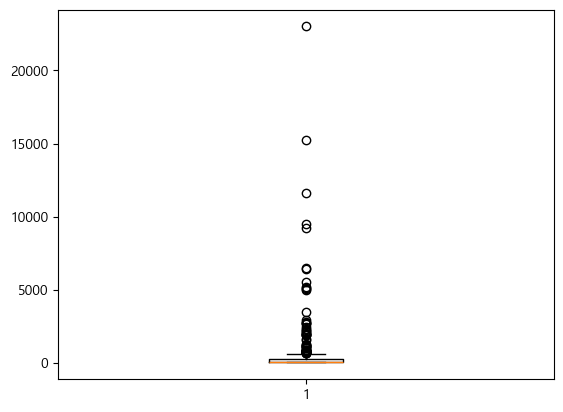

In [ ]:
plt.boxplot(tour_df['Participants'])
# min과 max의 격차가 너무 심함

Participants 기준 upper 이상치 데이터 / 사분위수 내 데이터 / lower 이상치 3개의 그룹으로 그룹화

In [ ]:
tour_df.describe()

만족도           매력도            편의  Participants   Longitude  \
count   336.000000    336.000000    336.000000    336.000000  336.000000   
mean    335.154762    743.196429    526.241071    600.196429  126.993227   
std     855.015573   3588.258759   1623.524886   1968.139280    0.077525   
min       0.000000      0.000000      0.000000     10.000000  126.808552   
25%       5.750000     22.750000     18.000000     25.500000  126.956635   
50%      33.000000     67.500000     53.000000     70.500000  126.986403   
75%     143.500000    276.750000    186.250000    266.000000  127.036135   
max    6388.000000  50037.000000  12165.000000  23013.000000  127.608918   

         Latitude  
count  336.000000  
mean    37.553745  
std      0.042774  
min     37.426940  
25%     37.523378  
50%     37.559517  
75%     37.573401  
max     37.783068

In [ ]:
# 조건 설정
condition_upper1 = tour_df['Participants'] > 266
condition_middle1 = (tour_df['Participants'] <= 266) & (tour_df['Participants'] >= 25.5)
condition_lower1 = tour_df['Participants'] < 25.5

In [ ]:
# upper 이상치
tour_df_upper = tour_df[condition_upper1]
tour_df_upper.shape

(83, 9)

In [ ]:
# middle 중간
tour_df_middle = tour_df[condition_middle1]
tour_df_middle.shape

(169, 9)

In [ ]:
# lower 이상치
tour_df_lower = tour_df[condition_lower1]
tour_df_lower.shape

(84, 9)

- upper >> 83개
- middle >> 169개
- lower >> 84개

In [ ]:
# 분배 개수 확인
print(len(tour_df))
print(len(tour_df_upper) + len(tour_df_middle) + len(tour_df_lower))

336
336


각 그룹별 boxplot 시각화

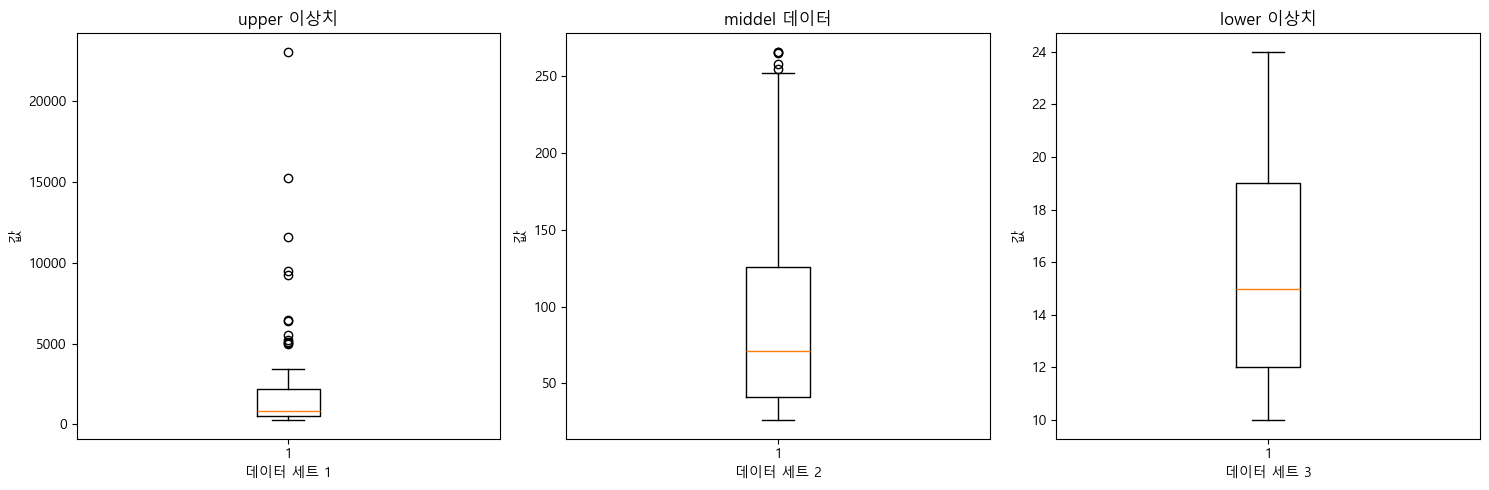

In [ ]:
# 서브플롯 생성 (1행 3열)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# 각 서브플롯에 박스플롯 그리기
axes[0].boxplot(tour_df_upper['Participants'])
axes[0].set_title('upper 이상치')
axes[0].set_xlabel('데이터 세트 1')
axes[0].set_ylabel('값')

axes[1].boxplot(tour_df_middle['Participants'])
axes[1].set_title('middel 데이터')
axes[1].set_xlabel('데이터 세트 2')
axes[1].set_ylabel('값')

axes[2].boxplot(tour_df_lower['Participants'])
axes[2].set_title('lower 이상치')
axes[2].set_xlabel('데이터 세트 3')
axes[2].set_ylabel('값')

# 서브플롯 간 간격 조정
plt.tight_layout()

# 그래프 표시
plt.show()


- upper 이상치를 제외하고는 이상치 처리가 잘 된것 같다
- upper 이상치는 여전히 격차가 심해서 이상치가 많이 존재함 >> upper만 로그 정규화 적용 시도 해볼 필요있음

Category '음식' 시도

{'whiskers': [<matplotlib.lines.Line2D at 0x1c30a061b40>,
 'caps': [<matplotlib.lines.Line2D at 0x1c30a062080>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c30a0618a0>],
 'medians': [<matplotlib.lines.Line2D at 0x1c30a0625c0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c30a062860>],
 'means': []}

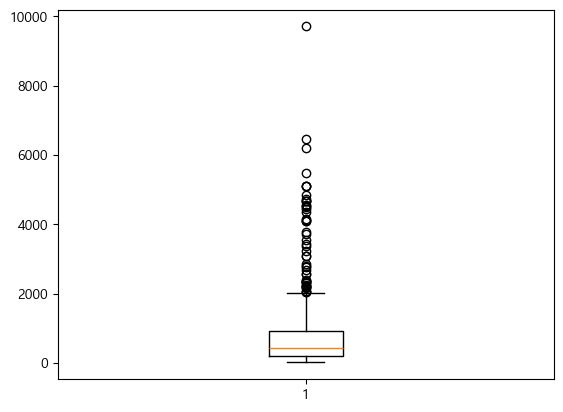

In [ ]:
plt.boxplot(food_df['Participants'])

In [ ]:
food_df.describe()

가격 및 가치          서비스      시설 및 분위기        음식의 속성  Participants  \
count   449.000000   449.000000    449.000000    449.000000    449.000000   
mean    143.102450   228.438753    724.026726   1271.122494    850.988864   
std     271.191803   286.814013   1242.363854   1807.458753   1183.385659   
min       0.000000     2.000000      6.000000     10.000000     10.000000   
25%      23.000000    62.000000    122.000000    258.000000    194.000000   
50%      50.000000   137.000000    310.000000    631.000000    421.000000   
75%     138.000000   263.000000    790.000000   1379.000000    931.000000   
max    2372.000000  1974.000000  10410.000000  15718.000000   9707.000000   

        Longitude    Latitude  
count  449.000000  449.000000  
mean   126.995284   37.542112  
std      0.063912    0.166011  
min    126.723459   35.147194  
25%    126.974513   37.525021  
50%    126.988095   37.562117  
75%    127.023578   37.573820  
max    127.578285   37.687810

In [ ]:
# 조건 설정
condition_upper2 = (food_df['Participants'] > 931)
condition_middle2 = (food_df['Participants'] <= 931) & (food_df['Participants'] >= 194)
condition_lower2 = (food_df['Participants'] < 194)

In [ ]:
# upper 이상치
food_df_upper = food_df[condition_upper2]
food_df_upper.shape

(112, 10)

In [ ]:
# middle 중간
food_df_middle = food_df[condition_middle2]
food_df_middle.shape

(225, 10)

In [ ]:
# lower 이상치
food_df_lower = food_df[condition_lower2]
food_df_lower.shape

(112, 10)

In [ ]:
print(len(food_df))
print(len(food_df_upper) + len(food_df_middle) + len(food_df_lower))

449
449


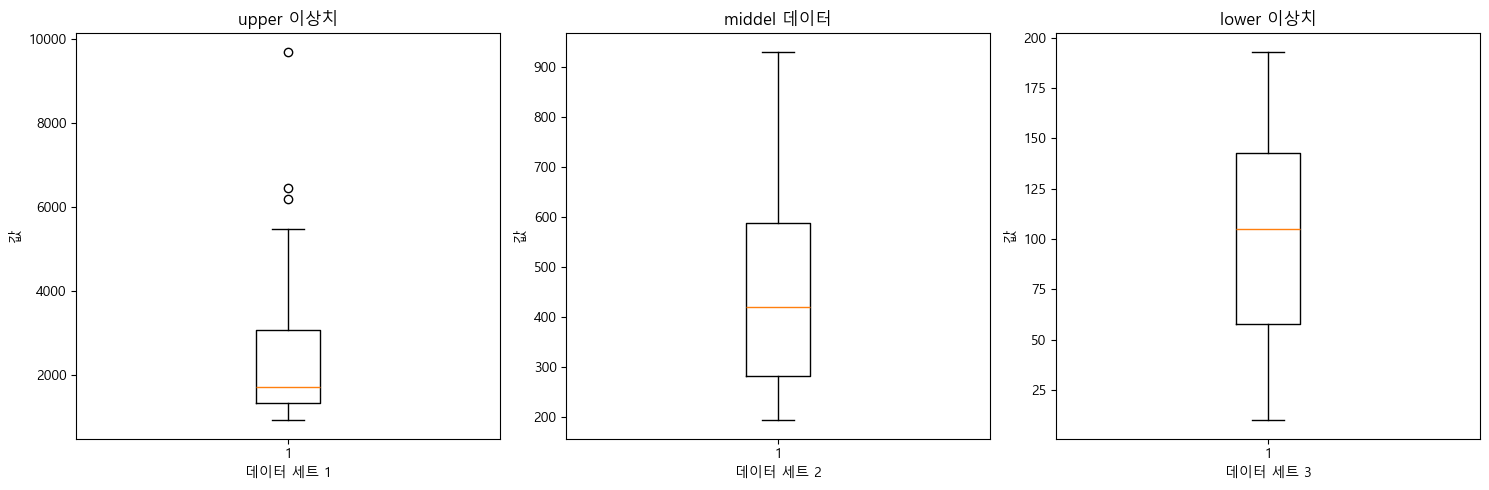

In [ ]:
# 서브플롯 생성 (1행 3열)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# 각 서브플롯에 박스플롯 그리기
axes[0].boxplot(food_df_upper['Participants'])
axes[0].set_title('upper 이상치')
axes[0].set_xlabel('데이터 세트 1')
axes[0].set_ylabel('값')

axes[1].boxplot(food_df_middle['Participants'])
axes[1].set_title('middel 데이터')
axes[1].set_xlabel('데이터 세트 2')
axes[1].set_ylabel('값')

axes[2].boxplot(food_df_lower['Participants'])
axes[2].set_title('lower 이상치')
axes[2].set_xlabel('데이터 세트 3')
axes[2].set_ylabel('값')

# 서브플롯 간 간격 조정
plt.tight_layout()

# 그래프 표시
plt.show()

관광 카테고리보다 비교적 잘 나눠짐

---

## 2. 군집분석
- 군집분석을 통한 그룹화 시도
- 군집 분석으로 군집화한 뒤 각 군집별 공통 속성을 찾아내는 시도
- 군집화 기준 -> 네이버 리뷰 '이런 점이 좋았어요'의 수치
    - 관광 : 편의, 매력도, 만족도
    - 음식 : 가격 및 가치, 서비스, 시설 및 분위기, 음식의 속성

Category '관광' 시도

In [ ]:
tour_df_cluster = tour_df[['Attraction','만족도', '매력도', '편의']]
tour_df_cluster[:5]

Attraction     만족도    매력도      편의
0     104고지전적비    63.0  228.0    72.0
1  10꼬르소꼬모 청담점    68.0   55.0    66.0
2         63아트    82.0  275.0   156.0
3  AK PLAZA 홍대   575.0  303.0   471.0
4         IFC몰  1608.0  513.0  1854.0

In [ ]:
tour_df_cluster.describe()

만족도           매력도            편의
count   336.000000    336.000000    336.000000
mean    335.154762    743.196429    526.241071
std     855.015573   3588.258759   1623.524886
min       0.000000      0.000000      0.000000
25%       5.750000     22.750000     18.000000
50%      33.000000     67.500000     53.000000
75%     143.500000    276.750000    186.250000
max    6388.000000  50037.000000  12165.000000

각 속성별 분산이 큼 >> 비교를 위해 정규화 시도
- 로그 정규화 채택(StandardScaler, Min-Max >> 최소와 최대간의 격차가 심할때 왜곡이 일어날 수 있어서 탈락)
    - 데이터가 모두 양수이고 관광지간의 상대적 비교만 일어나면 되기 때문에 로그 정규화 채택

In [ ]:
import numpy as np
tour_df_cluster['만족도_log'] = np.log1p(tour_df_cluster['만족도'])
tour_df_cluster['매력도_log'] = np.log1p(tour_df_cluster['매력도'])
tour_df_cluster['편의_log'] = np.log1p(tour_df_cluster['편의'])
tour_df_cluster

Attraction     만족도    매력도      편의   만족도_log   매력도_log    편의_log
0       104고지전적비    63.0  228.0    72.0  4.158883  5.433722  4.290459
1    10꼬르소꼬모 청담점    68.0   55.0    66.0  4.234107  4.025352  4.204693
2           63아트    82.0  275.0   156.0  4.418841  5.620401  5.056246
3    AK PLAZA 홍대   575.0  303.0   471.0  6.356108  5.717028  6.156979
4           IFC몰  1608.0  513.0  1854.0  7.383368  6.242223  7.525640
..           ...     ...    ...     ...       ...       ...       ...
331        홍난파가옥     2.0   22.0     9.0  1.098612  3.135494  2.302585
332       화곡본동시장     7.0   11.0     8.0  2.079442  2.484907  2.197225
333     화랑대 철도공원     4.0   92.0    60.0  1.609438  4.532599  4.110874
334          황궁우     1.0   35.0    14.0  0.693147  3.583519  2.708050
335         흥인지문     2.0   75.0    37.0  1.098612  4.330733  3.637586

[336 rows x 7 columns]

시각화

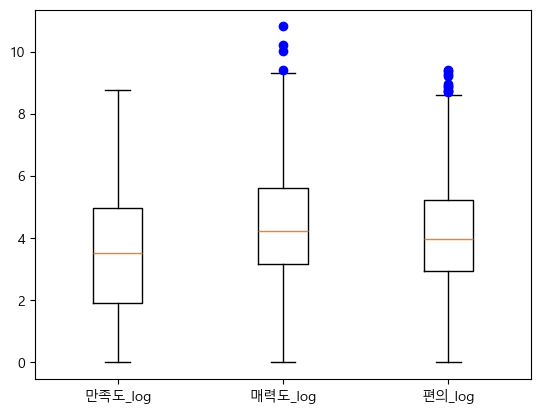

In [ ]:
import matplotlib.pyplot as plt

# fig, ax = plt.subplots()  # 이 부분은 필요 없습니다.
# ax.boxplot()  # 이 부분도 필요 없습니다.

fig, ax = plt.subplots()

# 로그 변환된 데이터 배열을 박스 플롯에 전달합니다.
ax.boxplot([tour_df_cluster['만족도_log'], tour_df_cluster['매력도_log'], tour_df_cluster['편의_log']], sym='bo')

# x축 레이블 설정
plt.xticks([1, 2, 3], ['만족도_log', '매력도_log', '편의_log'])

# 플롯 표시
plt.show()

로그 변환된 수치데이터를 기준으로 군집 분석 시도

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

x_features = tour_df_cluster[['만족도_log', '매력도_log', '편의_log']].values

적절한 클러스터 개수를 찾기 위해 Elbow 기법 활용

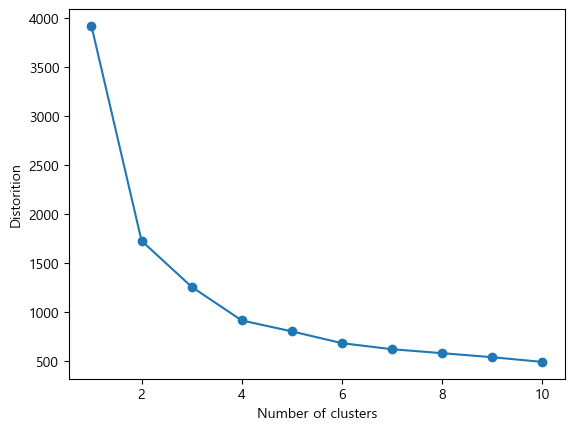

In [ ]:
# from sklearn.preprocessing import StandardScaler

# sc = StandardScaler()

# x_features_sc = sc.fit_transform(x_features)
# 로그 정규화된 값을 굳이 또 표준정규화 시켜줄 필요있을까??

# Elbow

distortions = []

for i in range(1,11):
    kmeans_i = KMeans(n_clusters = i, random_state=42) #모델 생성
    kmeans_i.fit(x_features) #모델 훈련(비지도학습 (라벨 x))
    distortions.append(kmeans_i.inertia_)

plt.plot(range(1,11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distorition')

plt.show()

그래프가 급격히 감소하다 완만해지는 구간인 3~4 구간을 클러스터 개수로 지정하여 진행

3과 4의 실루엣 점수를 보고 최적의 군집 개수 지정

In [ ]:

# 실루엣 점수 구하는 함수 정의
from matplotlib import cm
def silhouetteviz(n_cluster, x_features):
    kmeans = KMeans(n_clusters=n_cluster, random_state=42)
    y_labels = kmeans.fit_predict(x_features)
    silhouette_values = silhouette_samples(x_features, y_labels, metric='euclidean')

    # 초기화
    y_ax_lower, y_ax_upper = 0, 0
    y_ticks=[]

    for c in range(n_cluster):
        c_silhouette = silhouette_values[y_labels == c]
        c_silhouette.sort()
        y_ax_upper += len(c_silhouette)
        color = cm.jet(float(c)/n_cluster)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette,
                 height=1.0, edgecolor='none', color=color)
        y_ticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette)
    silhouetter_avg = np.mean(silhouette_values)
    # print(silhouetter_avg)

    # 그래프 꾸며주는 코드
    plt.axvline(silhouetter_avg, color='red', linestyle='--') # 실루엣 평균 점수 선 표시
    plt.title('Number of Cluster: '+str(n_cluster)+'\n'\
              + 'Silhouette_score: ' +str(round(silhouetter_avg, 3)))
    
    plt.yticks(y_ticks, range(n_cluster))
    plt.xticks([0,0.2,0.4,0.6,0.8,1.0])
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')
    plt.tight_layout()
    plt.show()

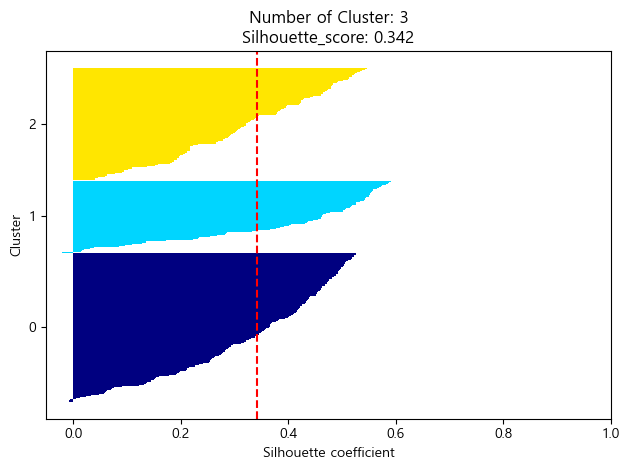

In [ ]:
silhouetteviz(3, x_features)

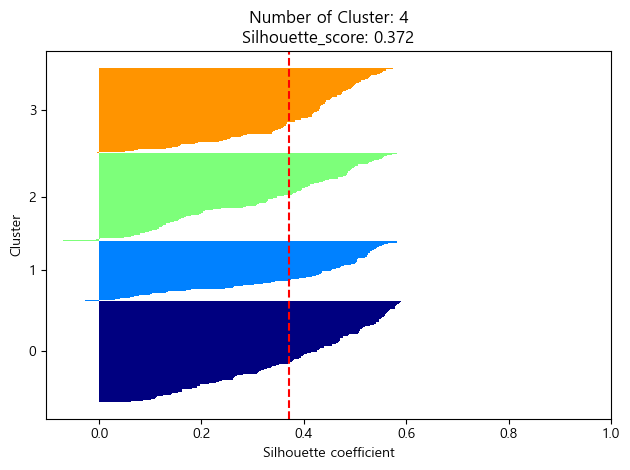

In [ ]:
silhouetteviz(4, x_features)

- 군집 개수 3일 때 실루엣 점수 : 0.342
- 군집 개수 4일 때 실루엣 점수 : 0.372
    - 군집 개수가 4개일때 실루엣점수가 더 높다

In [ ]:
# cluster 개수 4일때
kmeans = KMeans(n_clusters = 4 , random_state=42)

# 예측된 cluster 라벨링 해주기
y_labels = kmeans.fit_predict(x_features)
tour_df_cluster['cluster_label'] = y_labels

# 군집별 개수 확인
tour_df_cluster['cluster_label'].value_counts()

cluster_label
0    102
2     88
3     86
1     60
Name: count, dtype: int64

군집 분석 시각화

In [ ]:
# 군집 분석 후 시각화해주는 함수
def clusterScatter(n_cluster, x_features, att1, att2):
    c_colors = []
    kmeans = KMeans(n_clusters=n_cluster, random_state=42)
    y_labels = kmeans.fit_predict(x_features)

    for i in range(n_cluster):
        c_color = cm.jet(float(i)/n_cluster)
        c_colors.append(c_color)
        # 클러스터 색상 설정

        # cluster 내 데이터 분포를 표현, centroid 동그라미로 시각화
        plt.scatter(x_features[y_labels ==i, att1], x_features[y_labels ==i, att2],
                    marker ='o', color=c_color, edgecolor='black' , s=50,
                    label='cluster'+str(i)
                    )
        # 각 클러스터의 중심점(centroid) 별(*)로 표시
    for i in range(n_cluster):
        plt.scatter(kmeans.cluster_centers_[i,att1],kmeans.cluster_centers_[i,att2],
                    marker='*', color=c_colors[i], edgecolor='w', s=100)

    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

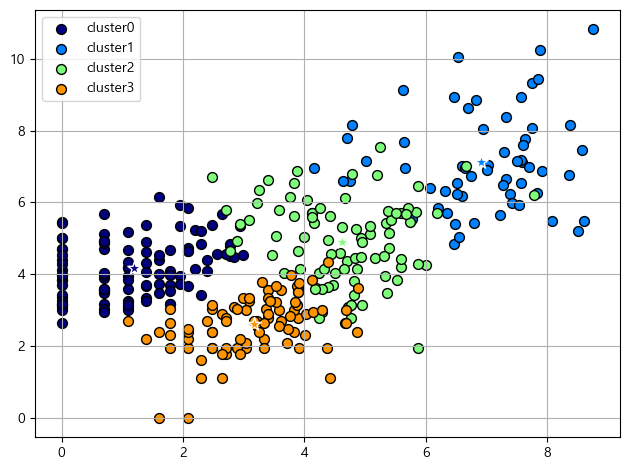

In [ ]:
clusterScatter(4, x_features, 0, 1) 

군집별 공통 속성 테이블 만들기

In [ ]:
tour_df_cluster

Attraction     만족도    매력도      편의   만족도_log   매력도_log    편의_log  \
0       104고지전적비    63.0  228.0    72.0  4.158883  5.433722  4.290459   
1    10꼬르소꼬모 청담점    68.0   55.0    66.0  4.234107  4.025352  4.204693   
2           63아트    82.0  275.0   156.0  4.418841  5.620401  5.056246   
3    AK PLAZA 홍대   575.0  303.0   471.0  6.356108  5.717028  6.156979   
4           IFC몰  1608.0  513.0  1854.0  7.383368  6.242223  7.525640   
..           ...     ...    ...     ...       ...       ...       ...   
331        홍난파가옥     2.0   22.0     9.0  1.098612  3.135494  2.302585   
332       화곡본동시장     7.0   11.0     8.0  2.079442  2.484907  2.197225   
333     화랑대 철도공원     4.0   92.0    60.0  1.609438  4.532599  4.110874   
334          황궁우     1.0   35.0    14.0  0.693147  3.583519  2.708050   
335         흥인지문     2.0   75.0    37.0  1.098612  4.330733  3.637586   

     cluster_label  
0                2  
1                2  
2                2  
3                1  
4                1  
..             ...  
331              0  
332              3  
333              0  
334              0  
335              0  

[336 rows x 8 columns]

In [ ]:
tour_df_cluster_group = tour_df_cluster.drop(['Attraction'], axis=1)

In [ ]:
tour_df_cluster_group.groupby('cluster_label').mean()

만족도          매력도           편의   만족도_log   매력도_log  \
cluster_label                                                              
0                 3.911765    89.568627    52.225490  1.201059  4.179037   
1              1582.266667  3626.833333  2589.400000  6.914055  7.121809   
2               164.920455   244.875000   169.022727  4.625972  4.912585   
3                32.139535    16.500000    14.558140  3.164971  2.609748   

                 편의_log  
cluster_label            
0              3.621335  
1              7.231497  
2              4.770319  
3              2.345857

Category '음식' 시도

In [ ]:
food_df[:5]

Attraction  가격 및 가치     서비스  시설 및 분위기  음식의 속성  Participants  \
0           1940금문      6.0    43.0      79.0   210.0           122   
1        63뷔페 파빌리온   2372.0  1974.0    7101.0  6137.0          4359   
2  BK볏짚 우대갈비 장안동본점     62.0   285.0     551.0   887.0           526   
3           RSG 성수      0.0     2.0      17.0    13.0            12   
4         WANGTHAI     31.0   173.0     342.0   567.0           324   

                                    Address  \
0               서울특별시 종로구 창경궁로 269-1 1940금문   
1             서울특별시 영등포구 63로 50 한화금융센터63,GF   
2  서울특별시 동대문구 장한로26가길 29 1층 BK볏짚 우대갈비 장안동본점   
3               서울특별시 성동구 연무장15길 11 C동 110호   
4                        서울특별시 용산구 이태원로 151   

                                                 Tag   Longitude   Latitude  
0  #1940금문#금문#대학로노포맛집#대학로자장면#맛있는녀석들시청자추천맛집#맛있는녀석들...  127.000610  37.585407  
1            #63빌딩#63빌딩파빌리온#맛집#뷔페식#송년모임#연말모임#음식#파빌리온  126.939587  37.519808  
2  #BK볏짚 우대갈비 장안동본점#동대문맛집#동대문맛집#비케이우대갈비#우대갈비맛집#음식...  127.071611  37.570591  
3           #RSG#RSG성수#라이더성지#라이더카페#라이딩편집숍#서울라이더성지#음식  127.059921  37.542477  
4                    #맛집#분위기_좋은#얌꿍#얌운센#음식#이국적인#팟타이가이  126.990646  37.534500

In [ ]:
food_df_cluster = food_df[['Attraction','가격 및 가치', '서비스', '시설 및 분위기', '음식의 속성']]
food_df_cluster[:5]

Attraction  가격 및 가치     서비스  시설 및 분위기  음식의 속성
0           1940금문      6.0    43.0      79.0   210.0
1        63뷔페 파빌리온   2372.0  1974.0    7101.0  6137.0
2  BK볏짚 우대갈비 장안동본점     62.0   285.0     551.0   887.0
3           RSG 성수      0.0     2.0      17.0    13.0
4         WANGTHAI     31.0   173.0     342.0   567.0

In [ ]:
food_df_cluster.describe()

가격 및 가치          서비스      시설 및 분위기        음식의 속성
count   449.000000   449.000000    449.000000    449.000000
mean    143.102450   228.438753    724.026726   1271.122494
std     271.191803   286.814013   1242.363854   1807.458753
min       0.000000     2.000000      6.000000     10.000000
25%      23.000000    62.000000    122.000000    258.000000
50%      50.000000   137.000000    310.000000    631.000000
75%     138.000000   263.000000    790.000000   1379.000000
max    2372.000000  1974.000000  10410.000000  15718.000000

In [ ]:
# 로그 정규화
food_df_cluster['가격 및 가치_log'] = np.log1p(food_df_cluster['가격 및 가치'])
food_df_cluster['서비스_log'] = np.log1p(food_df_cluster['서비스'])
food_df_cluster['시설 및 분위기_log'] = np.log1p(food_df_cluster['시설 및 분위기'])
food_df_cluster['음식의 속성_log'] = np.log1p(food_df_cluster['음식의 속성'])
food_df_cluster

Attraction  가격 및 가치     서비스  시설 및 분위기  음식의 속성  가격 및 가치_log  \
0             1940금문      6.0    43.0      79.0   210.0     1.945910   
1          63뷔페 파빌리온   2372.0  1974.0    7101.0  6137.0     7.771910   
2    BK볏짚 우대갈비 장안동본점     62.0   285.0     551.0   887.0     4.143135   
3             RSG 성수      0.0     2.0      17.0    13.0     0.000000   
4           WANGTHAI     31.0   173.0     342.0   567.0     3.465736   
..               ...      ...     ...       ...     ...          ...   
444             황금정원    172.0   254.0    1520.0  2009.0     5.153292   
445           황생가칼국수    323.0   921.0    1891.0  5523.0     5.780744   
446            황토추어탕    224.0   154.0     273.0   750.0     5.416100   
447             희락갈치    610.0   603.0     525.0  3215.0     6.415097   
448             히라메키     39.0    40.0      84.0   179.0     3.688879   

      서비스_log  시설 및 분위기_log  음식의 속성_log  
0    3.784190      4.382027    5.351858  
1    7.588324      8.868132    8.722254  
2    5.655992      6.313548    6.788972  
3    1.098612      2.890372    2.639057  
4    5.159055      5.837730    6.342121  
..        ...           ...         ...  
444  5.541264      7.327123    7.605890  
445  6.826545      7.545390    8.616858  
446  5.043425      5.613128    6.621406  
447  6.403574      6.265301    8.075894  
448  3.713572      4.442651    5.192957  

[449 rows x 9 columns]

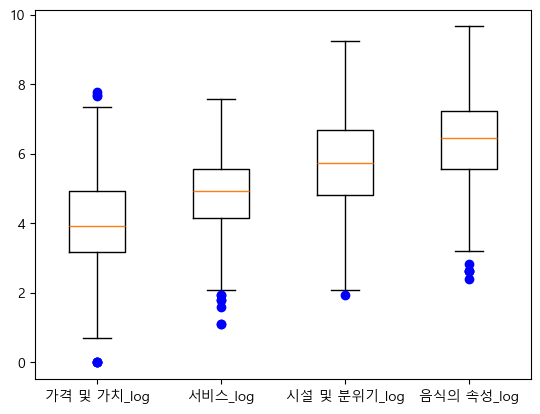

In [ ]:
fig, ax = plt.subplots()

# 로그 변환된 데이터 배열을 박스 플롯에 전달합니다.
ax.boxplot([food_df_cluster['가격 및 가치_log'], food_df_cluster['서비스_log'], food_df_cluster['시설 및 분위기_log'], food_df_cluster['음식의 속성_log']], sym='bo')

# x축 레이블 설정
plt.xticks([1, 2, 3, 4], ['가격 및 가치_log', '서비스_log', '시설 및 분위기_log', '음식의 속성_log'])

# 플롯 표시
plt.show()

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

x_features2 = food_df_cluster[['가격 및 가치_log', '서비스_log', '시설 및 분위기_log', '음식의 속성_log']].values

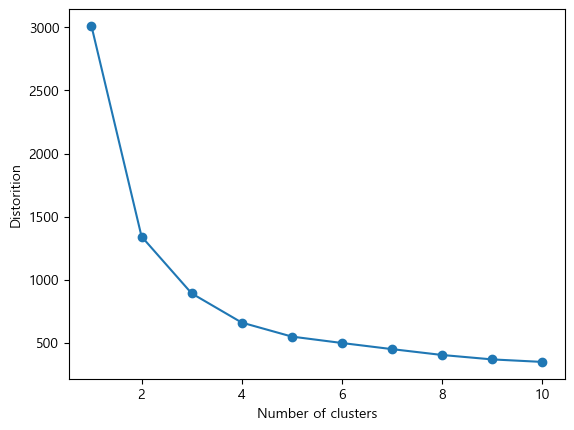

In [ ]:
# Elbow

distortions = []

for i in range(1,11):
    kmeans_i = KMeans(n_clusters = i, random_state=42) #모델 생성
    kmeans_i.fit(x_features2) #모델 훈련(비지도학습 (라벨 x))
    distortions.append(kmeans_i.inertia_)

plt.plot(range(1,11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distorition')

plt.show()

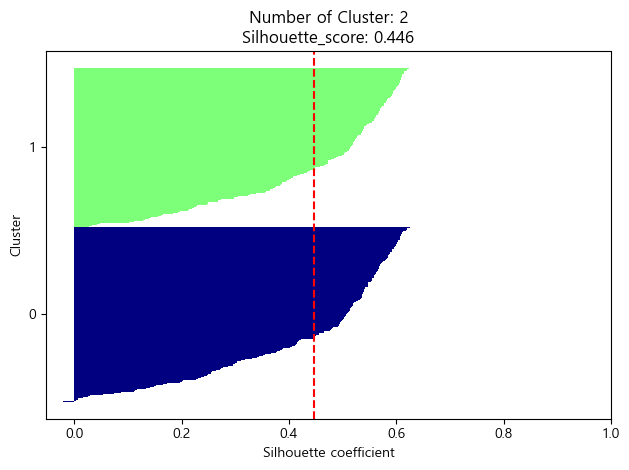

In [ ]:
silhouetteviz(2, x_features2)

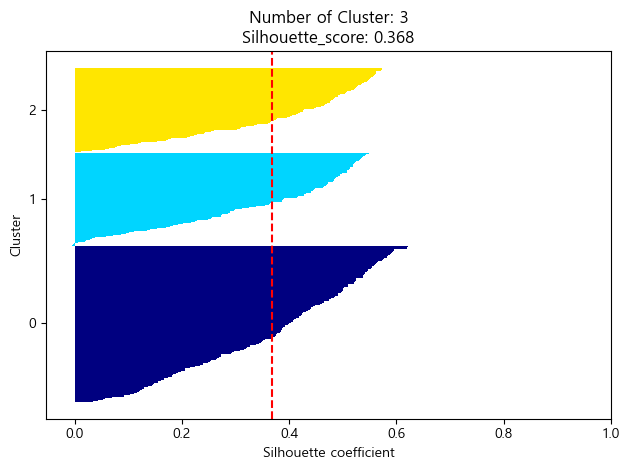

In [ ]:
silhouetteviz(3, x_features2)

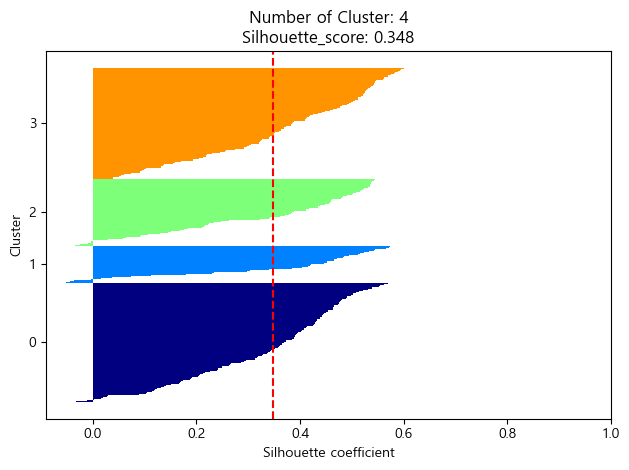

In [ ]:
silhouetteviz(4, x_features2)

- 군집 개수 2일 때 실루엣 점수 : 0.446
- 군집 개수 3일 때 실루엣 점수 : 0.368
- 군집 개수 4일 때 실루엣 점수 : 0.348
    - 군집 개수가 3개일때 실루엣점수가 더 높다

In [ ]:
# cluster 개수 3일때
kmeans = KMeans(n_clusters = 3 , random_state=42)

# 예측된 cluster 라벨링 해주기
y_labels = kmeans.fit_predict(x_features2)
food_df_cluster['cluster_label'] = y_labels

# 군집별 개수 확인
food_df_cluster['cluster_label'].value_counts()

cluster_label
0    210
1    124
2    115
Name: count, dtype: int64

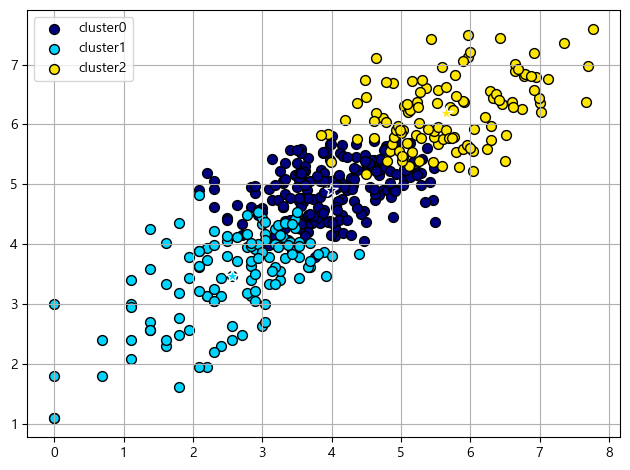

In [ ]:
clusterScatter(3, x_features2, 0 ,1)

In [ ]:
food_df_cluster

Attraction  가격 및 가치     서비스  시설 및 분위기  음식의 속성  가격 및 가치_log  \
0             1940금문      6.0    43.0      79.0   210.0     1.945910   
1          63뷔페 파빌리온   2372.0  1974.0    7101.0  6137.0     7.771910   
2    BK볏짚 우대갈비 장안동본점     62.0   285.0     551.0   887.0     4.143135   
3             RSG 성수      0.0     2.0      17.0    13.0     0.000000   
4           WANGTHAI     31.0   173.0     342.0   567.0     3.465736   
..               ...      ...     ...       ...     ...          ...   
444             황금정원    172.0   254.0    1520.0  2009.0     5.153292   
445           황생가칼국수    323.0   921.0    1891.0  5523.0     5.780744   
446            황토추어탕    224.0   154.0     273.0   750.0     5.416100   
447             희락갈치    610.0   603.0     525.0  3215.0     6.415097   
448             히라메키     39.0    40.0      84.0   179.0     3.688879   

      서비스_log  시설 및 분위기_log  음식의 속성_log  cluster_label  
0    3.784190      4.382027    5.351858              1  
1    7.588324      8.868132    8.722254              2  
2    5.655992      6.313548    6.788972              0  
3    1.098612      2.890372    2.639057              1  
4    5.159055      5.837730    6.342121              0  
..        ...           ...         ...            ...  
444  5.541264      7.327123    7.605890              2  
445  6.826545      7.545390    8.616858              2  
446  5.043425      5.613128    6.621406              0  
447  6.403574      6.265301    8.075894              2  
448  3.713572      4.442651    5.192957              1  

[449 rows x 10 columns]

In [ ]:
food_df_cluster_group = food_df_cluster.drop(['Attraction'], axis=1)

In [ ]:
food_df_cluster_group.groupby('cluster_label').mean()

가격 및 가치         서비스     시설 및 분위기       음식의 속성  가격 및 가치_log  \
cluster_label                                                                  
0               68.161905  148.347619   433.490476   714.771429     3.985037   
1               16.862903   39.225806    96.266129   160.298387     2.565947   
2              416.069565  578.713043  1931.460870  3484.826087     5.656638   

                서비스_log  시설 및 분위기_log  음식의 속성_log  
cluster_label                                      
0              4.912708      5.814293    6.450317  
1              3.468889      4.242756    4.845328  
2              6.189558      7.209238    7.959757

## 3. 텍스트 분석을 통한 관광지 분류
- 한국 관광 공사가 운영하는 구석구석 사이트의 관광지별 해시태그를 분석
- 카테고리(관광 / 음식) 별 세부 유형 지정 후 해시태그 토큰을 유형에 맞게 분류
    - 카테고리별 세부 유형 지정은 학술지, 관광 공사 분류 자료, 논문을 참고하여 지정
- 분류된 해시태그 토큰을 기준으로 관광지 유형 지정

In [ ]:
tour_df[:5]

Attraction     만족도    매력도      편의  Participants  \
0     104고지전적비    63.0  228.0    72.0           203   
1  10꼬르소꼬모 청담점    68.0   55.0    66.0            76   
2         63아트    82.0  275.0   156.0           252   
3  AK PLAZA 홍대   575.0  303.0   471.0           756   
4         IFC몰  1608.0  513.0  1854.0          1986   

                               Address  \
0                서울특별시 서대문구 연희동 산100-1   
1      서울특별시 강남구 압구정로 416 (청담동) 1층, 2층   
2                    서울특별시 영등포구 63로 50   
3                    서울특별시 마포구 양화로 188   
4  서울특별시 영등포구 여의도동 국제금융로 10 서울 국제금융 센터   

                                                 Tag   Longitude   Latitude  
0  #관광지#기념탑#역사#역사공부#역사관광지#역사를품은곳#역사문화재#역사속#역사속으로#...  126.926214  37.567794  
1  #10꼬르소꼬모#10꼬르소꼬모청담점#강남브런치카페#쇼핑#음식#청담동카페#청담동편집숍...  127.042493  37.527056  
2  #63빌딩전시관#63빌딩전시회#63스퀘어#63아트#경치좋은곳#문화공간#문화시설#문화...  126.940253  37.520002  
3             #2024_여행가는달과함께하는_발도장여행지#AK&홍대#쇼핑#홍대쇼핑몰  126.926095  37.558187  
4  #IFC몰#복합쇼핑몰#쇼핑#수도권#여의도대형쇼핑몰#여의도복합쇼핑몰#여의도쇼핑#여의도...  126.925583  37.524850

In [ ]:
food_df[:5]

Attraction  가격 및 가치     서비스  시설 및 분위기  음식의 속성  Participants  \
0           1940금문      6.0    43.0      79.0   210.0           122   
1        63뷔페 파빌리온   2372.0  1974.0    7101.0  6137.0          4359   
2  BK볏짚 우대갈비 장안동본점     62.0   285.0     551.0   887.0           526   
3           RSG 성수      0.0     2.0      17.0    13.0            12   
4         WANGTHAI     31.0   173.0     342.0   567.0           324   

                                    Address  \
0               서울특별시 종로구 창경궁로 269-1 1940금문   
1             서울특별시 영등포구 63로 50 한화금융센터63,GF   
2  서울특별시 동대문구 장한로26가길 29 1층 BK볏짚 우대갈비 장안동본점   
3               서울특별시 성동구 연무장15길 11 C동 110호   
4                        서울특별시 용산구 이태원로 151   

                                                 Tag   Longitude   Latitude  
0  #1940금문#금문#대학로노포맛집#대학로자장면#맛있는녀석들시청자추천맛집#맛있는녀석들...  127.000610  37.585407  
1            #63빌딩#63빌딩파빌리온#맛집#뷔페식#송년모임#연말모임#음식#파빌리온  126.939587  37.519808  
2  #BK볏짚 우대갈비 장안동본점#동대문맛집#동대문맛집#비케이우대갈비#우대갈비맛집#음식...  127.071611  37.570591  
3           #RSG#RSG성수#라이더성지#라이더카페#라이딩편집숍#서울라이더성지#음식  127.059921  37.542477  
4                    #맛집#분위기_좋은#얌꿍#얌운센#음식#이국적인#팟타이가이  126.990646  37.534500

### Tag 분석 과정
- 토큰화 : Tag 전처리 > '#' 기준 split 한 뒤 형태소 분석
- 정제
    - 형태소 추출 : 명사 단어만 추출 > KoNLPy 에서 제공하는 형태소 분석기 중 우리 프로젝트에 가장 적합한 형태소 분석기 채택할 예정(Komoran, Okt, Hannanum, Kkma)
    - 클리닝
        - 빈도수에 따라서 클리닝(모든 관광지에 등장하거나 한개 이하의 관광지에만 등장하는 단어 제거)
        - 같은 의미의 단어 클리닝(예 - 산책길, 산책로 >> 산책길로 통합)
- 불용어 처리 : 우리 프로젝트에서 활용 가능한 stopswords 유즈케이스 존재하지 않음 >> 우리 프로젝트에 맞는 stopswords 제작
    - 기준 : 정제된 단어 중 클리닝을 거쳤는데도 카테고리별 세부 유형의 속성을 나타낸다고 보기 힘든 단어는 불용어로 정의
- 분류 작업 : 위의 과정에서 살아남은 단어들로 카테고리별 세부 유형에 맞게 분류
- 관광지 유형 지정 : 분류된 단어를 기준으로 관광지별 유형 단어 카운트 진행 > 가장 많이 등장하는 유형을 해당 관광지의 유형으로 지정
- 유형 지정 검증 : 교차 검증(네이버 subclass를 기준으로 나눈 것과 교차 검증하여 일치율 확인)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import json
import re
import matplotlib

# 한글 품사 태깅을 위한 모듈
from konlpy.tag import Okt
from collections import Counter
from matplotlib import font_manager, rc
from wordcloud import WordCloud

plt.rcParams['font.family'] = 'NanumGothic'

In [ ]:
file2 = '../변수정리/csv파일/final_data_set_v3.csv'

In [ ]:
raw1 = pd.read_csv(file2, index_col=0)
df1 = raw1.copy()
df1.head(1)

Attraction Category     type Category_Map Category_Map_v2 Good_Point  \
0   104고지전적비       관광  history          매력도             분위기  사진이 잘 나와요   

   Selected_People  Selected_People_Ratio Participants                Address  \
0             91.0               0.250689          203  서울특별시 서대문구 연희동 산100-1   

                                                 Tag   Longitude   Latitude  \
0  #관광지#기념탑#역사#역사공부#역사관광지#역사를품은곳#역사문화재#역사속#역사속으로#...  126.926214  37.567794   

                                          Image Link  
0  https://dbscthumb-phinf.pstatic.net/2765_000_1...

In [ ]:
# 아직 분류 전 DF : 사용할 Tag만 사용
df_tag = df1[['Attraction', 'Category', 'Tag']].drop_duplicates().reset_index(drop=True)
print(df_tag.shape)
df_tag.head(2)

(785, 3)


Attraction Category                                                Tag
0     104고지전적비       관광  #관광지#기념탑#역사#역사공부#역사관광지#역사를품은곳#역사문화재#역사속#역사속으로#...
1  10꼬르소꼬모 청담점       관광  #10꼬르소꼬모#10꼬르소꼬모청담점#강남브런치카페#쇼핑#음식#청담동카페#청담동편집숍...

In [ ]:
df_tag['Category'].value_counts()

Category
음식    449
관광    336
Name: count, dtype: int64

In [ ]:
df_tag_tour = df_tag[df_tag['Category'] == '관광']
df_tag_food = df_tag[df_tag['Category'] == '음식']

In [ ]:
# 함수 만들기
def make_newTagCols(df, nlp):
    # tag 분리한거 담는 컬럼 만들기
    df[['newTag', 'newTag_list', 'tag_word_N']] = None
    # 모든 태그 모음집
    total = ''
    # 모든 태그의 명사 추출 모음집
    N_list = []

    # '#' 분리해서 컬럼에 담기
    for i, tag in enumerate(df.Tag):
        tag = tag.split('#')[1:]
        df['newTag_list'][i] = tag
    
        words = ''
        for t in tag:
            words = words + t + ' '
    
        total = total + words + ' '
        df['newTag'][i] = words

        # 명사 추출해서 또 새로운 컬럼에 담기
        newTag_N = list(set(nlp.nouns(words)))
        N_list.append(newTag_N)
        df['tag_word_N'][i] = newTag_N
        
    # '#'제거 해시태그 한 리스트에 모은 것 : total
    # total에서 명사 추출한 결과
    total_nouns = nlp.nouns(total)

    return df, total, N_list, total_nouns

In [ ]:
# 한글 단어 구분
nlp = Okt()

df_tag_tour, total_word, newTag_N_list, total_nouns = make_newTagCols(df_tag_tour, nlp)

In [ ]:
df_tag_tour.head(2)

Attraction Category                                                Tag  \
0     104고지전적비       관광  #관광지#기념탑#역사#역사공부#역사관광지#역사를품은곳#역사문화재#역사속#역사속으로#...   
1  10꼬르소꼬모 청담점       관광  #10꼬르소꼬모#10꼬르소꼬모청담점#강남브런치카페#쇼핑#음식#청담동카페#청담동편집숍...   

                                              newTag  \
0  관광지 기념탑 역사 역사공부 역사관광지 역사를품은곳 역사문화재 역사속 역사속으로 역...   
1  10꼬르소꼬모 10꼬르소꼬모청담점 강남브런치카페 쇼핑 음식 청담동카페 청담동편집숍 ...   

                                         newTag_list  \
0  [관광지, 기념탑, 역사, 역사공부, 역사관광지, 역사를품은곳, 역사문화재, 역사속...   
1  [10꼬르소꼬모, 10꼬르소꼬모청담점, 강남브런치카페, 쇼핑, 음식, 청담동카페, ...   

                                          tag_word_N  
0  [곳, 한국, 기념, 관광지, 문화재, 유적지, 해병대, 여행, 전쟁, 역사탐방, ...  
1  [편집, 브런치, 꼬르소꼬, 카페, 청담동, 꼬르소꼬모, 점, 강남, 청담, 숍, ...

In [ ]:
count = Counter(total_nouns)
count

Counter({'여행': 393,
         '역사': 281,
         '관광지': 182,
         '곳': 180,
         '휴식': 179,
         '서울': 159,
         '공원': 151,
         '시장': 145,
         '쇼핑': 141,
         '아이': 136,
         '문화': 120,
         '체험': 110,
         '가족': 108,
         '박물관': 103,
         '산책': 97,
         '친구': 96,
         '전통': 93,
         '연인': 92,
         '수도권': 78,
         '여행지': 77,
         '관광': 76,
         '공간': 74,
         '한국': 67,
         '데이트': 63,
         '도심': 62,
         '선': 60,
         '코스': 58,
         '자연': 58,
         '실내': 57,
         '힐링': 54,
         '시설': 53,
         '나들이': 53,
         '속': 49,
         '체험학습': 42,
         '여행가': 36,
         '는달': 36,
         '발도장': 36,
         '재래시장': 35,
         '한강': 33,
         '이색': 32,
         '교과서': 30,
         '유적지': 29,
         '남녀': 29,
         '노소': 29,
         '당일치기': 29,
         '투어': 28,
         '근교': 27,
         '야경': 25,
         '사계절': 25,
         '이야기': 24,
         '피크닉': 24,
 

In [ ]:
# 상위 빈출 단어 10개 구하는 코드
count.most_common(10)

[('여행', 393),
 ('역사', 281),
 ('관광지', 182),
 ('곳', 180),
 ('휴식', 179),
 ('서울', 159),
 ('공원', 151),
 ('시장', 145),
 ('쇼핑', 141),
 ('아이', 136)]

In [ ]:
word_count = dict()

# 빈출 단어 50위까지 word_count에 넣어주는 코드
for tag, counts in count.most_common(50):
    if (len(str(tag))>1):
        word_count[tag] = counts
        print(f'{tag} : {counts}')

여행 : 393
역사 : 281
관광지 : 182
휴식 : 179
서울 : 159
공원 : 151
시장 : 145
쇼핑 : 141
아이 : 136
문화 : 120
체험 : 110
가족 : 108
박물관 : 103
산책 : 97
친구 : 96
전통 : 93
연인 : 92
수도권 : 78
여행지 : 77
관광 : 76
공간 : 74
한국 : 67
데이트 : 63
도심 : 62
코스 : 58
자연 : 58
실내 : 57
힐링 : 54
시설 : 53
나들이 : 53
체험학습 : 42
여행가 : 36
는달 : 36
발도장 : 36
재래시장 : 35
한강 : 33
이색 : 32
교과서 : 30
유적지 : 29
남녀 : 29
노소 : 29
당일치기 : 29
투어 : 28
근교 : 27
야경 : 25
사계절 : 25
이야기 : 24


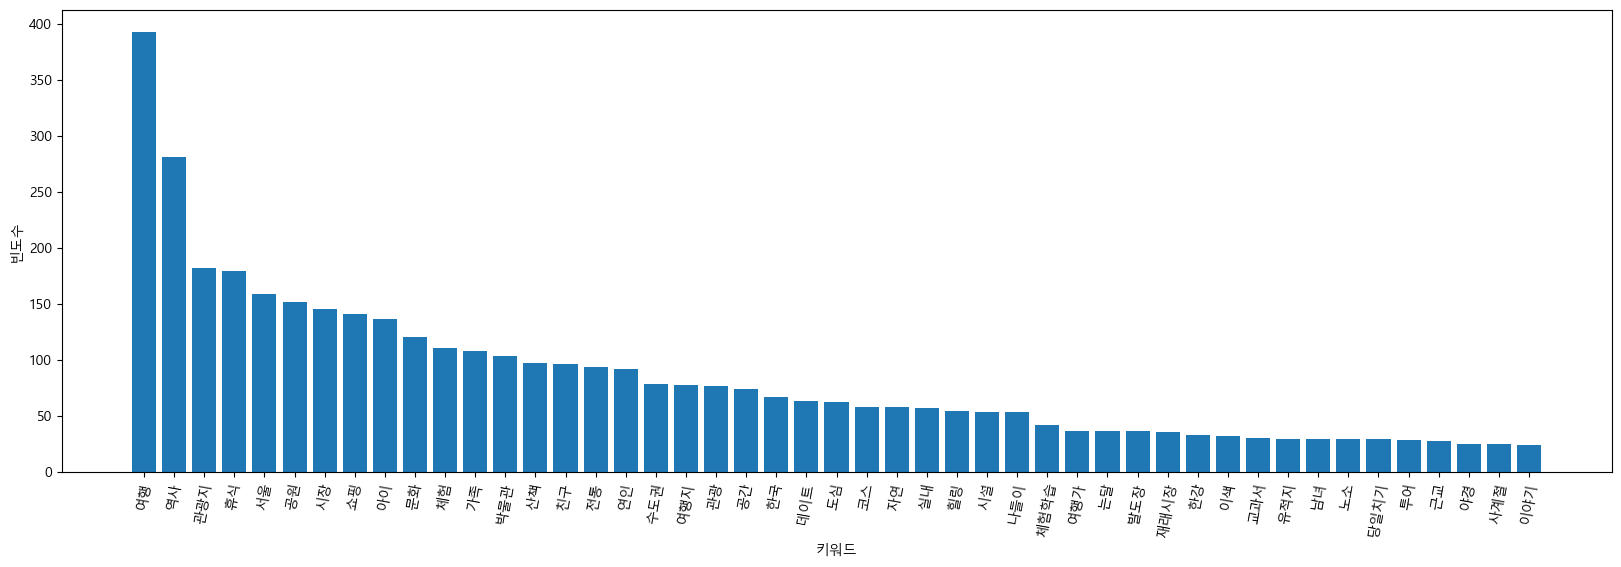

In [ ]:
font_path = "c:/Windows/fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname = font_path).get_name()
matplotlib.rc('font', family = font_name)

plt.figure(figsize = (20, 6))
plt.xlabel('키워드')
plt.ylabel('빈도수')
# plt.grid(True)

sorted_Keys = sorted(word_count, key = word_count.get, reverse = True)
sorted_Values = sorted(word_count.values(), reverse = True)

plt.bar(range(len(word_count)), sorted_Values, align = 'center')

plt.xticks(range(len(word_count)), list(sorted_Keys), rotation = 80)
plt.show()

# 군집분석 + PCA 
문제 
- 각 관광지에 댓글 사이의 편차가 매우 심함
- 가진 자료가 평점 기반이 아닌 댓글 수 기반임

해결 방안
1. 댓글 수 정렬
- 댓글 수가 많다고 그 관광지 내에서 그 속성에 대한 평점이 높다고 할 수 없음
2. 비율을 이용하여 각 관광지 내에서 속성의 비율을 평점으로 삼음.
- ex) 한 관광지가 100개의 댓글을 가지고 맛의 속성에 50개의 댓글을 가진다면 0.5
- 이 방법을 적용한다면 각 관광지 내의 속성을 고려할 수 있다는 판단

-> 위 두 문제를 해결하고자 댓글 수 정렬과 비율을 이용해서 정렬, 
두 방법을 웹구현에 적용함으로써 두 문제를 해결하고자 함.

문제점: 비율을 이용한 적용
- 댓글이 많은 관광지와 댓글이 적은 관광지 사이에 과대 또는 과소 평가 될 수 있음
- 이때 댓글 수를 기준으로 군집화함으로써, 3 군집으로 군집화하며 어느정도 왜곡을 해결
- (인기 관광지, 일반적인 관광지, 뜨지 않은 나만 알고 싶은 관광지)


In [ ]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm

import matplotlib
font_path = "c:/Windows/fonts/malgun.ttf"
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname = font_path).get_name()
plt.rc('font', family = font_name)
plt.rc('axes', unicode_minus=False)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings("ignore")
from matplotlib import cm

In [ ]:
info = pd.read_csv('final_data_set_v5.csv', index_col=0)
info[:2]

Attraction Category  class  type Category_Map Category_Map_v2 Good_Point  \
0        채그로       음식      2  cafe     시설 및 분위기         시설 및 환경     뷰가 좋아요   
1        채그로       음식      2  cafe     시설 및 분위기             분위기   집중하기 좋아요   

   Selected_People  Selected_People_sum  Selected_People_Ratio  Participants  \
0            146.0                579.0               0.252159           201   
1             62.0                579.0               0.107081           201   

                Address                                       Tag   Longitude  \
0  서울특별시 마포구 마포대로4다길 31  #독서#마포구가볼만한곳#복합문화시설#북카페#서울#쇼핑#채그로#책#힐링공간  126.944219   
1  서울특별시 마포구 마포대로4다길 31  #독서#마포구가볼만한곳#복합문화시설#북카페#서울#쇼핑#채그로#책#힐링공간  126.944219   

    Latitude                                         Image Link  \
0  37.535689  https://modo-phinf.pstatic.net/20220808_69/165...   
1  37.535689  https://modo-phinf.pstatic.net/20220808_69/165...   

                            info  
0  책과 사람이 만나는 독서 플랫폼, 당신의 인생서점.   
1  책과 사람이 만나는 독서 플랫폼, 당신의 인생서점.

In [ ]:
# 비율을 이용한 피봇 테이블 만들기 
def making_pivot_ratio(df):
    pivot_df = df.pivot_table(
        index='Attraction',
        columns='Category_Map',
        values='Selected_People_Ratio',
        aggfunc='sum',  
        fill_value=0
    )

    first_values = df.groupby('Attraction').first()[['Selected_People_sum','Participants', 'type']]
    pivot_df = pivot_df.reset_index().merge(first_values, on='Attraction', how='left')
    
    return pivot_df

In [ ]:
# 음식 
info_food = info[info['Category'] == '음식']
# 광광
info_tour = info[info['Category'] == '관광']

In [ ]:
pivot_food = making_pivot_ratio(info_food)
pivot_tour = making_pivot_ratio(info_tour)

selected_people : 투표에 참여한 인원

-> min - max의 편차가 크므로, 정규화 과정

이때, 이상치에 영향에 덜 민감한 로그 변환 사용

In [ ]:
# pivot_food의 Selected_People 로그 변환
selected_people = pivot_food['Selected_People_sum'].values
pivot_food['Selected_People_sum_log'] = np.log(selected_people)

# pivot_tour의 Selected_People 로그 변환
selected_people = pivot_tour['Selected_People_sum'].values
pivot_tour['Selected_People_sum_log'] = np.log(selected_people)

## 군집분석 + pca : food_part

In [ ]:
pivot_food

Attraction  가격 및 서비스  시설 및 분위기    음식의 속성  Selected_People_sum  \
0             1940금문  0.144970  0.233728  0.621302                338.0   
1          63뷔페 파빌리온  0.247157  0.403833  0.349010              17584.0   
2    BK볏짚 우대갈비 장안동본점  0.194398  0.308683  0.496919               1785.0   
3             RSG 성수  0.062500  0.531250  0.406250                 32.0   
4           WANGTHAI  0.183288  0.307278  0.509434               1113.0   
..               ...       ...       ...       ...                  ...   
444             황금정원  0.107712  0.384324  0.507965               3955.0   
445           황생가칼국수  0.143682  0.218411  0.637907               8658.0   
446            황토추어탕  0.269807  0.194861  0.535332               1401.0   
447             희락갈치  0.244902  0.105996  0.649102               4953.0   
448             히라메키  0.230994  0.245614  0.523392                342.0   

     Participants      type  Selected_People_sum_log  
0             122   chinese                 5.823046  
1            4359       etc                 9.774745  
2             526    korean                 7.487174  
3              12      cafe                 3.465736  
4             324       etc                 7.014814  
..            ...       ...                      ...  
444          1443    korean                 8.282736  
445          4157    korean                 9.066239  
446           456    korean                 7.244942  
447          2337    korean                 8.507749  
448           123  japanese                 5.834811  

[449 rows x 8 columns]

실루엣 점수 확인 
- n_cluster = 3 : 0.478

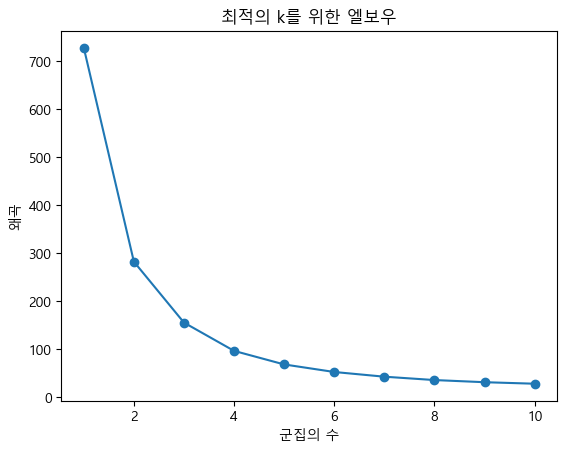

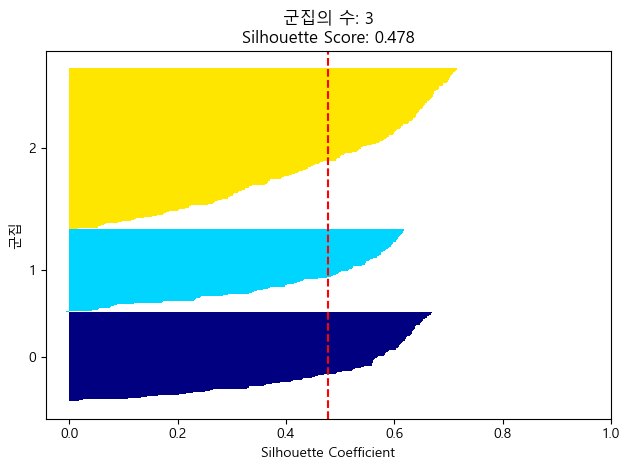

In [ ]:
# 최적의 군집 수 찾기 Elbow
x_features = pivot_food[['가격 및 서비스', '시설 및 분위기', '음식의 속성', 'Selected_People_sum_log']].values

# 군집 내 거리 왜곡(distortions)을 저장할 빈 리스트를 생성
distortions = []

for i in range(1,11):
    kmeans_i = KMeans(n_clusters = i, random_state=42)
    kmeans_i.fit(x_features)
    distortions.append(kmeans_i.inertia_)   
    # kmeans_i.inertia_는 해당 군집화의 왜곡을 반환
    
# 왜곡 그래프 그리기
plt.plot(range(1,11), distortions, marker = 'o')
plt.xlabel('군집의 수')
plt.ylabel('왜곡')
plt.title('최적의 k를 위한 엘보우')
plt.show()

# 실루엣 점수 구하는 함수 정의
def silhouetteviz(n_cluster, x_features):
    # 군집화 모델 생성 및 예측 K-평균 군집화 수행
    kmeans = KMeans(n_clusters=n_cluster, random_state=42)
    # y_labels: 데이터 포인트가 어느 군집에 속하는지를 나타내는 군집 레이블
    y_labels = kmeans.fit_predict(x_features)
    # 실루엣 점수 계산
    silhouette_values = silhouette_samples(x_features, y_labels, metric='euclidean')
    # metric='euclidean':실루엣 점수를 계산할 때 사용할 거리 측정 방법 유클리드 거리

    # 초기화
    y_ax_lower, y_ax_upper = 0, 0
    y_ticks = []

    for c in range(n_cluster):
        # 해당 군집의 실루엣 점수 추출 및 정렬
        c_silhouette = silhouette_values[y_labels==c]
        c_silhouette.sort()
        y_ax_upper += len(c_silhouette)
        color = cm.jet(float(c) / n_cluster)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette,
                 height=1.0, edgecolor='none', color=color)
        y_ticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette)
    silhouette_avg = np.mean(silhouette_values)

    # 그래프 꾸며주는 코드
    plt.axvline(silhouette_avg, color='red', linestyle='--')
    plt.title(f'군집의 수: {n_cluster}\nSilhouette Score: {round(silhouette_avg, 3)}')
    plt.yticks(y_ticks, range(n_cluster))
    plt.xticks(np.arange(0, 1.1, 0.2))
    plt.ylabel('군집')
    plt.xlabel('Silhouette Coefficient')
    plt.tight_layout()
    plt.show()

# 실루엣 시각화 예시
silhouetteviz(3, x_features)        
    
    

'가격 및 서비스', '시설 및 분위기', '음식의 속성', 'Selected_People_sum_log'

- 4개의 변수일 때, 군집의 속성을 잘 파악할 수 없음

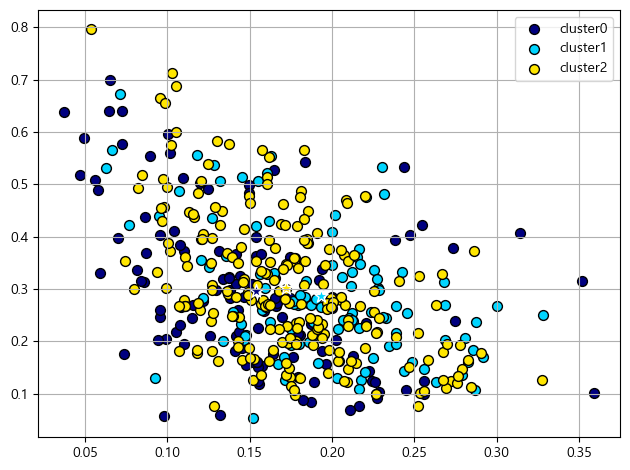

In [ ]:
x_features = pivot_food[['가격 및 서비스', '시설 및 분위기', '음식의 속성', 'Selected_People_sum_log']].values

# 군집 분석 후 시각화해주는 함수
def clusterScatter(n_cluster, x_featrues):
    c_colors = []
    kmeans = KMeans(n_clusters=n_cluster, random_state=42)
    # 군집을 라벨링하는 변수
    y_labels = kmeans.fit_predict(x_features)

    for i in range(n_cluster):
        c_color = cm.jet(float(i)/n_cluster)
        c_colors.append(c_color)
        # 클러스터 색상 설정

        # cluster 내 데이터 분포를 표현, centroid 동그라미로 시각화
        plt.scatter(x_features[y_labels ==i, 0], x_features[y_labels ==i, 1],
                    marker ='o', color=c_color, edgecolor='black' , s=50,
                    label='cluster'+str(i)
                    )
        # 각 클러스터의 중심점(centroid) 별(*)로 표시
    for i in range(n_cluster):
        plt.scatter(kmeans.cluster_centers_[i,0],kmeans.cluster_centers_[i,1],
                    marker='*', color=c_colors[i], edgecolor='w', s=100)

    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()
    
clusterScatter(3, x_features) 

두개의 속성과 Selected_People_sum_log의 그림으로 각 형성 군집 확인

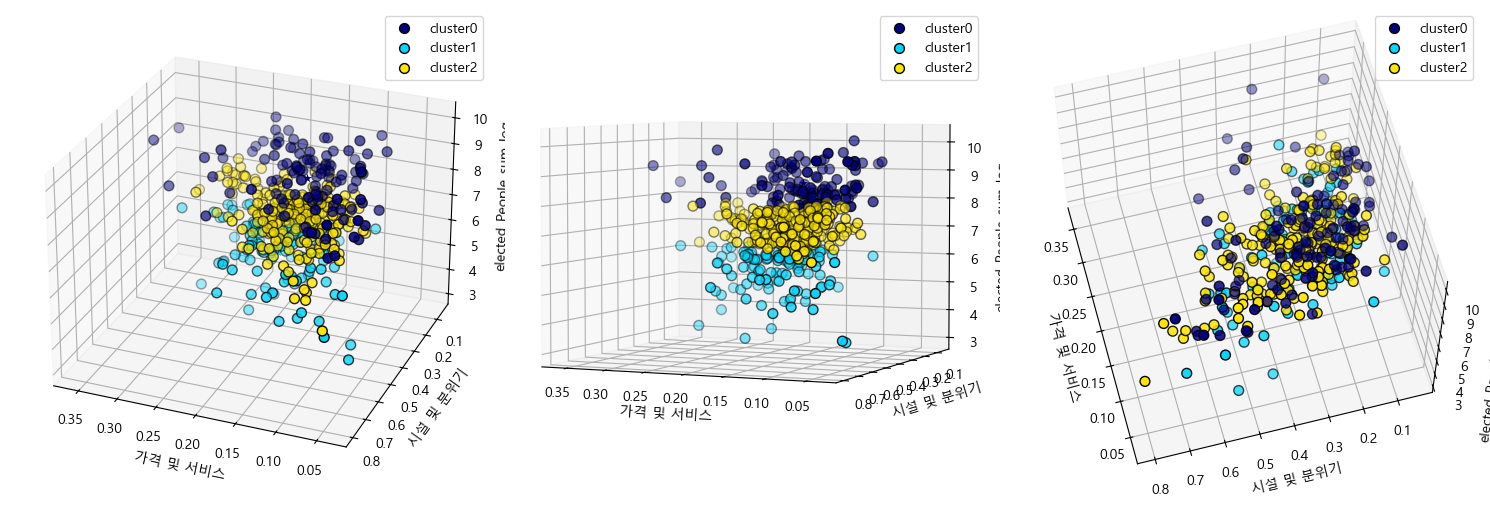

In [ ]:

x_features = pivot_food[['가격 및 서비스', '시설 및 분위기', 'Selected_People_sum_log']].values

# 군집 분석 후 시각화해주는 함수
def clusterScatter(n_cluster, x_features):
    c_colors = []
    kmeans = KMeans(n_clusters=n_cluster, random_state=42)
    y_labels = kmeans.fit_predict(x_features)

    fig = plt.figure(figsize=(15, 10))  # 3행 1열 형식의 서브플롯 생성

    for i in range(3):
        ax = fig.add_subplot(1, 3, i + 1, projection='3d')  # 서브플롯 추가
        for j in range(n_cluster):
            c_color = cm.jet(float(j) / n_cluster)
            c_colors.append(c_color)
            # 클러스터 색상 설정

            # cluster 내 데이터 분포를 표현, centroid 동그라미로 시각화
            ax.scatter(x_features[y_labels == j, 0], x_features[y_labels == j, 1], x_features[y_labels == j, 2],
                       marker='o', color=c_color, edgecolor='black', s=50, label='cluster' + str(j))
            # 각 클러스터의 중심점(centroid) 별(*)로 표시
            ax.scatter(kmeans.cluster_centers_[j, 0], kmeans.cluster_centers_[j, 1], kmeans.cluster_centers_[j, 2],
                       marker='*', color=c_colors[j], edgecolor='w', s=100)

        ax.set_xlabel('가격 및 서비스')
        ax.set_ylabel('시설 및 분위기')
        ax.set_zlabel('elected_People_sum_log')
        ax.legend()
        ax.grid()
        
        # 시각화 조정
        if i == 0:
            ax.view_init(elev=27, azim=112)
        elif i == 1:
            ax.view_init(elev=4, azim=114)
        elif i == 2:
            ax.view_init(elev=60, azim=165)

    plt.tight_layout()
    plt.show()

clusterScatter(3, x_features)

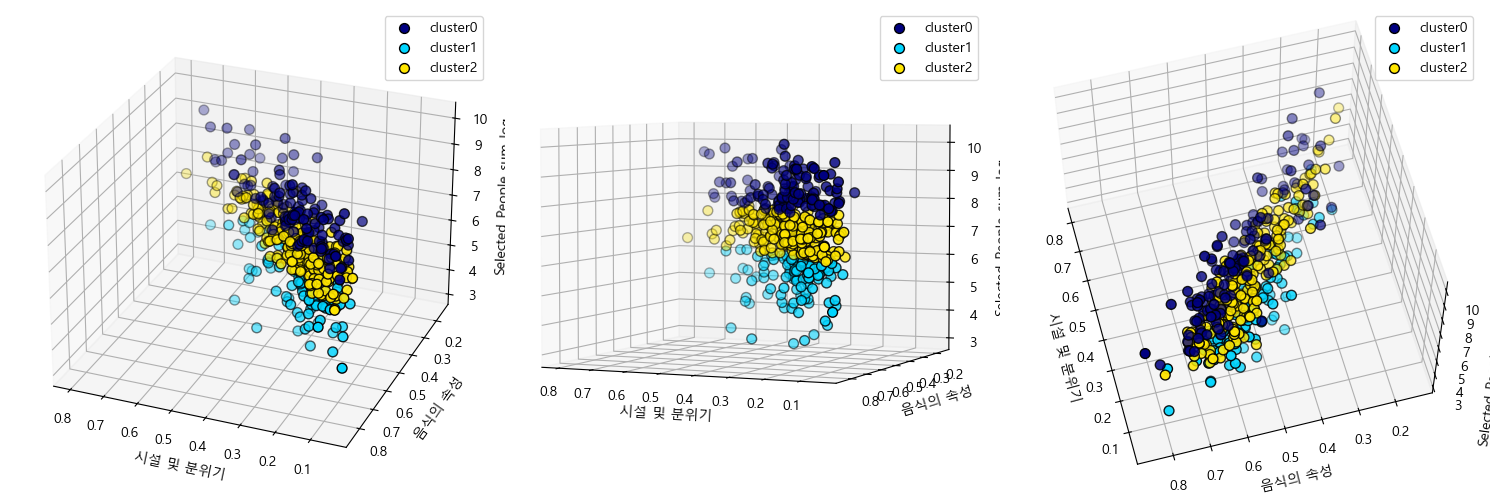

In [ ]:

x_features = pivot_food[['시설 및 분위기','음식의 속성', 'Selected_People_sum_log']].values

# 군집 분석 후 시각화해주는 함수
def clusterScatter(n_cluster, x_features):
    c_colors = []
    kmeans = KMeans(n_clusters=n_cluster, random_state=42)
    y_labels = kmeans.fit_predict(x_features)

    fig = plt.figure(figsize=(15, 10))  # 3행 1열 형식의 서브플롯 생성

    for i in range(3):
        ax = fig.add_subplot(1, 3, i + 1, projection='3d')  # 서브플롯 추가
        for j in range(n_cluster):
            c_color = cm.jet(float(j) / n_cluster)
            c_colors.append(c_color)
            # 클러스터 색상 설정

            # cluster 내 데이터 분포를 표현, centroid 동그라미로 시각화
            ax.scatter(x_features[y_labels == j, 0], x_features[y_labels == j, 1], x_features[y_labels == j, 2],
                       marker='o', color=c_color, edgecolor='black', s=50, label='cluster' + str(j))
            # 각 클러스터의 중심점(centroid) 별(*)로 표시
            ax.scatter(kmeans.cluster_centers_[j, 0], kmeans.cluster_centers_[j, 1], kmeans.cluster_centers_[j, 2],
                       marker='*', color=c_colors[j], edgecolor='w', s=100)

        ax.set_xlabel('시설 및 분위기')
        ax.set_ylabel('음식의 속성')
        ax.set_zlabel('Selected_People_sum_log')
        ax.legend()
        ax.grid()
        
        # 시각화 조정
        if i == 0:
            ax.view_init(elev=27, azim=112)
        elif i == 1:
            ax.view_init(elev=4, azim=114)
        elif i == 2:
            ax.view_init(elev=60, azim=165)

    plt.tight_layout()
    plt.show()

clusterScatter(3, x_features)

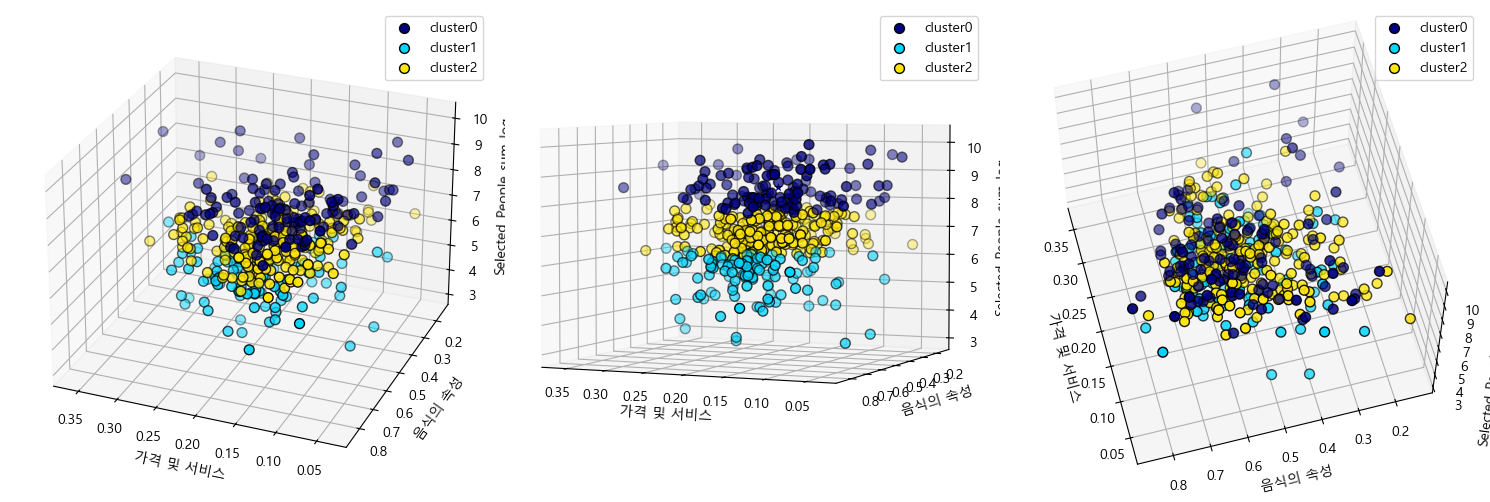

In [ ]:

x_features = pivot_food[['가격 및 서비스','음식의 속성', 'Selected_People_sum_log']].values

# 군집 분석 후 시각화해주는 함수
def clusterScatter(n_cluster, x_features):
    c_colors = []
    kmeans = KMeans(n_clusters=n_cluster, random_state=42)
    y_labels = kmeans.fit_predict(x_features)

    fig = plt.figure(figsize=(15, 10))  # 3행 1열 형식의 서브플롯 생성

    for i in range(3):
        ax = fig.add_subplot(1, 3, i + 1, projection='3d')  # 서브플롯 추가
        for j in range(n_cluster):
            c_color = cm.jet(float(j) / n_cluster)
            c_colors.append(c_color)
            # 클러스터 색상 설정

            # cluster 내 데이터 분포를 표현, centroid 동그라미로 시각화
            ax.scatter(x_features[y_labels == j, 0], x_features[y_labels == j, 1], x_features[y_labels == j, 2],
                       marker='o', color=c_color, edgecolor='black', s=50, label='cluster' + str(j))
            # 각 클러스터의 중심점(centroid) 별(*)로 표시
            ax.scatter(kmeans.cluster_centers_[j, 0], kmeans.cluster_centers_[j, 1], kmeans.cluster_centers_[j, 2],
                       marker='*', color=c_colors[j], edgecolor='w', s=100)

        ax.set_xlabel('가격 및 서비스')
        ax.set_ylabel('음식의 속성')
        ax.set_zlabel('Selected_People_sum_log')
        ax.legend()
        ax.grid()
        
        # 시각화 조정
        if i == 0:
            ax.view_init(elev=27, azim=112)
        elif i == 1:
            ax.view_init(elev=4, azim=114)
        elif i == 2:
            ax.view_init(elev=60, azim=165)

    plt.tight_layout()
    plt.show()

clusterScatter(3, x_features)

3차원 데이터까지 가능하다는 한계로,

각 두개씩 속성과 Selected_People_sum_log(총 투표수 로그변환) 군집화 실행

-> 3개의 속성을 PCA 분석 후, 군집분석 진행 실시

In [ ]:
from sklearn.decomposition import PCA

x_features = pivot_food[['가격 및 서비스', '음식의 속성', '시설 및 분위기']].values

# 컬럼 명 지정
features = ['가격 및 서비스', '음식의 속성', '시설 및 분위기']

# 주성분 개수 선택
pca = PCA(n_components=2)
printcipalComponents = pca.fit_transform(x_features)

# 주성분으로 이루어진 데이터 프레임 구성
principalDf = pd.DataFrame(data=printcipalComponents, 
              columns = ['pc1','pc2'])
principalDf

pc1       pc2
0   -0.104160 -0.047121
1    0.190716  0.115877
2    0.028193  0.030436
3    0.268016 -0.102375
4    0.020114  0.015714
..        ...       ...
444  0.086688 -0.069245
445 -0.126363 -0.051487
446 -0.090081  0.108724
447 -0.228473  0.060679
448 -0.040195  0.067055

[449 rows x 2 columns]

In [ ]:
pca_components = pca.components_
print('PCA Components:\n', pca_components)
# '가격 및 서비스', '음식의 속성', '시설 및 분위기'
# pc1
# pc1의 주성분은 시설 및 분위기의 변동을 주로 설명
# 음식의 속성, 가격 및 서비스는 그와 상반되는 요인

# pc2
# pc2의 주성분은 가격 및 서비스의 변동을 주로 설명
# 음식의 속성, 시설 및 분위기는 그와 상반되는 요인

PCA Components:
 [[-0.10130678 -0.65098947  0.75229625]
 [ 0.81018739 -0.49282794 -0.31735944]]


In [ ]:
# 주성분 기여율 확인
explained_variance = pca.explained_variance_ratio_
print('Explained variance ratio:', explained_variance)

# 첫 번째 주성분 (PC1)은 데이터의 주요 변동성을 설명하며, 
# 전체 변동성의 약 88.31%를 차지

# 두 번째 주성분 (PC2)은 추가적인 변동성을 설명하며,
# 전체 변동성의 약 11.68%를 차지


# 이 세가지의 요인은 '시설 및 분위기', '가격 및 가치'로 약 99% 이상 설명됨을 알 수 있음

Explained variance ratio: [0.88315805 0.11684195]


In [ ]:
pivot_food = pd.concat([pivot_food, principalDf], axis=1)

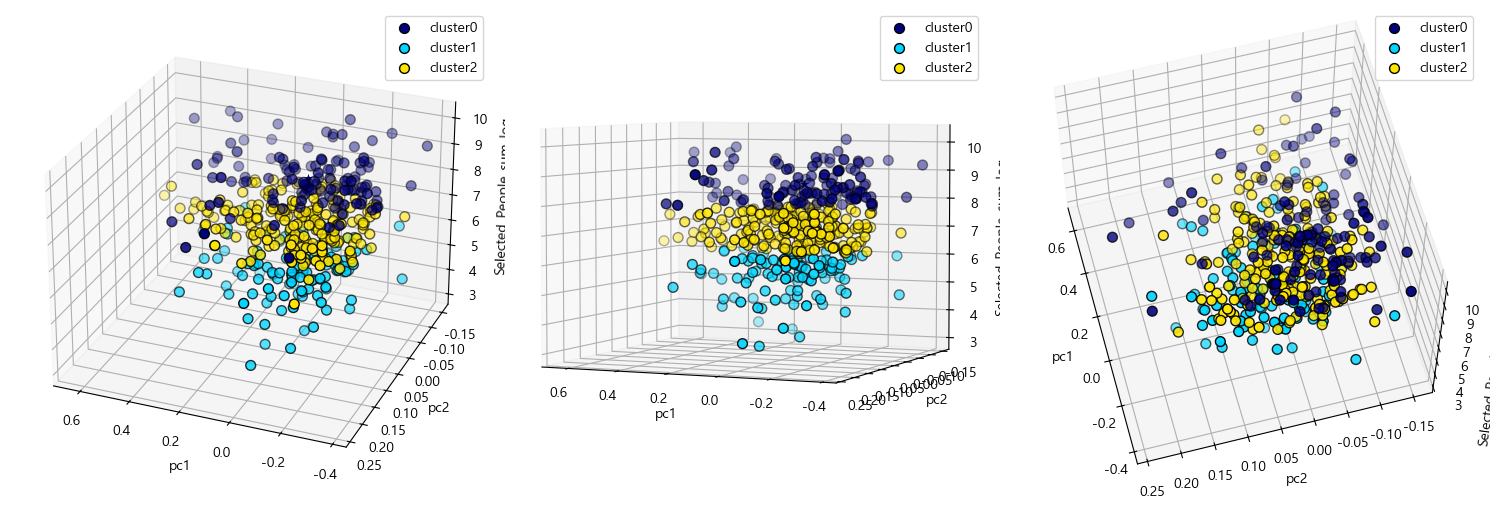

In [ ]:

x_features = pivot_food[['pc1','pc2', 'Selected_People_sum_log']].values

# 군집 분석 후 시각화해주는 함수
def clusterScatter(n_cluster, x_features):
    c_colors = []
    kmeans = KMeans(n_clusters=n_cluster, random_state=42)
    y_labels = kmeans.fit_predict(x_features)

    fig = plt.figure(figsize=(15,10))  # 3행 1열 형식의 서브플롯 생성

    for i in range(3):
        ax = fig.add_subplot(1, 3, i + 1, projection='3d')  # 서브플롯 추가
        for j in range(n_cluster):
            c_color = cm.jet(float(j) / n_cluster)
            c_colors.append(c_color)
            # 클러스터 색상 설정

            # cluster 내 데이터 분포를 표현, centroid 동그라미로 시각화
            ax.scatter(x_features[y_labels == j, 0], x_features[y_labels == j, 1], x_features[y_labels == j, 2],
                       marker='o', color=c_color, edgecolor='black', s=50, label='cluster' + str(j))
            # 각 클러스터의 중심점(centroid) 별(*)로 표시
            ax.scatter(kmeans.cluster_centers_[j, 0], kmeans.cluster_centers_[j, 1], kmeans.cluster_centers_[j, 2],
                       marker='*', color=c_colors[j], edgecolor='w', s=100)

        ax.set_xlabel('pc1')
        ax.set_ylabel('pc2')
        ax.set_zlabel('Selected_People_sum_log')
        ax.legend()
        ax.grid()
        
        # 시각화 조정
        if i == 0:
            ax.view_init(elev=27, azim=112)
        elif i == 1:
            ax.view_init(elev=4, azim=114)
        elif i == 2:
            ax.view_init(elev=60, azim=165)

    plt.tight_layout()
    plt.show()

clusterScatter(3, x_features)

-> 위의 군집을 '인기 관광지', '일반적인 관광지','비인기 관광지'로 군집 명을 칭함

## 군집분석 + pca : tour_part

In [ ]:
pivot_tour

Attraction       만족도       매력도        편의  Selected_People_sum  \
0       104고지전적비  0.173554  0.628099  0.198347                363.0   
1    10꼬르소꼬모 청담점  0.359788  0.291005  0.349206                189.0   
2           63아트  0.159844  0.536062  0.304094                513.0   
3    AK PLAZA 홍대  0.426242  0.224611  0.349148               1349.0   
4           IFC몰  0.404528  0.129057  0.466415               3975.0   
..           ...       ...       ...       ...                  ...   
331        홍난파가옥  0.060606  0.666667  0.272727                 33.0   
332       화곡본동시장  0.269231  0.423077  0.307692                 26.0   
333     화랑대 철도공원  0.025641  0.589744  0.384615                156.0   
334          황궁우  0.020000  0.700000  0.280000                 50.0   
335         흥인지문  0.017544  0.657895  0.324561                114.0   

     Participants      type  Selected_People_sum_log  
0             203   history                 5.894403  
1              76  shop_etc                 5.241747  
2             252   culture                 6.240276  
3             756  shop_etc                 7.207119  
4            1986  shop_etc                 8.287780  
..            ...       ...                      ...  
331            12   history                 3.496508  
332            13  shop_etc                 3.258097  
333            51     theme                 5.049856  
334            14   history                 3.912023  
335            46   history                 4.736198  

[336 rows x 8 columns]

실루엣 점수 확인 
- n_cluster = 3 : 0.478

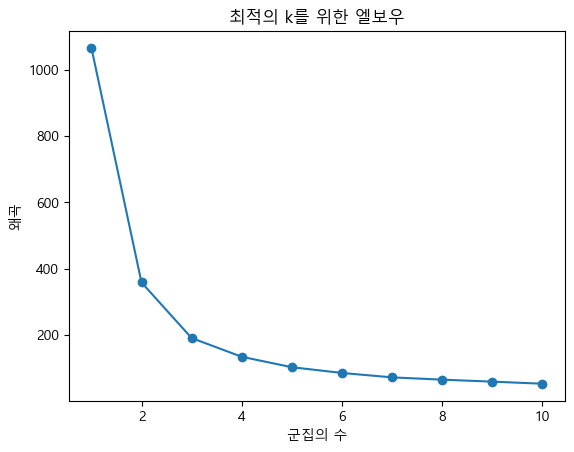

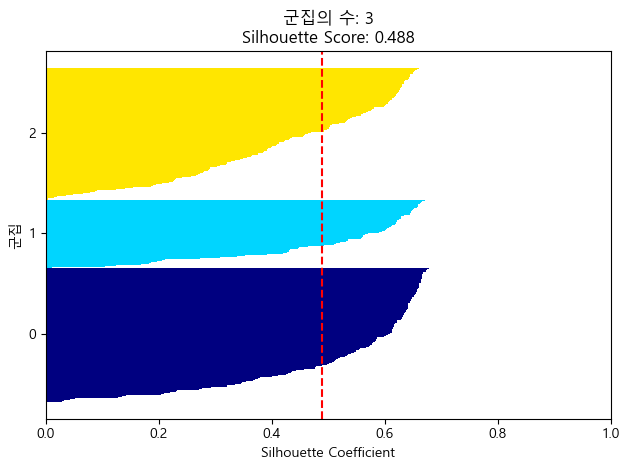

In [ ]:
# 최적의 군집 수 찾기 Elbow
x_features = pivot_tour[['만족도','매력도', '편의', 'Selected_People_sum_log']].values

# 군집 내 거리 왜곡(distortions)을 저장할 빈 리스트를 생성
distortions = []

for i in range(1,11):
    kmeans_i = KMeans(n_clusters = i, random_state=42)
    kmeans_i.fit(x_features)
    distortions.append(kmeans_i.inertia_)   
    # kmeans_i.inertia_는 해당 군집화의 왜곡을 반환
    
# 왜곡 그래프 그리기
plt.plot(range(1,11), distortions, marker = 'o')
plt.xlabel('군집의 수')
plt.ylabel('왜곡')
plt.title('최적의 k를 위한 엘보우')
plt.show()

# 실루엣 점수 구하는 함수 정의
def silhouetteviz(n_cluster, x_features):
    # 군집화 모델 생성 및 예측 K-평균 군집화 수행
    kmeans = KMeans(n_clusters=n_cluster, random_state=42)
    # y_labels: 데이터 포인트가 어느 군집에 속하는지를 나타내는 군집 레이블
    y_labels = kmeans.fit_predict(x_features)
    # 실루엣 점수 계산
    silhouette_values = silhouette_samples(x_features, y_labels, metric='euclidean')
    # metric='euclidean':실루엣 점수를 계산할 때 사용할 거리 측정 방법 유클리드 거리

    # 초기화
    y_ax_lower, y_ax_upper = 0, 0
    y_ticks = []

    for c in range(n_cluster):
        # 해당 군집의 실루엣 점수 추출 및 정렬
        c_silhouette = silhouette_values[y_labels==c]
        c_silhouette.sort()
        y_ax_upper += len(c_silhouette)
        color = cm.jet(float(c) / n_cluster)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette,
                 height=1.0, edgecolor='none', color=color)
        y_ticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette)
    silhouette_avg = np.mean(silhouette_values)

    # 그래프 꾸며주는 코드
    plt.axvline(silhouette_avg, color='red', linestyle='--')
    plt.title(f'군집의 수: {n_cluster}\nSilhouette Score: {round(silhouette_avg, 3)}')
    plt.yticks(y_ticks, range(n_cluster))
    plt.xticks(np.arange(0, 1.1, 0.2))
    plt.ylabel('군집')
    plt.xlabel('Silhouette Coefficient')
    plt.tight_layout()
    plt.show()

# 실루엣 시각화 예시
silhouetteviz(3, x_features)        
    
    

'만족도','매력도', '편의', 'Selected_People_sum_log'

- 4개의 변수일 때, 군집의 속성을 잘 파악할 수 없음

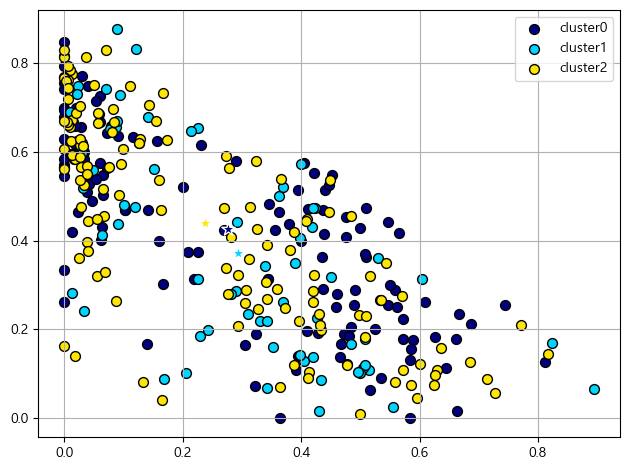

In [ ]:
x_features = pivot_tour[['만족도','매력도', '편의', 'Selected_People_sum_log']].values

# 군집 분석 후 시각화해주는 함수
def clusterScatter(n_cluster, x_featrues):
    c_colors = []
    kmeans = KMeans(n_clusters=n_cluster, random_state=42)
    # 군집을 라벨링하는 변수
    y_labels = kmeans.fit_predict(x_features)

    for i in range(n_cluster):
        c_color = cm.jet(float(i)/n_cluster)
        c_colors.append(c_color)
        # 클러스터 색상 설정

        # cluster 내 데이터 분포를 표현, centroid 동그라미로 시각화
        plt.scatter(x_features[y_labels ==i, 0], x_features[y_labels ==i, 1],
                    marker ='o', color=c_color, edgecolor='black' , s=50,
                    label='cluster'+str(i)
                    )
        # 각 클러스터의 중심점(centroid) 별(*)로 표시
    for i in range(n_cluster):
        plt.scatter(kmeans.cluster_centers_[i,0],kmeans.cluster_centers_[i,1],
                    marker='*', color=c_colors[i], edgecolor='w', s=100)

    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()
    
clusterScatter(3, x_features) 

두개의 속성과 Selected_People_sum_log의 그림으로 각 형성 군집 확인

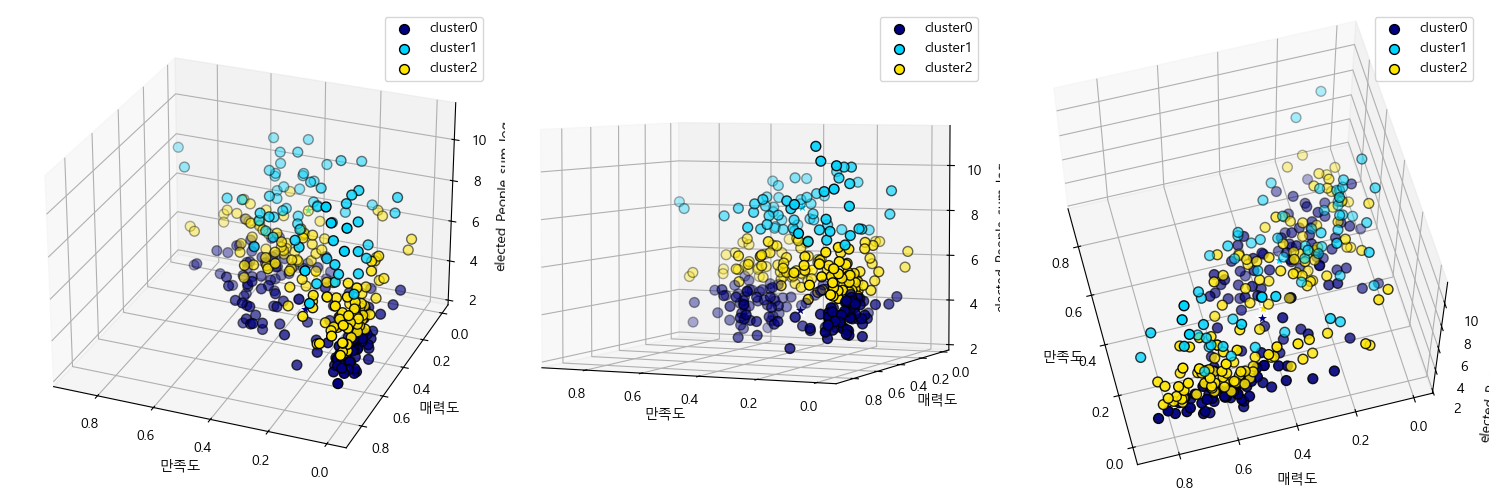

In [ ]:

x_features = pivot_tour[['만족도','매력도', 'Selected_People_sum_log']].values

# 군집 분석 후 시각화해주는 함수
def clusterScatter(n_cluster, x_features):
    c_colors = []
    kmeans = KMeans(n_clusters=n_cluster, random_state=42)
    y_labels = kmeans.fit_predict(x_features)

    fig = plt.figure(figsize=(15, 10))  # 3행 1열 형식의 서브플롯 생성

    for i in range(3):
        ax = fig.add_subplot(1, 3, i + 1, projection='3d')  # 서브플롯 추가
        for j in range(n_cluster):
            c_color = cm.jet(float(j) / n_cluster)
            c_colors.append(c_color)
            # 클러스터 색상 설정

            # cluster 내 데이터 분포를 표현, centroid 동그라미로 시각화
            ax.scatter(x_features[y_labels == j, 0], x_features[y_labels == j, 1], x_features[y_labels == j, 2],
                       marker='o', color=c_color, edgecolor='black', s=50, label='cluster' + str(j))
            # 각 클러스터의 중심점(centroid) 별(*)로 표시
            ax.scatter(kmeans.cluster_centers_[j, 0], kmeans.cluster_centers_[j, 1], kmeans.cluster_centers_[j, 2],
                       marker='*', color=c_colors[j], edgecolor='w', s=100)

        ax.set_xlabel('만족도')
        ax.set_ylabel('매력도')
        ax.set_zlabel('elected_People_sum_log')
        ax.legend()
        ax.grid()
        
        # 시각화 조정
        if i == 0:
            ax.view_init(elev=27, azim=112)
        elif i == 1:
            ax.view_init(elev=4, azim=114)
        elif i == 2:
            ax.view_init(elev=60, azim=165)

    plt.tight_layout()
    plt.show()

clusterScatter(3, x_features)

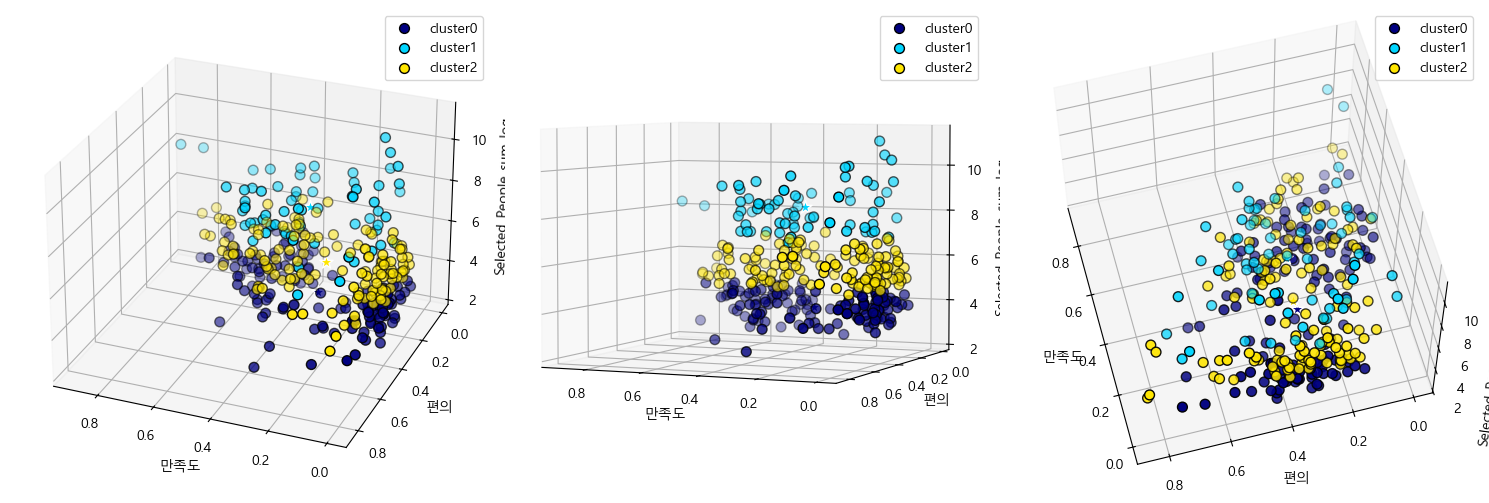

In [ ]:

x_features = pivot_tour[['만족도', '편의', 'Selected_People_sum_log']].values

# 군집 분석 후 시각화해주는 함수
def clusterScatter(n_cluster, x_features):
    c_colors = []
    kmeans = KMeans(n_clusters=n_cluster, random_state=42)
    y_labels = kmeans.fit_predict(x_features)

    fig = plt.figure(figsize=(15, 10))  # 3행 1열 형식의 서브플롯 생성

    for i in range(3):
        ax = fig.add_subplot(1, 3, i + 1, projection='3d')  # 서브플롯 추가
        for j in range(n_cluster):
            c_color = cm.jet(float(j) / n_cluster)
            c_colors.append(c_color)
            # 클러스터 색상 설정

            # cluster 내 데이터 분포를 표현, centroid 동그라미로 시각화
            ax.scatter(x_features[y_labels == j, 0], x_features[y_labels == j, 1], x_features[y_labels == j, 2],
                       marker='o', color=c_color, edgecolor='black', s=50, label='cluster' + str(j))
            # 각 클러스터의 중심점(centroid) 별(*)로 표시
            ax.scatter(kmeans.cluster_centers_[j, 0], kmeans.cluster_centers_[j, 1], kmeans.cluster_centers_[j, 2],
                       marker='*', color=c_colors[j], edgecolor='w', s=100)

        ax.set_xlabel('만족도')
        ax.set_ylabel('편의')
        ax.set_zlabel('Selected_People_sum_log')
        ax.legend()
        ax.grid()
        
        # 시각화 조정
        if i == 0:
            ax.view_init(elev=27, azim=112)
        elif i == 1:
            ax.view_init(elev=4, azim=114)
        elif i == 2:
            ax.view_init(elev=60, azim=165)

    plt.tight_layout()
    plt.show()

clusterScatter(3, x_features)

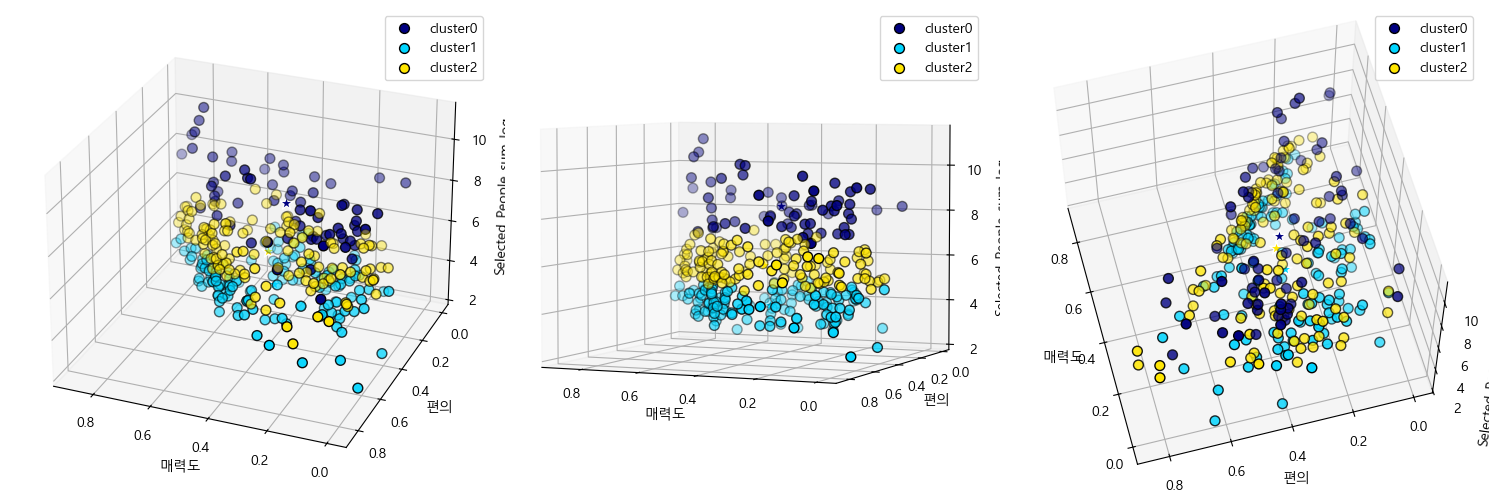

In [ ]:

x_features = pivot_tour[['매력도', '편의', 'Selected_People_sum_log']].values

# 군집 분석 후 시각화해주는 함수
def clusterScatter(n_cluster, x_features):
    c_colors = []
    kmeans = KMeans(n_clusters=n_cluster, random_state=42)
    y_labels = kmeans.fit_predict(x_features)

    fig = plt.figure(figsize=(15, 10))  # 3행 1열 형식의 서브플롯 생성

    for i in range(3):
        ax = fig.add_subplot(1, 3, i + 1, projection='3d')  # 서브플롯 추가
        for j in range(n_cluster):
            c_color = cm.jet(float(j) / n_cluster)
            c_colors.append(c_color)
            # 클러스터 색상 설정

            # cluster 내 데이터 분포를 표현, centroid 동그라미로 시각화
            ax.scatter(x_features[y_labels == j, 0], x_features[y_labels == j, 1], x_features[y_labels == j, 2],
                       marker='o', color=c_color, edgecolor='black', s=50, label='cluster' + str(j))
            # 각 클러스터의 중심점(centroid) 별(*)로 표시
            ax.scatter(kmeans.cluster_centers_[j, 0], kmeans.cluster_centers_[j, 1], kmeans.cluster_centers_[j, 2],
                       marker='*', color=c_colors[j], edgecolor='w', s=100)

        ax.set_xlabel('매력도')
        ax.set_ylabel('편의')
        ax.set_zlabel('Selected_People_sum_log')
        ax.legend()
        ax.grid()
        
        # 시각화 조정
        if i == 0:
            ax.view_init(elev=27, azim=112)
        elif i == 1:
            ax.view_init(elev=4, azim=114)
        elif i == 2:
            ax.view_init(elev=60, azim=165)

    plt.tight_layout()
    plt.show()

clusterScatter(3, x_features)

3차원 데이터까지 가능하다는 한계로,

각 두개씩 속성과 Selected_People_sum_log(총 투표수 로그변환) 군집화 실행

-> 3개의 속성을 PCA 분석 후, 군집분석 진행 실시

In [ ]:
from sklearn.decomposition import PCA

x_features = pivot_tour[['만족도','매력도', '편의']].values

# 컬럼 명 지정
features = ['만족도','매력도', '편의']

# 주성분 개수 선택
pca = PCA(n_components=2)
printcipalComponents = pca.fit_transform(x_features)

# 주성분으로 이루어진 데이터 프레임 구성
principalDf = pd.DataFrame(data=printcipalComponents, 
              columns = ['pc1','pc2'])
principalDf

pc1       pc2
0   -0.208604 -0.145844
1    0.158991  0.043755
2   -0.154921 -0.015617
3    0.252922  0.044914
4    0.303248  0.189209
..        ...       ...
331 -0.316926 -0.056159
332  0.002249 -0.009149
333 -0.289056  0.081252
334 -0.369322 -0.047938
335 -0.342003  0.007001

[336 rows x 2 columns]

In [ ]:
pca_components = pca.components_
print('PCA Components:\n', pca_components)
# '만족도','매력도', '편의'
# pc1
# pc1의 주성분은 '만족도'의 변동을 주로 설명
# '매력도', '편의'는 그와 상반되는 요인

# pc2
# pc2의 주성분은 '편의'의 변동을 주로 설명
# '만족도','매력도'는 그와 상반되는 요인

PCA Components:
 [[ 0.71239704 -0.70169504 -0.01070199]
 [-0.39894502 -0.41748142  0.81642644]]


In [ ]:
# 주성분 기여율 확인
explained_variance = pca.explained_variance_ratio_
print('Explained variance ratio:', explained_variance)

# 첫 번째 주성분 (PC1)은 데이터의 주요 변동성을 설명하며, 
# 전체 변동성의 약 69.06%를 차지

# 두 번째 주성분 (PC2)은 추가적인 변동성을 설명하며,
# 전체 변동성의 약 30.94%를 차지


# 이 세가지의 요인은 '만족도', '편의'로 약 99% 이상 설명됨을 알 수 있음

Explained variance ratio: [0.6906273 0.3093727]


In [ ]:
pivot_tour = pd.concat([pivot_tour, principalDf], axis=1)

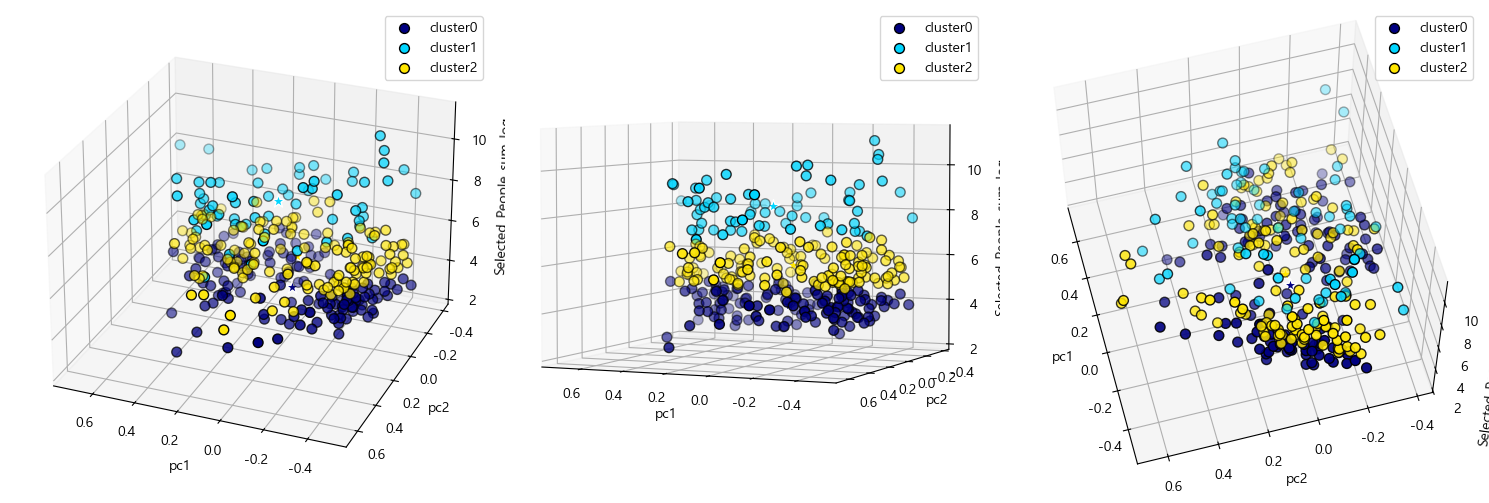

In [ ]:

x_features = pivot_tour[['pc1','pc2', 'Selected_People_sum_log']].values

# 군집 분석 후 시각화해주는 함수
def clusterScatter(n_cluster, x_features):
    c_colors = []
    kmeans = KMeans(n_clusters=n_cluster, random_state=42)
    y_labels = kmeans.fit_predict(x_features)

    fig = plt.figure(figsize=(15,10))  # 3행 1열 형식의 서브플롯 생성

    for i in range(3):
        ax = fig.add_subplot(1, 3, i + 1, projection='3d')  # 서브플롯 추가
        for j in range(n_cluster):
            c_color = cm.jet(float(j) / n_cluster)
            c_colors.append(c_color)
            # 클러스터 색상 설정

            # cluster 내 데이터 분포를 표현, centroid 동그라미로 시각화
            ax.scatter(x_features[y_labels == j, 0], x_features[y_labels == j, 1], x_features[y_labels == j, 2],
                       marker='o', color=c_color, edgecolor='black', s=50, label='cluster' + str(j))
            # 각 클러스터의 중심점(centroid) 별(*)로 표시
            ax.scatter(kmeans.cluster_centers_[j, 0], kmeans.cluster_centers_[j, 1], kmeans.cluster_centers_[j, 2],
                       marker='*', color=c_colors[j], edgecolor='w', s=100)

        ax.set_xlabel('pc1')
        ax.set_ylabel('pc2')
        ax.set_zlabel('Selected_People_sum_log')
        ax.legend()
        ax.grid()
        
        # 시각화 조정
        if i == 0:
            ax.view_init(elev=27, azim=112)
        elif i == 1:
            ax.view_init(elev=4, azim=114)
        elif i == 2:
            ax.view_init(elev=60, azim=165)

    plt.tight_layout()
    plt.show()

clusterScatter(3, x_features)

-> 위의 군집을 '인기 관광지', '일반적인 관광지','비인기 관광지'로 군집 명을 칭함

# LDA_토픽 모델링

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import json
import re
import matplotlib

# 한글 품사 태깅을 위한 모듈
from konlpy.tag import Okt
from collections import Counter
from matplotlib import font_manager, rc
from wordcloud import WordCloud

plt.rcParams['font.family'] = 'NanumGothic'

In [ ]:
file2 = '../변수정리/csv파일/final_data_set_v3.csv'

In [ ]:
# final_data_set_v2.csv 열기 --> 정답 데이터를 일단 분석해보기
# 왜냐면 나눈 것이 잘 나눠졌나 확인하려고
raw1 = pd.read_csv(file2, index_col=0)
df1 = raw1.copy()
df1.head(1)

Attraction Category     type Category_Map Category_Map_v2 Good_Point  \
0   104고지전적비       관광  history          매력도             분위기  사진이 잘 나와요   

   Selected_People  Selected_People_Ratio Participants                Address  \
0             91.0               0.250689          203  서울특별시 서대문구 연희동 산100-1   

                                                 Tag   Longitude   Latitude  \
0  #관광지#기념탑#역사#역사공부#역사관광지#역사를품은곳#역사문화재#역사속#역사속으로#...  126.926214  37.567794   

                                          Image Link  
0  https://dbscthumb-phinf.pstatic.net/2765_000_1...

In [ ]:
# 아직 분류 전 DF : 사용할 Tag만 사용
df_tag = df1[['Attraction', 'Category', 'Tag']].drop_duplicates().reset_index(drop=True)
print(df_tag.shape)
df_tag.head(2)

(785, 3)


Attraction Category                                                Tag
0     104고지전적비       관광  #관광지#기념탑#역사#역사공부#역사관광지#역사를품은곳#역사문화재#역사속#역사속으로#...
1  10꼬르소꼬모 청담점       관광  #10꼬르소꼬모#10꼬르소꼬모청담점#강남브런치카페#쇼핑#음식#청담동카페#청담동편집숍...

In [ ]:
df_tag['Category'].value_counts()

Category
음식    449
관광    336
Name: count, dtype: int64

In [ ]:
df_tag['Category'] == '관광'

0       True
1       True
2       True
3       True
4       True
       ...  
780    False
781    False
782    False
783    False
784    False
Name: Category, Length: 785, dtype: bool

In [ ]:
df_tag_tour = df_tag[df_tag['Category'] == '관광']
df_tag_food = df_tag[df_tag['Category'] == '음식']

In [ ]:
df_tag_tour.info()

<class 'pandas.core.frame.DataFrame'>
Index: 336 entries, 0 to 335
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Attraction  336 non-null    object
 1   Category    336 non-null    object
 2   Tag         336 non-null    object
dtypes: object(3)
memory usage: 10.5+ KB


In [ ]:
df_tag_food.info()

<class 'pandas.core.frame.DataFrame'>
Index: 449 entries, 336 to 784
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Attraction  449 non-null    object
 1   Category    449 non-null    object
 2   Tag         449 non-null    object
dtypes: object(3)
memory usage: 14.0+ KB


In [ ]:
df_tag_tour

Attraction Category  \
0            104고지전적비       관광   
1         10꼬르소꼬모 청담점       관광   
2                63아트       관광   
3        가락농수산물종합도매시장       관광   
4                 가락몰       관광   
..                ...      ...   
331              IFC몰       관광   
332    KCDF 갤러리숍 공예정원       관광   
333  KT&G 상상마당 디자인스퀘어       관광   
334             N서울타워       관광   
335    POOM아트박스 (신촌점)       관광   

                                                   Tag  
0    #관광지#기념탑#역사#역사공부#역사관광지#역사를품은곳#역사문화재#역사속#역사속으로#...  
1    #10꼬르소꼬모#10꼬르소꼬모청담점#강남브런치카페#쇼핑#음식#청담동카페#청담동편집숍...  
2    #63빌딩전시관#63빌딩전시회#63스퀘어#63아트#경치좋은곳#문화공간#문화시설#문화...  
3    #가락농수산물도매시장#가락시장#가족여행#나들이#나홀로여행#데이트코스#도심여행#먹거리...  
4                   #가락몰#가락몰도서관#송파수산시장#쇼핑#식자재시장#식재료쇼핑몰  
..                                                 ...  
331  #IFC몰#복합쇼핑몰#쇼핑#수도권#여의도대형쇼핑몰#여의도복합쇼핑몰#여의도쇼핑#여의도...  
332                          #갤러리숍#공예#공예품#디자인#디자인상품#쇼핑  
333                   #기념품#문화활동#복합문화공간#쇼핑#외국인친구에게추천#홍대  
334  #19_20한국관광100선#2024_여행가는달과함께하는_발도장여행지#21_22한국관...  
335  #디자인#디자인상품#디자인숍#쇼핑#신촌문구점#신촌아트박스#신촌팬시용품점#신촌팬시점#...  

[336 rows x 3 columns]

### 태그 전처리

In [ ]:
# 함수 만들기
def make_newTagCols(df, nlp):
    # tag 분리한거 담는 컬럼 만들기
    df[['newTag', 'newTag_list', 'tag_word_N']] = None
    # 모든 태그 모음집
    total = ''
    # 모든 태그의 명사 추출 모음집
    N_list = []

    # '#' 분리해서 컬럼에 담기
    for i, tag in enumerate(df.Tag):
        tag = tag.split('#')[1:]
        df['newTag_list'][i] = tag
    
        words = ''
        for t in tag:
            words = words + t + ' '
    
        total = total + words + ' '
        df['newTag'][i] = words

        # 명사 추출해서 또 새로운 컬럼에 담기
        newTag_N = list(set(nlp.nouns(words)))
        N_list.append(newTag_N)
        df['tag_word_N'][i] = newTag_N
        
    # '#'제거 해시태그 한 리스트에 모은 것 : total
    # total에서 명사 추출한 결과
    total_nouns = nlp.nouns(total)

    return df, total, N_list, total_nouns

관광부터 추출 & 시각화

In [ ]:
# 한글 단어 구분
nlp = Okt()

df_tag_tour, total_word, newTag_N_list, total_nouns = make_newTagCols(df_tag_tour, nlp)

In [ ]:
df_tag_tour.head(2)

Attraction Category                                                Tag  \
0     104고지전적비       관광  #관광지#기념탑#역사#역사공부#역사관광지#역사를품은곳#역사문화재#역사속#역사속으로#...   
1  10꼬르소꼬모 청담점       관광  #10꼬르소꼬모#10꼬르소꼬모청담점#강남브런치카페#쇼핑#음식#청담동카페#청담동편집숍...   

                                              newTag  \
0  관광지 기념탑 역사 역사공부 역사관광지 역사를품은곳 역사문화재 역사속 역사속으로 역...   
1  10꼬르소꼬모 10꼬르소꼬모청담점 강남브런치카페 쇼핑 음식 청담동카페 청담동편집숍 ...   

                                         newTag_list  \
0  [관광지, 기념탑, 역사, 역사공부, 역사관광지, 역사를품은곳, 역사문화재, 역사속...   
1  [10꼬르소꼬모, 10꼬르소꼬모청담점, 강남브런치카페, 쇼핑, 음식, 청담동카페, ...   

                                          tag_word_N  
0  [유적, 추모, 문화재, 여행, 속, 유적지, 역사탐방, 해병대, 이야기, 한국, ...  
1  [청담동, 점, 꼬르소꼬, 편집, 숍, 청담, 강남, 꼬르소꼬모, 음식, 브런치, ...

단어 정제
- 빈출 단어 제거

In [ ]:
count = Counter(total_nouns)

In [ ]:
word_count = dict()

# 빈출 단어 50위까지 word_count에 넣어주는 코드
for tag, counts in count.most_common(50):
    if (len(str(tag))>1):
        word_count[tag] = counts
        print(f'{tag} : {counts}')

여행 : 393
역사 : 281
관광지 : 182
휴식 : 179
서울 : 159
공원 : 151
시장 : 145
쇼핑 : 141
아이 : 136
문화 : 120
체험 : 110
가족 : 108
박물관 : 103
산책 : 97
친구 : 96
전통 : 93
연인 : 92
수도권 : 78
여행지 : 77
관광 : 76
공간 : 74
한국 : 67
데이트 : 63
도심 : 62
코스 : 58
자연 : 58
실내 : 57
힐링 : 54
시설 : 53
나들이 : 53
체험학습 : 42
여행가 : 36
는달 : 36
발도장 : 36
재래시장 : 35
한강 : 33
이색 : 32
교과서 : 30
유적지 : 29
남녀 : 29
노소 : 29
당일치기 : 29
투어 : 28
근교 : 27
야경 : 25
사계절 : 25
이야기 : 24


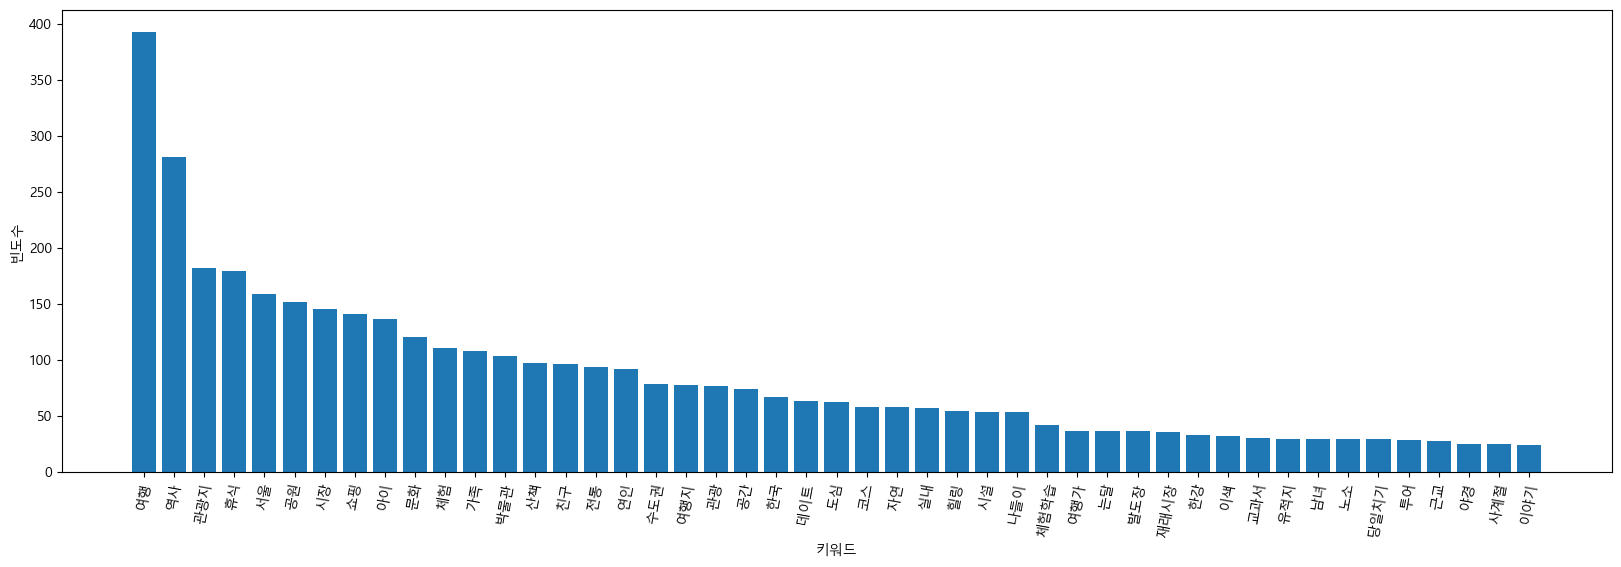

In [ ]:
font_path = "c:/Windows/fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname = font_path).get_name()
matplotlib.rc('font', family = font_name)

plt.figure(figsize = (20, 6))
plt.xlabel('키워드')
plt.ylabel('빈도수')
# plt.grid(True)

sorted_Keys = sorted(word_count, key = word_count.get, reverse = True)
sorted_Values = sorted(word_count.values(), reverse = True)

plt.bar(range(len(word_count)), sorted_Values, align = 'center')

plt.xticks(range(len(word_count)), list(sorted_Keys), rotation = 80)
plt.show()

In [ ]:
df_tag_tour['tag_word_N']

0      [유적, 추모, 문화재, 여행, 속, 유적지, 역사탐방, 해병대, 이야기, 한국, ...
1      [청담동, 점, 꼬르소꼬, 편집, 숍, 청담, 강남, 꼬르소꼬모, 음식, 브런치, ...
2      [여행지, 예술, 복합, 스퀘어, 빌딩, 화공, 전시회, 아트, 전시관, 문화, 실...
3      [홀로, 여행, 가족, 맛집, 쇼핑, 나들이, 아이, 데이트, 전통, 도심, 투어,...
4            [송파, 재시, 식, 쇼핑몰, 식자, 도서관, 가락, 수산시장, 쇼핑, 재료]
                             ...                        
331    [쇼핑몰, 대형, 수도권, 크리스마스, 영등포, 복합, 무, 연중, 아이에프, 쇼핑...
332                       [디자인, 숍, 갤러리, 상품, 공예품, 쇼핑, 공예]
333           [공간, 홍대, 기념품, 친구, 외국인, 복합, 추천, 활동, 문화, 쇼핑]
334    [근교, 여행지, 홀로, 발도장, 여행, 여행가, 선, 타워, 가족, 서울, 관광,...
335    [디자인, 숍, 점, 팬, 학용품, 박스, 아트, 상품, 시점, 용품, 문구점, 신...
Name: tag_word_N, Length: 336, dtype: object

In [ ]:
df_tag_tour

Attraction Category  \
0            104고지전적비       관광   
1         10꼬르소꼬모 청담점       관광   
2                63아트       관광   
3        가락농수산물종합도매시장       관광   
4                 가락몰       관광   
..                ...      ...   
331              IFC몰       관광   
332    KCDF 갤러리숍 공예정원       관광   
333  KT&G 상상마당 디자인스퀘어       관광   
334             N서울타워       관광   
335    POOM아트박스 (신촌점)       관광   

                                                   Tag  \
0    #관광지#기념탑#역사#역사공부#역사관광지#역사를품은곳#역사문화재#역사속#역사속으로#...   
1    #10꼬르소꼬모#10꼬르소꼬모청담점#강남브런치카페#쇼핑#음식#청담동카페#청담동편집숍...   
2    #63빌딩전시관#63빌딩전시회#63스퀘어#63아트#경치좋은곳#문화공간#문화시설#문화...   
3    #가락농수산물도매시장#가락시장#가족여행#나들이#나홀로여행#데이트코스#도심여행#먹거리...   
4                   #가락몰#가락몰도서관#송파수산시장#쇼핑#식자재시장#식재료쇼핑몰   
..                                                 ...   
331  #IFC몰#복합쇼핑몰#쇼핑#수도권#여의도대형쇼핑몰#여의도복합쇼핑몰#여의도쇼핑#여의도...   
332                          #갤러리숍#공예#공예품#디자인#디자인상품#쇼핑   
333                   #기념품#문화활동#복합문화공간#쇼핑#외국인친구에게추천#홍대   
334  #19_20한국관광100선#2024_여행가는달과함께하는_발도장여행지#21_22한국관...   
335  #디자인#디자인상품#디자인숍#쇼핑#신촌문구점#신촌아트박스#신촌팬시용품점#신촌팬시점#...   

                                                newTag  \
0    관광지 기념탑 역사 역사공부 역사관광지 역사를품은곳 역사문화재 역사속 역사속으로 역...   
1    10꼬르소꼬모 10꼬르소꼬모청담점 강남브런치카페 쇼핑 음식 청담동카페 청담동편집숍 ...   
2    63빌딩전시관 63빌딩전시회 63스퀘어 63아트 경치좋은곳 문화공간 문화시설 문화예...   
3    가락농수산물도매시장 가락시장 가족여행 나들이 나홀로여행 데이트코스 도심여행 먹거리 ...   
4                   가락몰 가락몰도서관 송파수산시장 쇼핑 식자재시장 식재료쇼핑몰    
..                                                 ...   
331  IFC몰 복합쇼핑몰 쇼핑 수도권 여의도대형쇼핑몰 여의도복합쇼핑몰 여의도쇼핑 여의도아...   
332                          갤러리숍 공예 공예품 디자인 디자인상품 쇼핑    
333                   기념품 문화활동 복합문화공간 쇼핑 외국인친구에게추천 홍대    
334  19_20한국관광100선 2024_여행가는달과함께하는_발도장여행지 21_22한국관광...   
335  디자인 디자인상품 디자인숍 쇼핑 신촌문구점 신촌아트박스 신촌팬시용품점 신촌팬시점 신...   

                                           newTag_list  \
0    [관광지, 기념탑, 역사, 역사공부, 역사관광지, 역사를품은곳, 역사문화재, 역사속...   
1    [10꼬르소꼬모, 10꼬르소꼬모청담점, 강남브런치카페, 쇼핑, 음식, 청담동카페, ...   
2    [63빌딩전시관, 63빌딩전시회, 63스퀘어, 63아트, 경치좋은곳, 문화공간, 문...   
3    [가락농수산물도매시장, 가락시장, 가족여행, 나들이, 나홀로여행, 데이트코스, 도심...   
4             [가락몰, 가락몰도서관, 송파수산시장, 쇼핑, 식자재시장, 식재료쇼핑몰]   
..                                                 ...   
331  [IFC몰, 복합쇼핑몰, 쇼핑, 수도권, 여의도대형쇼핑몰, 여의도복합쇼핑몰, 여의도...   
332                    [갤러리숍, 공예, 공예품, 디자인, 디자인상품, 쇼핑]   
333             [기념품, 문화활동, 복합문화공간, 쇼핑, 외국인친구에게추천, 홍대]   
334  [19_20한국관광100선, 2024_여행가는달과함께하는_발도장여행지, 21_22한...   
335  [디자인, 디자인상품, 디자인숍, 쇼핑, 신촌문구점, 신촌아트박스, 신촌팬시용품점,...   

                                            tag_word_N  
0    [유적, 추모, 문화재, 여행, 속, 유적지, 역사탐방, 해병대, 이야기, 한국, ...  
1    [청담동, 점, 꼬르소꼬, 편집, 숍, 청담, 강남, 꼬르소꼬모, 음식, 브런치, ...  
2    [여행지, 예술, 복합, 스퀘어, 빌딩, 화공, 전시회, 아트, 전시관, 문화, 실...  
3    [홀로, 여행, 가족, 맛집, 쇼핑, 나들이, 아이, 데이트, 전통, 도심, 투어,...  
4          [송파, 재시, 식, 쇼핑몰, 식자, 도서관, 가락, 수산시장, 쇼핑, 재료]  
..                                                 ...  
331  [쇼핑몰, 대형, 수도권, 크리스마스, 영등포, 복합, 무, 연중, 아이에프, 쇼핑...  
332                     [디자인, 숍, 갤러리, 상품, 공예품, 쇼핑, 공예]  
333         [공간, 홍대, 기념품, 친구, 외국인, 복합, 추천, 활동, 문화, 쇼핑]  
334  [근교, 여행지, 홀로, 발도장, 여행, 여행가, 선, 타워, 가족, 서울, 관광,...  
335  [디자인, 숍, 점, 팬, 학용품, 박스, 아트, 상품, 시점, 용품, 문구점, 신...  

[336 rows x 6 columns]

In [ ]:
# temp_list = []

# for i in range(len(df_tag_tour)):
#     for j in range(len(df_tag_tour['tag_word_N'][i])):
#         if df_tag_tour['tag_word_N'][i][j] not in word_50:
#             temp_list = temp_list.append(df_tag_tour['tag_word_N'][i][j])
#             df_tag_tour['tag_word_N'][i] = temp_list
#         else:
#             continue

In [ ]:
df_tag_tour

Attraction Category  \
0            104고지전적비       관광   
1         10꼬르소꼬모 청담점       관광   
2                63아트       관광   
3        가락농수산물종합도매시장       관광   
4                 가락몰       관광   
..                ...      ...   
331              IFC몰       관광   
332    KCDF 갤러리숍 공예정원       관광   
333  KT&G 상상마당 디자인스퀘어       관광   
334             N서울타워       관광   
335    POOM아트박스 (신촌점)       관광   

                                                   Tag  \
0    #관광지#기념탑#역사#역사공부#역사관광지#역사를품은곳#역사문화재#역사속#역사속으로#...   
1    #10꼬르소꼬모#10꼬르소꼬모청담점#강남브런치카페#쇼핑#음식#청담동카페#청담동편집숍...   
2    #63빌딩전시관#63빌딩전시회#63스퀘어#63아트#경치좋은곳#문화공간#문화시설#문화...   
3    #가락농수산물도매시장#가락시장#가족여행#나들이#나홀로여행#데이트코스#도심여행#먹거리...   
4                   #가락몰#가락몰도서관#송파수산시장#쇼핑#식자재시장#식재료쇼핑몰   
..                                                 ...   
331  #IFC몰#복합쇼핑몰#쇼핑#수도권#여의도대형쇼핑몰#여의도복합쇼핑몰#여의도쇼핑#여의도...   
332                          #갤러리숍#공예#공예품#디자인#디자인상품#쇼핑   
333                   #기념품#문화활동#복합문화공간#쇼핑#외국인친구에게추천#홍대   
334  #19_20한국관광100선#2024_여행가는달과함께하는_발도장여행지#21_22한국관...   
335  #디자인#디자인상품#디자인숍#쇼핑#신촌문구점#신촌아트박스#신촌팬시용품점#신촌팬시점#...   

                                                newTag  \
0    관광지 기념탑 역사 역사공부 역사관광지 역사를품은곳 역사문화재 역사속 역사속으로 역...   
1    10꼬르소꼬모 10꼬르소꼬모청담점 강남브런치카페 쇼핑 음식 청담동카페 청담동편집숍 ...   
2    63빌딩전시관 63빌딩전시회 63스퀘어 63아트 경치좋은곳 문화공간 문화시설 문화예...   
3    가락농수산물도매시장 가락시장 가족여행 나들이 나홀로여행 데이트코스 도심여행 먹거리 ...   
4                   가락몰 가락몰도서관 송파수산시장 쇼핑 식자재시장 식재료쇼핑몰    
..                                                 ...   
331  IFC몰 복합쇼핑몰 쇼핑 수도권 여의도대형쇼핑몰 여의도복합쇼핑몰 여의도쇼핑 여의도아...   
332                          갤러리숍 공예 공예품 디자인 디자인상품 쇼핑    
333                   기념품 문화활동 복합문화공간 쇼핑 외국인친구에게추천 홍대    
334  19_20한국관광100선 2024_여행가는달과함께하는_발도장여행지 21_22한국관광...   
335  디자인 디자인상품 디자인숍 쇼핑 신촌문구점 신촌아트박스 신촌팬시용품점 신촌팬시점 신...   

                                           newTag_list  \
0    [관광지, 기념탑, 역사, 역사공부, 역사관광지, 역사를품은곳, 역사문화재, 역사속...   
1    [10꼬르소꼬모, 10꼬르소꼬모청담점, 강남브런치카페, 쇼핑, 음식, 청담동카페, ...   
2    [63빌딩전시관, 63빌딩전시회, 63스퀘어, 63아트, 경치좋은곳, 문화공간, 문...   
3    [가락농수산물도매시장, 가락시장, 가족여행, 나들이, 나홀로여행, 데이트코스, 도심...   
4             [가락몰, 가락몰도서관, 송파수산시장, 쇼핑, 식자재시장, 식재료쇼핑몰]   
..                                                 ...   
331  [IFC몰, 복합쇼핑몰, 쇼핑, 수도권, 여의도대형쇼핑몰, 여의도복합쇼핑몰, 여의도...   
332                    [갤러리숍, 공예, 공예품, 디자인, 디자인상품, 쇼핑]   
333             [기념품, 문화활동, 복합문화공간, 쇼핑, 외국인친구에게추천, 홍대]   
334  [19_20한국관광100선, 2024_여행가는달과함께하는_발도장여행지, 21_22한...   
335  [디자인, 디자인상품, 디자인숍, 쇼핑, 신촌문구점, 신촌아트박스, 신촌팬시용품점,...   

                                            tag_word_N  
0    [유적, 추모, 문화재, 여행, 속, 유적지, 역사탐방, 해병대, 이야기, 한국, ...  
1    [청담동, 점, 꼬르소꼬, 편집, 숍, 청담, 강남, 꼬르소꼬모, 음식, 브런치, ...  
2    [여행지, 예술, 복합, 스퀘어, 빌딩, 화공, 전시회, 아트, 전시관, 문화, 실...  
3    [홀로, 여행, 가족, 맛집, 쇼핑, 나들이, 아이, 데이트, 전통, 도심, 투어,...  
4          [송파, 재시, 식, 쇼핑몰, 식자, 도서관, 가락, 수산시장, 쇼핑, 재료]  
..                                                 ...  
331  [쇼핑몰, 대형, 수도권, 크리스마스, 영등포, 복합, 무, 연중, 아이에프, 쇼핑...  
332                     [디자인, 숍, 갤러리, 상품, 공예품, 쇼핑, 공예]  
333         [공간, 홍대, 기념품, 친구, 외국인, 복합, 추천, 활동, 문화, 쇼핑]  
334  [근교, 여행지, 홀로, 발도장, 여행, 여행가, 선, 타워, 가족, 서울, 관광,...  
335  [디자인, 숍, 점, 팬, 학용품, 박스, 아트, 상품, 시점, 용품, 문구점, 신...  

[336 rows x 6 columns]

In [ ]:
news_texts = df_tag_tour['tag_word_N']

In [ ]:
news_texts.shape

(336,)

In [ ]:
# gensim 모듈에서 제공하는 corpora : 문서 - 단어 행렬을 생성하고 관리함
from gensim import corpora

# corpora의 Dictionary 함수를 사용하여 news_texts 리스트에서 단어 사전을 생성
# 토큰화되어있는 news_texts에서 각 단어들에 고유한 ID를 할당하고 해당 ID의 매핑을 관리
# 즉, dictionary는 각 단어와 해당 단어의 고유 ID를 포함하는 사전
dictionary = corpora.Dictionary(news_texts)

# 리스트 컴프리헨션 해석
# news_texts에서 text를 하나씩 뽑아와서 Bag-of-Words 형식으로 변환
# BoW 형식 : (단어ID, 해당 단어의 빈도 수) 튜플 형식의 리스트
# 예시 - ['word1', 'word2', 'word1']라는 문서는 [(0, 2), (1, 1)]으로 변환 / 여기서 0과 1은 word1과 word2의 ID이며, 2와 1은 각 단어의 빈도이다
corpus = [dictionary.doc2bow(text) for text in news_texts]

print(corpus[1])

[(19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1)]


In [ ]:
# gensim에서 제공하는 Lda 모델
from gensim.models import LdaModel

# corpus : BoW 형식으로 변환된 문서-단어 행렬
# num_topics : 추출할 주제의 수
# id2word : 단어 ID와 단어의 매핑을 제공하는 사전
lda_model = LdaModel(corpus, num_topics=3, id2word=dictionary, random_state=42)
topics = lda_model.print_topics()
topics

[(0,
  '0.029*"쇼핑" + 0.025*"여행" + 0.020*"친구" + 0.019*"관광지" + 0.018*"전통" + 0.016*"가족" + 0.015*"코스" + 0.015*"연인" + 0.015*"곳" + 0.014*"문화"'),
 (1,
  '0.029*"아이" + 0.027*"여행" + 0.024*"서울" + 0.021*"쇼핑" + 0.020*"문화" + 0.019*"관광지" + 0.017*"가족" + 0.016*"전통" + 0.016*"체험" + 0.016*"역사"'),
 (2,
  '0.039*"관광지" + 0.037*"여행" + 0.031*"곳" + 0.020*"아이" + 0.019*"연인" + 0.019*"공간" + 0.018*"휴식" + 0.017*"가족" + 0.016*"서울" + 0.016*"친구"')]

In [ ]:
# CoherenceModel : 주제의 일관성을 평가하는 지표 높을수록 주제의 일관성이 높다
from gensim.models.coherencemodel import CoherenceModel

# 주제의 개수 최소 최대값 지정
min_topics, max_topics = 3, 10
# 최소~최대 범위내의 coherence score 담을 리스트
coherence_score = []

# 최소~최대 범위에서 각 주제 개수에 해당하는 coherence score 구하는 반복문
for num_topics in range(min_topics, max_topics):
    model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, random_state=42)
    coherence = CoherenceModel(model=model,
                               texts=news_texts,
                               dictionary=dictionary)
    coherence_score.append(coherence.get_coherence())
    
print(coherence_score)

[0.5622679998925147, 0.5890096591858661, 0.5818516843416004, 0.5616866608815855, 0.5368544918547261, 0.5323856956560387, 0.5269651601272307]


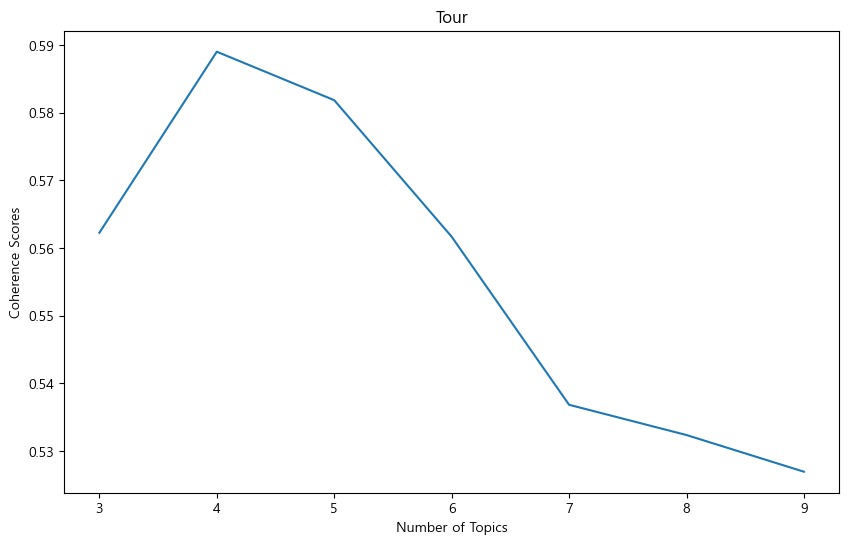

In [ ]:
# coherence score 결과 시각화
import matplotlib.pyplot as plt

x = [i for i in range(min_topics, max_topics)]

plt.figure(figsize=(10,6))
plt.plot(x, coherence_score)
# x축 값 : 최소~최대 범위의 수
# y축 값 : 반복문으로 추출한 coherence_score
plt.title('Tour')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Scores')
plt.show()

# 토픽의 수가 21일때 가장 높은 점수를 보인다.

In [ ]:
# 점수가 가장 높은 토픽수를 반영하여 다시 추출

lda_model = LdaModel(corpus, num_topics=3, id2word=dictionary, random_state=42)
topics = lda_model.print_topics(num_topics=3)
topics

[(0,
  '0.029*"쇼핑" + 0.025*"여행" + 0.020*"친구" + 0.019*"관광지" + 0.018*"전통" + 0.016*"가족" + 0.015*"코스" + 0.015*"연인" + 0.015*"곳" + 0.014*"문화"'),
 (1,
  '0.029*"아이" + 0.027*"여행" + 0.024*"서울" + 0.021*"쇼핑" + 0.020*"문화" + 0.019*"관광지" + 0.017*"가족" + 0.016*"전통" + 0.016*"체험" + 0.016*"역사"'),
 (2,
  '0.039*"관광지" + 0.037*"여행" + 0.031*"곳" + 0.020*"아이" + 0.019*"연인" + 0.019*"공간" + 0.018*"휴식" + 0.017*"가족" + 0.016*"서울" + 0.016*"친구"')]

In [ ]:
# Tour 복잡도

perplexity = lda_model.log_perplexity(corpus)
print(f"Perplexity: {perplexity}")

Perplexity: -6.043142510273193


토픽 모델링 시각화

In [ ]:
# pyLDAvis : LDA 분석 결과를 시각화해주는 모듈
import pyLDAvis.gensim

# pyLDAvis의 노트북 모드를 활성화 >> Jupyter Notebook에서 시각화 결과를 바로 직접 볼 수 있도록 하기 위함
pyLDAvis.enable_notebook()

# pyLDAvis.gensim.prepare() : LDA 모델의 시각화 준비하는 코드
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)

# 준비된 시각화를 노트북에서 표시
pyLDAvis.display(vis)

In [ ]:
pyLDAvis.save_html(vis, './관광_3_vis.html')

각 관광지가 어디 주제에 속하는 지 라벨링하는 코드

In [ ]:
doc_topic_dist = lda_model[corpus]
doc_topic_dist

In [ ]:
import pandas as pd

# 각 문서의 주제 분포를 수집할 리스트
doc_topic_list = []

for i, doc in enumerate(doc_topic_dist):
    # 각 문서의 주제 분포를 딕셔너리로 변환
    topic_probs = {f"Topic {topic_id}": prob for topic_id, prob in doc}
    # 문서 ID를 딕셔너리에 추가
    topic_probs["Document"] = i
    doc_topic_list.append(topic_probs)

# 리스트를 DataFrame으로 변환
doc_topic_df = pd.DataFrame(doc_topic_list)

# NaN 값을 0으로 대체
doc_topic_df = doc_topic_df.fillna(0)

doc_topic_df

Topic 0   Topic 1   Topic 2  Document
0    0.017723  0.963144  0.019133         0
1    0.032127  0.027361  0.940511         1
2    0.018019  0.018326  0.963655         2
3    0.971062  0.014837  0.014101         3
4    0.034335  0.032079  0.933587         4
..        ...       ...       ...       ...
331  0.031423  0.033212  0.935365       331
332  0.048102  0.056209  0.895689       332
333  0.037971  0.922839  0.039190       333
334  0.012748  0.734655  0.252597       334
335  0.027332  0.025238  0.947430       335

[336 rows x 4 columns]

In [ ]:
doc_topic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Topic 0   336 non-null    float32
 1   Topic 1   336 non-null    float32
 2   Topic 2   336 non-null    float32
 3   Document  336 non-null    int64  
dtypes: float32(3), int64(1)
memory usage: 6.7 KB


In [ ]:
doc_topic_df_temp = doc_topic_df.iloc[:,:-1]

In [ ]:
doc_topic_df_temp

Topic 0   Topic 1   Topic 2
0    0.017723  0.963144  0.019133
1    0.032127  0.027361  0.940511
2    0.018019  0.018326  0.963655
3    0.971062  0.014837  0.014101
4    0.034335  0.032079  0.933587
..        ...       ...       ...
331  0.031423  0.033212  0.935365
332  0.048102  0.056209  0.895689
333  0.037971  0.922839  0.039190
334  0.012748  0.734655  0.252597
335  0.027332  0.025238  0.947430

[336 rows x 3 columns]

In [ ]:
df_tag_tour

Attraction Category  \
0            104고지전적비       관광   
1         10꼬르소꼬모 청담점       관광   
2                63아트       관광   
3        가락농수산물종합도매시장       관광   
4                 가락몰       관광   
..                ...      ...   
331              IFC몰       관광   
332    KCDF 갤러리숍 공예정원       관광   
333  KT&G 상상마당 디자인스퀘어       관광   
334             N서울타워       관광   
335    POOM아트박스 (신촌점)       관광   

                                                   Tag  \
0    #관광지#기념탑#역사#역사공부#역사관광지#역사를품은곳#역사문화재#역사속#역사속으로#...   
1    #10꼬르소꼬모#10꼬르소꼬모청담점#강남브런치카페#쇼핑#음식#청담동카페#청담동편집숍...   
2    #63빌딩전시관#63빌딩전시회#63스퀘어#63아트#경치좋은곳#문화공간#문화시설#문화...   
3    #가락농수산물도매시장#가락시장#가족여행#나들이#나홀로여행#데이트코스#도심여행#먹거리...   
4                   #가락몰#가락몰도서관#송파수산시장#쇼핑#식자재시장#식재료쇼핑몰   
..                                                 ...   
331  #IFC몰#복합쇼핑몰#쇼핑#수도권#여의도대형쇼핑몰#여의도복합쇼핑몰#여의도쇼핑#여의도...   
332                          #갤러리숍#공예#공예품#디자인#디자인상품#쇼핑   
333                   #기념품#문화활동#복합문화공간#쇼핑#외국인친구에게추천#홍대   
334  #19_20한국관광100선#2024_여행가는달과함께하는_발도장여행지#21_22한국관...   
335  #디자인#디자인상품#디자인숍#쇼핑#신촌문구점#신촌아트박스#신촌팬시용품점#신촌팬시점#...   

                                                newTag  \
0    관광지 기념탑 역사 역사공부 역사관광지 역사를품은곳 역사문화재 역사속 역사속으로 역...   
1    10꼬르소꼬모 10꼬르소꼬모청담점 강남브런치카페 쇼핑 음식 청담동카페 청담동편집숍 ...   
2    63빌딩전시관 63빌딩전시회 63스퀘어 63아트 경치좋은곳 문화공간 문화시설 문화예...   
3    가락농수산물도매시장 가락시장 가족여행 나들이 나홀로여행 데이트코스 도심여행 먹거리 ...   
4                   가락몰 가락몰도서관 송파수산시장 쇼핑 식자재시장 식재료쇼핑몰    
..                                                 ...   
331  IFC몰 복합쇼핑몰 쇼핑 수도권 여의도대형쇼핑몰 여의도복합쇼핑몰 여의도쇼핑 여의도아...   
332                          갤러리숍 공예 공예품 디자인 디자인상품 쇼핑    
333                   기념품 문화활동 복합문화공간 쇼핑 외국인친구에게추천 홍대    
334  19_20한국관광100선 2024_여행가는달과함께하는_발도장여행지 21_22한국관광...   
335  디자인 디자인상품 디자인숍 쇼핑 신촌문구점 신촌아트박스 신촌팬시용품점 신촌팬시점 신...   

                                           newTag_list  \
0    [관광지, 기념탑, 역사, 역사공부, 역사관광지, 역사를품은곳, 역사문화재, 역사속...   
1    [10꼬르소꼬모, 10꼬르소꼬모청담점, 강남브런치카페, 쇼핑, 음식, 청담동카페, ...   
2    [63빌딩전시관, 63빌딩전시회, 63스퀘어, 63아트, 경치좋은곳, 문화공간, 문...   
3    [가락농수산물도매시장, 가락시장, 가족여행, 나들이, 나홀로여행, 데이트코스, 도심...   
4             [가락몰, 가락몰도서관, 송파수산시장, 쇼핑, 식자재시장, 식재료쇼핑몰]   
..                                                 ...   
331  [IFC몰, 복합쇼핑몰, 쇼핑, 수도권, 여의도대형쇼핑몰, 여의도복합쇼핑몰, 여의도...   
332                    [갤러리숍, 공예, 공예품, 디자인, 디자인상품, 쇼핑]   
333             [기념품, 문화활동, 복합문화공간, 쇼핑, 외국인친구에게추천, 홍대]   
334  [19_20한국관광100선, 2024_여행가는달과함께하는_발도장여행지, 21_22한...   
335  [디자인, 디자인상품, 디자인숍, 쇼핑, 신촌문구점, 신촌아트박스, 신촌팬시용품점,...   

                                            tag_word_N  
0    [유적, 추모, 문화재, 여행, 속, 유적지, 역사탐방, 해병대, 이야기, 한국, ...  
1    [청담동, 점, 꼬르소꼬, 편집, 숍, 청담, 강남, 꼬르소꼬모, 음식, 브런치, ...  
2    [여행지, 예술, 복합, 스퀘어, 빌딩, 화공, 전시회, 아트, 전시관, 문화, 실...  
3    [홀로, 여행, 가족, 맛집, 쇼핑, 나들이, 아이, 데이트, 전통, 도심, 투어,...  
4          [송파, 재시, 식, 쇼핑몰, 식자, 도서관, 가락, 수산시장, 쇼핑, 재료]  
..                                                 ...  
331  [쇼핑몰, 대형, 수도권, 크리스마스, 영등포, 복합, 무, 연중, 아이에프, 쇼핑...  
332                     [디자인, 숍, 갤러리, 상품, 공예품, 쇼핑, 공예]  
333         [공간, 홍대, 기념품, 친구, 외국인, 복합, 추천, 활동, 문화, 쇼핑]  
334  [근교, 여행지, 홀로, 발도장, 여행, 여행가, 선, 타워, 가족, 서울, 관광,...  
335  [디자인, 숍, 점, 팬, 학용품, 박스, 아트, 상품, 시점, 용품, 문구점, 신...  

[336 rows x 6 columns]

In [ ]:
def max_count(x, y):
    # 최빈 단어 유형 추출 후 새로운 컬럼에 추가
    x['Max'] = x.max(axis=0)
    x['Max_Column'] = x.idxmax(axis=1)
    
    # temp가 아닌 원래 데이터에 컬럼명 변경하여 값 넣기
    y['max'] = x['Max']
    
    # temp가 아닌 원래 데이터에 컬럼명 변경하여 값 넣기
    y['topic_type'] = x['Max_Column']

In [ ]:
max_count(doc_topic_df_temp,doc_topic_df)

In [ ]:
doc_topic_df['topic_type']

0      Topic 1
1      Topic 2
2      Topic 2
3      Topic 0
4      Topic 2
        ...   
331    Topic 2
332    Topic 2
333    Topic 1
334    Topic 1
335    Topic 2
Name: topic_type, Length: 336, dtype: object

In [ ]:
df_tag_tour['topic_type'] = doc_topic_df['topic_type']

In [ ]:
df_tag_tour

Attraction Category  \
0            104고지전적비       관광   
1         10꼬르소꼬모 청담점       관광   
2                63아트       관광   
3        가락농수산물종합도매시장       관광   
4                 가락몰       관광   
..                ...      ...   
331              IFC몰       관광   
332    KCDF 갤러리숍 공예정원       관광   
333  KT&G 상상마당 디자인스퀘어       관광   
334             N서울타워       관광   
335    POOM아트박스 (신촌점)       관광   

                                                   Tag  \
0    #관광지#기념탑#역사#역사공부#역사관광지#역사를품은곳#역사문화재#역사속#역사속으로#...   
1    #10꼬르소꼬모#10꼬르소꼬모청담점#강남브런치카페#쇼핑#음식#청담동카페#청담동편집숍...   
2    #63빌딩전시관#63빌딩전시회#63스퀘어#63아트#경치좋은곳#문화공간#문화시설#문화...   
3    #가락농수산물도매시장#가락시장#가족여행#나들이#나홀로여행#데이트코스#도심여행#먹거리...   
4                   #가락몰#가락몰도서관#송파수산시장#쇼핑#식자재시장#식재료쇼핑몰   
..                                                 ...   
331  #IFC몰#복합쇼핑몰#쇼핑#수도권#여의도대형쇼핑몰#여의도복합쇼핑몰#여의도쇼핑#여의도...   
332                          #갤러리숍#공예#공예품#디자인#디자인상품#쇼핑   
333                   #기념품#문화활동#복합문화공간#쇼핑#외국인친구에게추천#홍대   
334  #19_20한국관광100선#2024_여행가는달과함께하는_발도장여행지#21_22한국관...   
335  #디자인#디자인상품#디자인숍#쇼핑#신촌문구점#신촌아트박스#신촌팬시용품점#신촌팬시점#...   

                                                newTag  \
0    관광지 기념탑 역사 역사공부 역사관광지 역사를품은곳 역사문화재 역사속 역사속으로 역...   
1    10꼬르소꼬모 10꼬르소꼬모청담점 강남브런치카페 쇼핑 음식 청담동카페 청담동편집숍 ...   
2    63빌딩전시관 63빌딩전시회 63스퀘어 63아트 경치좋은곳 문화공간 문화시설 문화예...   
3    가락농수산물도매시장 가락시장 가족여행 나들이 나홀로여행 데이트코스 도심여행 먹거리 ...   
4                   가락몰 가락몰도서관 송파수산시장 쇼핑 식자재시장 식재료쇼핑몰    
..                                                 ...   
331  IFC몰 복합쇼핑몰 쇼핑 수도권 여의도대형쇼핑몰 여의도복합쇼핑몰 여의도쇼핑 여의도아...   
332                          갤러리숍 공예 공예품 디자인 디자인상품 쇼핑    
333                   기념품 문화활동 복합문화공간 쇼핑 외국인친구에게추천 홍대    
334  19_20한국관광100선 2024_여행가는달과함께하는_발도장여행지 21_22한국관광...   
335  디자인 디자인상품 디자인숍 쇼핑 신촌문구점 신촌아트박스 신촌팬시용품점 신촌팬시점 신...   

                                           newTag_list  \
0    [관광지, 기념탑, 역사, 역사공부, 역사관광지, 역사를품은곳, 역사문화재, 역사속...   
1    [10꼬르소꼬모, 10꼬르소꼬모청담점, 강남브런치카페, 쇼핑, 음식, 청담동카페, ...   
2    [63빌딩전시관, 63빌딩전시회, 63스퀘어, 63아트, 경치좋은곳, 문화공간, 문...   
3    [가락농수산물도매시장, 가락시장, 가족여행, 나들이, 나홀로여행, 데이트코스, 도심...   
4             [가락몰, 가락몰도서관, 송파수산시장, 쇼핑, 식자재시장, 식재료쇼핑몰]   
..                                                 ...   
331  [IFC몰, 복합쇼핑몰, 쇼핑, 수도권, 여의도대형쇼핑몰, 여의도복합쇼핑몰, 여의도...   
332                    [갤러리숍, 공예, 공예품, 디자인, 디자인상품, 쇼핑]   
333             [기념품, 문화활동, 복합문화공간, 쇼핑, 외국인친구에게추천, 홍대]   
334  [19_20한국관광100선, 2024_여행가는달과함께하는_발도장여행지, 21_22한...   
335  [디자인, 디자인상품, 디자인숍, 쇼핑, 신촌문구점, 신촌아트박스, 신촌팬시용품점,...   

                                            tag_word_N topic_type  
0    [유적, 추모, 문화재, 여행, 속, 유적지, 역사탐방, 해병대, 이야기, 한국, ...    Topic 1  
1    [청담동, 점, 꼬르소꼬, 편집, 숍, 청담, 강남, 꼬르소꼬모, 음식, 브런치, ...    Topic 2  
2    [여행지, 예술, 복합, 스퀘어, 빌딩, 화공, 전시회, 아트, 전시관, 문화, 실...    Topic 2  
3    [홀로, 여행, 가족, 맛집, 쇼핑, 나들이, 아이, 데이트, 전통, 도심, 투어,...    Topic 0  
4          [송파, 재시, 식, 쇼핑몰, 식자, 도서관, 가락, 수산시장, 쇼핑, 재료]    Topic 2  
..                                                 ...        ...  
331  [쇼핑몰, 대형, 수도권, 크리스마스, 영등포, 복합, 무, 연중, 아이에프, 쇼핑...    Topic 2  
332                     [디자인, 숍, 갤러리, 상품, 공예품, 쇼핑, 공예]    Topic 2  
333         [공간, 홍대, 기념품, 친구, 외국인, 복합, 추천, 활동, 문화, 쇼핑]    Topic 1  
334  [근교, 여행지, 홀로, 발도장, 여행, 여행가, 선, 타워, 가족, 서울, 관광,...    Topic 1  
335  [디자인, 숍, 점, 팬, 학용품, 박스, 아트, 상품, 시점, 용품, 문구점, 신...    Topic 2  

[336 rows x 7 columns]

In [ ]:
df_tag_tour = df_tag_tour.drop(columns=['Category','Tag', 'newTag', 'newTag_list', 'tag_word_N'])

In [ ]:
df_tag_tour

Attraction topic_type
0            104고지전적비    Topic 1
1         10꼬르소꼬모 청담점    Topic 2
2                63아트    Topic 2
3        가락농수산물종합도매시장    Topic 0
4                 가락몰    Topic 2
..                ...        ...
331              IFC몰    Topic 2
332    KCDF 갤러리숍 공예정원    Topic 2
333  KT&G 상상마당 디자인스퀘어    Topic 1
334             N서울타워    Topic 1
335    POOM아트박스 (신촌점)    Topic 2

[336 rows x 2 columns]

In [ ]:
df_tag_tour['Topic 0'] = doc_topic_df['Topic 0']
df_tag_tour['Topic 1'] = doc_topic_df['Topic 1']
df_tag_tour['Topic 2'] = doc_topic_df['Topic 2']

In [ ]:
df_tag_tour

Attraction topic_type   Topic 0   Topic 1   Topic 2
0            104고지전적비    Topic 1  0.017723  0.963144  0.019133
1         10꼬르소꼬모 청담점    Topic 2  0.032127  0.027361  0.940511
2                63아트    Topic 2  0.018019  0.018326  0.963655
3        가락농수산물종합도매시장    Topic 0  0.971062  0.014837  0.014101
4                 가락몰    Topic 2  0.034335  0.032079  0.933587
..                ...        ...       ...       ...       ...
331              IFC몰    Topic 2  0.031423  0.033212  0.935365
332    KCDF 갤러리숍 공예정원    Topic 2  0.048102  0.056209  0.895689
333  KT&G 상상마당 디자인스퀘어    Topic 1  0.037971  0.922839  0.039190
334             N서울타워    Topic 1  0.012748  0.734655  0.252597
335    POOM아트박스 (신촌점)    Topic 2  0.027332  0.025238  0.947430

[336 rows x 5 columns]

In [ ]:
df_tag_tour.to_csv('./LDA_tour_3개.csv')

# 사용된 함수 통합 part

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 데이터 수집 단계 함수
- [수정본]구석구석_크롤링_코드.ipynb
- 네이버_리뷰_크롤링_최종_배포용.ipynb

In [ ]:
def button_click():
    # "인기순" 버튼 클릭
    popular_button = WebDriverWait(driver, 20).until(EC.element_to_be_clickable((By.XPATH, '//button[contains(text(), "인기순")]')))
    driver.execute_script("arguments[0].click();", popular_button)

    # 서울 버튼 클릭
    seoul_button = WebDriverWait(driver, 20).until(EC.element_to_be_clickable((By.XPATH, '//*[@id="1"]/button/span')))
    driver.execute_script("arguments[0].click();", seoul_button)

    # 서울 버튼 클릭 후, 해당 지역의 데이터가 로드될 때까지 대기
    wait = WebDriverWait(driver, 30)
    wait.until(EC.presence_of_element_located((By.XPATH, '//*[@id="contents"]/div[2]/div[1]/ul/li[1]/div[2]/div/a')))


# 각 페이지 데이터 추출 함수
# 이동한 페이지의 데이터를 추출하기 위해, 이동한 페이지의 html 소스를 가져와 파싱
def extract_data(soup, attraction_list, location_list, tag_list):
    for i in range(10):
        attraction = soup.select_one(f'#contents > div.wrap_contView.clfix > div.box_leftType1 > ul > li:nth-child({i+1}) > div.area_txt.catchphrase > div > a')
        location = soup.select_one(f'#contents > div.wrap_contView.clfix > div.box_leftType1 > ul > li:nth-child({i+1}) > div.area_txt.catchphrase > p:nth-child(2)')
        tag = soup.select_one(f'#contents > div.wrap_contView.clfix > div.box_leftType1 > ul > li:nth-child({i+1}) > div.area_txt.catchphrase > p.tag')

        # 명소, 위치, 해쉬 태그 3개를 다 가진 것만 추출
        if attraction and location and tag:
            attraction_list.append(attraction.text)
            location_list.append(location.text)
            tag_list.append(tag.text)

# 각 페이지 스크롤 내리는 함수
def slow_scroll_by(offset, duration):
    steps = 30  # 스크롤을 나누는 단계 수
    step_duration = duration / steps  # 각 단계별 대기 시간
    step_size = offset / steps  # 각 단계별 스크롤 크기
    for _ in range(steps):
        driver.execute_script(f"window.scrollBy(0, {step_size})") # steps 동안 step_size 만큼 반복해서 스크롤
        time.sleep(step_duration) # 1회 스크롤 하고 step_duration 만큼 대기

# 다음 페이지로 넘어가는 함수
def next_page(page_number):
    # 페이지 바에서 모든 페이지 링크 요소를 찾음
    page_bar = driver.find_elements(By.CSS_SELECTOR, '.page_box a')

    # 찾은 페이지 링크 요소들 중에서 지정된 페이지 번호(page_number)와 일치하는 버튼을 클릭
    for button in page_bar:
        if button.get_attribute("id") == str(page_number):
            # element.click() 기본 클릭 메소드
            # 동적 콘텐츠로 로드하는 경우, 기본 클릭 메소드가 작동되지 않음
            # 자바스크립트를 사용하여 클릭 이벤트 실행
            driver.execute_script("arguments[0].click();", button)

            break
    # 페이지가 로드되기 전에 대기
    wait = WebDriverWait(driver, 20)
    # 페이지의 첫 번째 링크 요소가 새로운 페이지 로딩으로 인해 사라질 때까지 대기
    wait.until(EC.staleness_of(page_bar[0]))
    # 새 페이지가 로드된 후, 특정 요소가 존재하는지 확인하여 페이지 로딩 완료를 확인
    wait.until(EC.presence_of_element_located((By.XPATH, '//*[@id="contents"]/div[2]/div[1]/ul/li[1]/div[2]/div/a')))
    # 페이지 로딩 후 잠시 대기
    time.sleep(1.5)

# 한 면에서 넘길 수 있는 페이지 수는 5개
# 그 이후에는 다음 버튼을 클릭해야함.
# 다음 버튼 클릭 함수
def click_next_button():
    # CSS 셀렉터.btn_next.ico를 사용하여 다음 버튼을 찾음
    # CSS 셀렉터는 <a> 태그의 class 속성이 btn_next와 ico를 가진 요소를 찾음
    next_button = driver.find_element(By.CSS_SELECTOR, '.btn_next.ico')
    # 자바스크립트를 사용하여 클릭 이벤트 실행
    driver.execute_script("arguments[0].click();", next_button)
    # 페이지 로드 대기
    wait = WebDriverWait(driver, 20)
    wait.until(EC.staleness_of(next_button))
    # 새로운 페이지 로드 대기:
    wait.until(EC.presence_of_element_located((By.XPATH, '//*[@id="contents"]/div[2]/div[1]/ul/li[1]/div[2]/div/a')))
    time.sleep(1.5)

네이버_리뷰_크롤링_최종_배포용.ipynb

In [ ]:
def extract_data():
    try:
        tourist_spot = spot

        # 사용 가능한 '이런 점이 좋았어요' 요소 개수 파악
        # MHaAm : '이런 점이 좋았어요' 요소 CLASS NAME
        # 따라서 MHaAm 로 접근하여 각 요소 리스트에 담고 길이 구하기
        good_points_elements = driver.find_elements(By.CLASS_NAME, 'MHaAm')
        num_good_points = len(good_points_elements)

        # 첫번째 부터 마지막 요소번째 까지 반복
        for j in range(0, num_good_points + 1):
            try:
                # 좋은 점과 선택한 사람 수 추출
                good_point = driver.find_elements(By.CLASS_NAME, 't3JSf')[j].text # 이런 점이 좋았어요 - 이런점 추출
                selected_people = driver.find_elements(By.CLASS_NAME, 'CUoLy')[j].text # 이런 점이 좋았어요 - 투표 수 추출
                spot_attribute = driver.find_element(By.CLASS_NAME, 'lnJFt').text # 관광지 속성(네이버 지도 - 관광지명 옆 작은 카테고리명)

                # 추출된 요소들 리스트에 넣기 - 후반부 DataFrame 생성시 사용
                good_point_list.append(good_point)
                selected_people_list.append(selected_people)
                spot_attribute_list.append(spot_attribute)
                tourist_spot_list.append(tourist_spot)

            except Exception as e:
                print(f"항목 {j}은(는) 존재하지 않습니다. 오류: {e}")
                if 'driver' in locals():
                    driver.quit()
                return None

    except Exception as e:
        print(f"데이터 추출 중 오류 발생: {e}")

## 전처리 & ERD

In [ ]:
# DB pivot table 변환 함수

def making_pivot(df):
    pivot_df = df.pivot_table(
        index='Attraction',
        columns='Category_Map',
        values='Selected_People',
        aggfunc='sum',
        fill_value=0
    )

    first_values = df.groupby('Attraction').first()[['Participants', 'Address', 'Tag', 'Longitude', 'Latitude']]
    pivot_df = pivot_df.reset_index().merge(first_values, on='Attraction', how='left')

    return pivot_df

In [ ]:
# 실루엣 점수 구하는 함수

def silhouetteviz(n_cluster, x_features):
    kmeans = KMeans(n_clusters=n_cluster, random_state=42)
    y_labels = kmeans.fit_predict(x_features)
    silhouette_values = silhouette_samples(x_features, y_labels, metric='euclidean')

    # 초기화
    y_ax_lower, y_ax_upper = 0, 0
    y_ticks=[]

    for c in range(n_cluster):
        c_silhouette = silhouette_values[y_labels == c]
        c_silhouette.sort()
        y_ax_upper += len(c_silhouette)
        color = cm.jet(float(c)/n_cluster)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette,
                 height=1.0, edgecolor='none', color=color)
        y_ticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette)
    silhouetter_avg = np.mean(silhouette_values)
    # print(silhouetter_avg)

    # 그래프 꾸며주는 코드
    plt.axvline(silhouetter_avg, color='red', linestyle='--') # 실루엣 평균 점수 선 표시
    plt.title('Number of Cluster: '+str(n_cluster)+'\n'\
              + 'Silhouette_score: ' +str(round(silhouetter_avg, 3)))

    plt.yticks(y_ticks, range(n_cluster))
    plt.xticks([0,0.2,0.4,0.6,0.8,1.0])
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')
    plt.tight_layout()
    plt.show()

In [ ]:
# 군집 분석 후 시각화해주는 함수

def clusterScatter(n_cluster, x_features, att1, att2):
    c_colors = []
    kmeans = KMeans(n_clusters=n_cluster, random_state=42)
    y_labels = kmeans.fit_predict(x_features)

    for i in range(n_cluster):
        c_color = cm.jet(float(i)/n_cluster)
        c_colors.append(c_color)
        # 클러스터 색상 설정

        # cluster 내 데이터 분포를 표현, centroid 동그라미로 시각화
        plt.scatter(x_features[y_labels ==i, att1], x_features[y_labels ==i, att2],
                    marker ='o', color=c_color, edgecolor='black' , s=50,
                    label='cluster'+str(i)
                    )
        # 각 클러스터의 중심점(centroid) 별(*)로 표시
    for i in range(n_cluster):
        plt.scatter(kmeans.cluster_centers_[i,att1],kmeans.cluster_centers_[i,att2],
                    marker='*', color=c_colors[i], edgecolor='w', s=100)

    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

In [ ]:
# 텍스트 전처리 함수

def make_newTagCols(df, nlp):
    # tag 분리한거 담는 컬럼 만들기
    df[['newTag', 'newTag_list', 'tag_word_N']] = None
    # 모든 태그 모음집
    total = ''
    # 모든 태그의 명사 추출 모음집
    N_list = []

    # '#' 분리해서 컬럼에 담기
    for i, tag in enumerate(df.Tag):
        tag = tag.split('#')[1:]
        df['newTag_list'][i] = tag

        words = ''
        for t in tag:
            words = words + t + ' '

        total = total + words + ' '
        df['newTag'][i] = words

        # 명사 추출해서 또 새로운 컬럼에 담기
        newTag_N = list(set(nlp.nouns(words)))
        N_list.append(newTag_N)
        df['tag_word_N'][i] = newTag_N

    # '#'제거 해시태그 한 리스트에 모은 것 : total
    # total에서 명사 추출한 결과
    total_nouns = nlp.nouns(total)

    return df, total, N_list, total_nouns

In [ ]:
# '관광' 카테고리 관광지의 속성별 총비율 구하는 함수

def cluster_ratio_tour(df, cluster_num):
    # 관광지별 속성 합계
    df['합계'] = df['만족도'] + df['매력도'] + df['편의']

    # 클러스터 그룹화
    for i in range(1, cluster_num+1):
        cond = df['class'] == i
        df_cond = df[cond]

        총합계 = df_cond['합계'].sum()
        df_cond['합계/총합계'] = df_cond['합계'] / 총합계 * 100

        # 관광지별 속성 비율
        df_cond['만족도 비율'] = df_cond['만족도'] / df_cond['합계']
        df_cond['매력도 비율'] = df_cond['매력도'] / df_cond['합계']
        df_cond['편의 비율'] = df_cond['편의'] / df_cond['합계']

        # 총 관광지를 고려한 관광지별 속성 비율
        df_cond['만족도 총비율'] = df_cond['합계/총합계'] * df_cond['만족도 비율']
        df_cond['매력도 총비율'] = df_cond['합계/총합계'] * df_cond['매력도 비율']
        df_cond['편의 총비율'] = df_cond['합계/총합계'] * df_cond['편의 비율']

        df_cond.to_csv(f'./ratio/df_tour_cond{i}.csv')

## 모델링

In [ ]:
# LDA 응집도 구하고 시각화하는 함수

def coherence_scores(corpus, dictionary, texts, min_topics, max_topics):

    coherence_scores = []

    for num_topics in range(min_topics, max_topics):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, random_state=42)
        coherence = CoherenceModel(model=model, texts=texts, dictionary=dictionary)
        coherence_scores.append(coherence.get_coherence())

    x = [i for i in range(min_topics, max_topics)]

    plt.figure(figsize=(10,6))
    plt.plot(x, coherence_score)
    # x축 값 : 최소~최대 범위의 수
    # y축 값 : 반복문으로 추출한 coherence_score
    plt.title('Tour')
    plt.xlabel('Number of Topics')
    plt.ylabel('Coherence Scores')
    plt.show()

    return coherence_scores

In [ ]:
# topic 매핑 함수

def max_count(x, y):
    # 최빈 단어 유형 추출 후 새로운 컬럼에 추가
    x['Max'] = x.max(axis=1)
    x['Max_Column'] = x.idxmax(axis=1)

    # temp가 아닌 원래 데이터에 컬럼명 변경하여 값 넣기
    y['max'] = x['Max']

    # temp가 아닌 원래 데이터에 컬럼명 변경하여 값 넣기
    y['topic_type'] = x['Max_Column']

In [ ]:
# 웹구현 & 콘텐츠 기반 유사도 관련 함수



# 해시태그 맵핑 함수
def map_hashtags(hashtags, category):
    tour_hashtag_mapping = {
        '#분위기': '매력도', '#시설': '편의', '#활동': '매력도',
        '#접근성': '편의', '#서비스': '만족도', '#가격': '만족도'
    }
    food_hashtag_mapping = {
        '#음식의 맛과 질': '음식의 속성', '#음식의 다양성': '음식의 속성',
        '#시설 및 환경': '시설 및 분위기', '#분위기': '시설 및 분위기',
        '#청결도와 위생': '시설 및 분위기', '#접근성': '시설 및 분위기',
        '#특별한 목적': '시설 및 분위기', '#가격과 가치': '가격 및 서비스',
        '#서비스': '가격 및 서비스'
    }

    if category == '관광':
        hashtag_mapping = tour_hashtag_mapping
    else:
        hashtag_mapping = food_hashtag_mapping

    mapped_hashtags = set(hashtag_mapping.get(hashtag, '')
                          for hashtag in hashtags if hashtag in hashtag_mapping)

    return list(mapped_hashtags)  # 결과를 다시 리스트로 반환하여 순서가 있는 데이터 구조 제공



# 피봇테이블 출력 함수
def making_pivot(category, popularity_class, types, hashtags, all_data):
    mapped_hashtags = map_hashtags(hashtags, category)

    # 데이터 필터링
    filtered_data = all_data[(all_data["Category"] == category) &
                             (all_data["class"] == popularity_class) &
                             (all_data["type"].isin(types)) &
                             (all_data["Category_Map"].isin(mapped_hashtags))]

    if not filtered_data.empty:
        pivot_table = filtered_data.pivot_table(
            index='Attraction', columns='Category_Map', values='Selected_People', aggfunc='sum', fill_value=0)

    if category == '관광':
        pivot_table = pd.merge(pivot_table, tour_ratio)
    else:
        pivot_table = pd.merge(pivot_table, food_ratio)
        return pivot_table.drop_duplicates()



# 대분류 피봇 테이블 출력 함수
def making_pivot_min(df, category):
    if category == '관광':
        df = df[df['Category'] == '관광']
    elif category == '음식':
        df = df[df['Category'] == '음식']

    return df.pivot_table(index='Attraction', columns='Category_Map', values='Selected_People', aggfunc='sum', fill_value=0).reset_index()



# 유사도 함수
def cosine_similarity_func(df, df2, category, types, attraction, top_n=5):

    condition = (df['Category'] == category) & (df['type'].isin(types))
    df_con = df[condition]
    temp = making_pivot_min(df_con, category)
    if category == '관광':
        feature_data = pd.merge(temp, df2).iloc[:, 7:10].values
    else:
        feature_data = pd.merge(temp, df2).iloc[:, 10:13].values
    cosine_sim = cosine_similarity(feature_data)
    index = temp[temp['Attraction'] == attraction].index[0]
    cosine_sim[index, index] = -np.inf
    most_similar_indices = np.argsort(cosine_sim[index])[-top_n:]
    recommendations = temp.iloc[most_similar_indices]['Attraction'].values.tolist(
    )
    return recommendations




# 랜덤 테마여행
def random_tour(df, topic):
    random.seed(42)
    tp1 = df[df['topic_type'] == topic]
    tp1_lst = tp1[tp1['max'] >= 0.95]['Attraction'].values
    shuffle(tp1_lst)
    tp1_lst = tp1_lst[:5].tolist()
    return tp1_lst